# Instructions

1. This exam is worth 20% of the final grade.
2. In the questions below, insert a cell (code or markdown, as appropriate), and fill in your answers there.
2. It is a take-home EXAMINATION to assess your understanding of the material, and extend the ideas by learning on your own. 
2. You are required to work on it individually. Any form of plagiarism will result in 0.
2. Good, efficient Python code will get more marks than code that is not neat, difficult to understand and least importantly, slow.
3. Please submit your notebook file (name it `IND5003_THE_<Your_Name>.ipynb`) through Canvas before **15th Oct 2023 23:59hrs**.

# Data

The files `MRCI_clus_2310.csv` and `MRCI_regr_2310.csv` contain information on institutional characteristics, enrollment, costs, and student outcomes for 856 and 851 four-year colleges, respectively, in the United States of America. The column headings are
* `ADM_RATE`: admission rate
* `SAT_AVG`: average SAT equivalent score of students admitted
* `UGDS`: enrollment of undergraduate degree-seeking students
* `COSTT4_A`: average cost of attendance
* `C150_4`: completion rate for first-time, full-time students (150% of expected time to completion)
* `UGDS_WOMEN`: total share of enrollment of undergraduate degree-seeking students who are women
* `STUFACR`: undergraduate student to instructional faculty ratio
* `MD_EARN_WNE_1YR`: median earnings of graduates working and not enrolled 1 year after completing
* `STATE`: Alabama, Alaska, ..., Wisconsin (the files do not contain colleges in Wyoming)

# Contents
* [Question 1](#Question-1:-Clustering)
    * [Q1 Step 1](#Q1-Step-1:)
    * [Cophenetic Correlation Coefficient](#Cophenetic-Correlation-Coefficient:)
    * [Q1 Step 2](#Q1-Step-2:)
    * [Q1 Step 2.2](#Q1-Step-2.2:)
    * [Q1 Step 2.3](#Q1-Step-2.3:)
    * [Q1 Step 3](#Q1-Step-3:)
    * [Q1 Step 3.2](#Q1-Step-3.2:)
    * [Q1 Step 3.3](#Q1-Step-3.3:)
    * [Q1 Summary](#Q1-Summary)
* [Question 2](#Question-2:-Regression)
    * [Q2 Part 1](#Q2-Part-1)
    * [VIF and Multicollinearity](#VIF-and-Multicollinearity)
    * [Q2 Part 1 Summary](#Q2-Part-1-Summary)
    * [Q2 Part 2](#Q2-Part-2)
    * [Q2 Part 2 Summary](#Q2-Part-2-Summary)
* [Bouns marks?](#Bonus-marks?)

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

# Question 1: Clustering

**Use the data in the file `MRCI_clus_2310.csv`.**

Cluster the colleges on the five variables `ADM_RATE`, `SAT_AVG`, `C150_4`, `UGDS_WOMEN`, and `STUFACR` **after standardisation** using an **appropriately chosen** linkage method for **each of**
1. Euclidean distance
2. Manhattan distance

*You can choose an appropriate linkage method using what is known as the cophenetic correlation coefficient, but include a small paragraph or two on what is the cophenetic correlation coefficient and how you used it to choose your linkage mathod.*

In **each** case, use the silhouette scores to find the optimal or near-optimal number of clusters, and outline the properties/differences of the clusters you identified.

----
Inffering from linkage methods mentioned in the question, it is inherintently implied that hierarchical clustering methods should used.  
This means that methods like DBSCAN can not be used. (Unless it is HDBSCAN, which will not explored in this take home assignment.)  

When applied in a bottom up manner, this is known as agglomerative clustering.  
When applied in an up down manner, this is known as divisive clustering.  
Both methods will produce a dendrogram.  

My thought process in steps:  
1. Apply standard scaler on the 5 features.  
2. Try the different linkage methods for Euclidean distance.   
2.2. Find the silhouette score of the N clusters and identify optimal number of clusters to have using the best linkage method.  
2.3. Outline the properties/differences of the clusters I identified.
3. Try the different linkage methods for Manhattan distance.   
3.2. Find the silhouette score of the N clusters and identify optimal number of clusters to have using the best linkage method.  
3.3. Outline the properties/differences of the clusters I identified.

In [2]:
# Import the data and examine it
clus_df = pd.read_csv("./data/MRCI_clus_2310.csv")
display(clus_df.head())
clus_df.info()
clus_df.describe()

ADM_RATE  SAT_AVG  C150_4  UGDS_WOMEN  STUFACR
0    0.7160    954.0  0.2807      0.5940     18.0
1    0.8854   1266.0  0.6245      0.6210     19.0
2    0.7367   1300.0  0.6072      0.4047     19.0
3    0.9799    955.0  0.2843      0.6495     13.0
4    0.7890   1244.0  0.7223      0.5615     19.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ADM_RATE    856 non-null    float64
 1   SAT_AVG     856 non-null    float64
 2   C150_4      856 non-null    float64
 3   UGDS_WOMEN  856 non-null    float64
 4   STUFACR     856 non-null    float64
dtypes: float64(5)
memory usage: 33.6 KB


ADM_RATE      SAT_AVG      C150_4  UGDS_WOMEN     STUFACR
count  856.000000   856.000000  856.000000  856.000000  856.000000
mean     0.736254  1163.453271    0.600595    0.575898   13.759346
std      0.202226   128.004176    0.162513    0.115135    3.737971
min      0.039500   840.000000    0.157600    0.000000    5.000000
25%      0.646900  1075.750000    0.482050    0.516100   11.000000
50%      0.781300  1139.000000    0.600050    0.576650   13.000000
75%      0.881525  1232.000000    0.708600    0.631125   16.000000
max      1.000000  1535.000000    0.975700    1.000000   30.000000

From `.info()` method we can see that the dataset does not contain a null value.  
This means we do not have to use imputer for the values.  
We can also observe that some features have a very large value of thousands, like `SAT_AVG`, while others have very small values like `UGDS_WOMEN`.  
This means we need to standardise the data as instructed in the question.  

## Q1 Step 1: 
Apply standard scaler on the 5 features.

In [3]:
ss = StandardScaler()
clus_ss = ss.fit_transform(clus_df)
clus_ss_df = pd.DataFrame(clus_ss, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr"])
clus_ss_df.head()

adm_rate   sat_avg    c150_4  ugds_women   stufacr
0 -0.100214 -1.637257 -1.969576    0.157315  1.135143
1  0.737952  0.801589  0.147183    0.391960  1.402825
2  0.002207  1.067360  0.040668   -1.487806  1.402825
3  1.205524 -1.629440 -1.947411    0.639641 -0.203263
4  0.260980  0.629619  0.749333   -0.125128  1.402825

The data have been standardised with `StandardScaler()` where the means are now 0, and standard deviations are now 1.  
It is important to note that due to application of `StandardScaler()`, the features have lost their explainability, as their values are changed and only the distribution remains.  

## Cophenetic Correlation Coefficient:  
* The cophenetic correlation coefficient (CPCC) is a measure used to assess the quality of hierarchical clustering methods, particularly agglomerative hierarchical clustering.  
* In hierarchical clustering, data points are successively merged into clusters to create a hierarchical tree-like structure called a dendrogram.   
* The cophenetic correlation coefficient measures how well the dendrogram preserves the pairwise distances between data points.  
* It is calculated by correlating the cophenetic distances (distances between the observations in the dendrogram) with the original pairwise distances between data points.   
* A higher cophenetic correlation coefficient indicates that the dendrogram preserves the original distances better, suggesting a more meaningful clustering.  
* The range of the cophenetic correlation coefficient is between -1 and 1, where values closer to 1 indicate a better clustering solution.  
* Therefore, the higher the resultant cophenetic correlation coefficient, the more favourable the linkage method. 

The exact steps of calculating the CPCC is as follows:   
1. Find the pairwise condensed distance matrix   
2. Find the condensed cophenetic distance matrix  
   2.1 Compute hierarchical clustering encoded as a linkage matrix  
   2.2 Use linkage matrix to find cophenetic distance matrix  
3. Find the correlation coefficient matrix of this 2 matrix   
4. The pearson correlation coefficientin the corr coeff matrix is the CPCC    

Math equation:  

$ {\displaystyle c={\frac {\sum _ {i<j} (x (i,j)-{\bar {x}}) (t (i,j)-{\bar {t}})}{\sqrt {\sum _ {i<j} (x (i,j)-{\bar {x}})^ {2}\sum _ {i<j} (t (i,j)-{\bar {t}})^ {2}}}}}$


Mannually transalting the steps into codes:
```
# Calculate pairwise distances
cond_dist_mat = pdist(clus_ss)

# Perform hierarchical clustering
link_mat = linkage(cond_dist_mat, method)
    
# Calculate cophenetic distance
cop_dist_mat = cophenet(link_mat)

# Calculate CPCC
cpcc = np.corrcoef(cop_dist, cond_dist_mat)[0][1])
```

Most important thing to remember:   
The closer the value is to 1, the better the clustering preserves the original distances.

## Q1 Step 2: 
Try the different linkage methods for Euclidean distance, and select the best linkage method.  

Euclidean distance is given by:   
$d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^n (p_i - q_i)^2}$  
where $\mathbf{p}$ and $\mathbf{q}$ are two points in Euclidean n-space, and $p_i$ and $q_i$ are their coordinates in the i-th dimension.

In this setp, we should start from the scratch/ basic.  
Links to documentations are included in the notebook.  

This means we need to take the following steps to find the :  
1. Find the pair-wise distance using [scipy.spatial.distance.pdist()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) method.   
2. Find the [CPCC](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html) for each linkage method using scipy method.  
3. Select the linkage method with the highest CPCC.  

The typical linkage methods are:
* Single Linkage
* Complete Linkage
* Centroid Linkage
* Ward's Linkage
* Average Linkage

In [4]:
# Calculate pairwise distances
cond_dist_mat_eu = pdist(clus_ss, metric='euclidean')

In [5]:
# List of linkage methods to compare, as stated on scipy documentation page
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

In [6]:
# Define a function to find the linkage method with the highest Cophenetic Correlation Coefficient
def find_cpcc(cond_dist_mat, linkage_methods):
    """Find the linkage method with the highest Cophenetic Correlation Coefficient
    Args:
        cond_dist_mat: array, condensed distance matrix
        linkage_methods: list, str of linkage methods
    Returns:
        best_dict: dict, {best_linkage: best_cpcc}
        cpcc_dict:, dict, {method: cpcc} for all methods listed in linkage methods
    """    
    # Calculate CPCC for each linkage method
    cpcc_scores = []
    cpcc_dict = {}
    print("The CPCC score for each method:")
    for method in linkage_methods:
        # Perform hierarchical clustering
        link_mat = linkage(cond_dist_mat, method=method)

        # Calculate CPCC directly
        cpcc, cop_dist_mat = cophenet(link_mat, cond_dist_mat)
        print(f"{method}: {cpcc:.3f}")
        cpcc_dict[method] = cpcc
        cpcc_scores.append(cpcc)

    # Plot CPCC scores for different linkage methods
    plt.figure(figsize=(8, 4))
    # plt.bar(linkage_methods, cpcc_scores)
    plt.bar(linkage_methods, cpcc_scores)
    plt.xlabel('Linkage Method')
    plt.ylabel('Cophenetic Correlation Coefficient (CPCC)')
    plt.title('CPCC for Different Linkage Methods')
    plt.ylim(0, 1)
    plt.show()

    # Select the best linkage method (highest CPCC)
    best_linkage = linkage_methods[np.argmax(cpcc_scores)]
    print(f"The best linkage method is '{best_linkage}' with a CPCC of {max(cpcc_scores):.3f}.")
    return {best_linkage:max(cpcc_scores)}, cpcc_dict

The CPCC score for each method:
single: 0.581
complete: 0.538
average: 0.767
weighted: 0.468
centroid: 0.760
median: 0.629
ward: 0.572


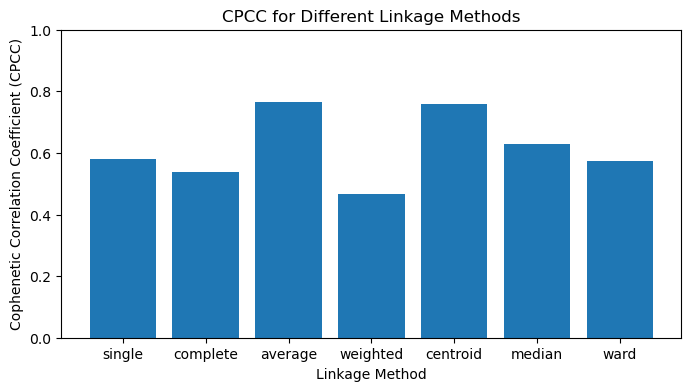

The best linkage method is 'average' with a CPCC of 0.767.


In [7]:
find_cpcc(cond_dist_mat_eu,linkage_methods);

From step 2, we select `average` linkage method for the case of Euclidean distance.  
Now we move on to experiment with the different number of clusters.  
Average-linkage is where the distance between each pair of observations in each cluster are added up and divided by the number of pairs to get an average inter-cluster distance.   
Equation:
\begin{equation*} D_{xy} = \frac{1}{|N_x||N_y|} \sum_{i \in N_x} \sum_{j \in N_y} d(x_{i},y_{j}) \end{equation*}

## Q1 Step 2.2:  
Find the [silhouette scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) of the N clusters and identify optimal number of clusters to have using the best linkage method.  
The simplest way is to find how the silhouette score changes with number of cluster, and select the number of cluster with the best silhouette score.  
----
The special thing about hierarchical clustering is that there's no predetermined number of groups to cluster.  
So we should choose the number of clusters that makes the most sense to us.  
----

In [8]:
# Define the chosen linkage method
chosen_linkage = 'average'

In [9]:
def find_best_sil_score(data, cond_dist_mat, chosen_linkage, n):
    """Find the silhouette scores of the N clusters, ranging from 2 to N.
    Args:
        data: array, standard scaled data to cluster
        cond_dist_mat: array, condensed distance matrix
        chosen_linkage: str, name of linkage chosen
        n: number of clusters to form for the selected linkage method
    Returns:
        best_score_dict: dict, {best_cluster_num: best score}
        cluster_score_dict: dict, {cluster_num: score}
    """
    # Define a range of cluster numbers to consider
    cluster_range = range(2, n+1)
    # Lists to store silhouette scores
    silhouette_scores = []
    cluster_score_dict = {}
    # Perform hierarchical clustering
    link_mat = linkage(cond_dist_mat, method=chosen_linkage)    
    # Calculate silhouette scores for different numbers of clusters
    for n_clusters in cluster_range:
        cluster_labels = fcluster(link_mat, t=n_clusters, criterion='maxclust')
        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        cluster_score_dict[n_clusters] = silhouette_avg
        
    # Plot silhouette scores according to dendrogram level
    plt.figure(figsize=(16, 4))
    # plt.plot(dendrogram_dict['icoord'], silhouette_scores, marker='o', linestyle='-', markersize=6)
    plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score vs. Number of clusters for {chosen_linkage} Linkage')
    plt.grid(True)
    plt.show()

    # Select the number of clusters that maximizes the silhouette score
    optimal_num_clusters = cluster_range[np.argmax(silhouette_scores)]
    print(f"The optimal number of clusters for {chosen_linkage} linkage is {optimal_num_clusters}, with a silhouette score of {max(silhouette_scores):.3f}.")
    return {optimal_num_clusters:max(silhouette_scores)}, cluster_score_dict

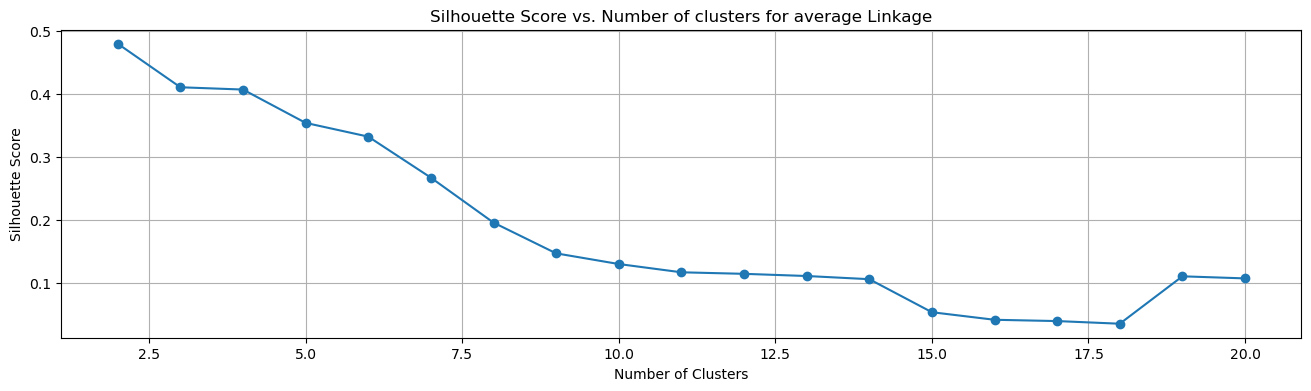

The optimal number of clusters for average linkage is 2, with a silhouette score of 0.479.


In [10]:
# Let n be 20. This means we examine up to 20 clusters
clus_opt, cluster_score_dict = find_best_sil_score(clus_ss, cond_dist_mat_eu, chosen_linkage, 20);

The Silhouette Score shows a constantly decreasing trend which is worrying.  
This is because according to the Silhouette Score, 2 cluster might be the best choice.  
However, knowing that hierarchical clustering tends to be very affected by outliers, and that they don't care about the balance in cluster size.  
The 2 clusters can end up with 1 data point in a cluster, and the rest of those 855 data points in another cluster...  
This is something we can't prevent, but we may not want to see.  
This means we need to use more aids to confirm our choice.  
----

One way to do so is to visualise how the clusters are split using a dendrogram.  
I will create a dendrogram below and observe how the clsuters are being split.  
If the last few clusters have long distance before they join, then that means they are split into distinct groups.  
Else, it means there are many outliers which didn't belong to any distinct groups.  

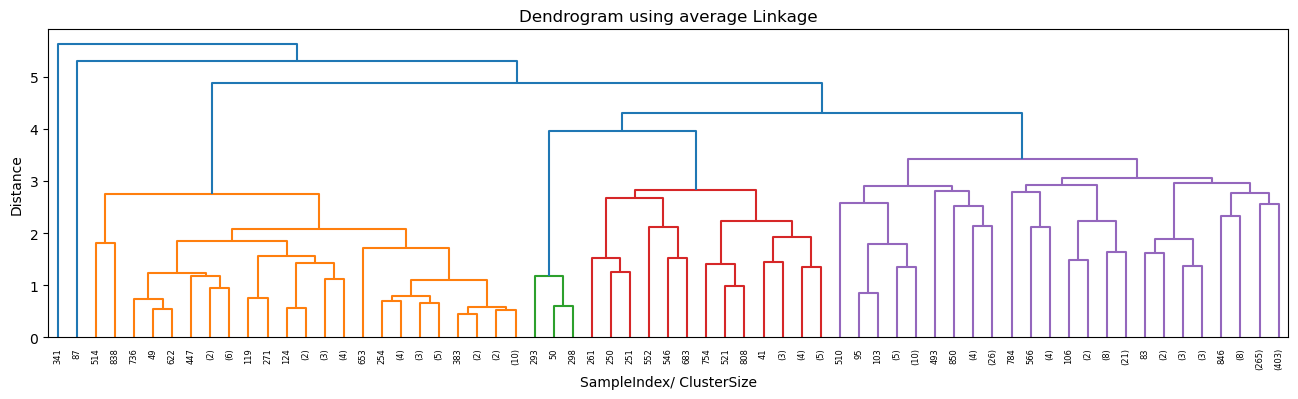

In [11]:
# Craete a dendrogram to visualise how the clusters are formed
# Perform hierarchical clustering
link_mat_eu = linkage(cond_dist_mat_eu, method=chosen_linkage)

# Create a dendrogram
plt.figure(figsize=(16, 4))
dendrogram_dict = dendrogram(link_mat_eu, p=8, labels=range(1, len(clus_ss)+1), truncate_mode='level', count_sort=True)
plt.xlabel('SampleIndex/ ClusterSize')
plt.ylabel('Distance')
plt.title(f'Dendrogram using {chosen_linkage} Linkage');

Very unfortunately, we encountered the case where outliers are not part of any clusters.  
This is evident from sample index 341 and 87.  
These 2 trouble makers are a class of their own...  
So we can not simply conclude using silhoutte score only.  
We have to dig deeper into the data.  
One way to do so is use clustermap to examine how these points are like.  
----

Examine the resultant calssification in a visually intuitive way, using cluster heatmap.  
The dendrogram is on the left hand side.  
The index are on the right handside, while the feature names are at the bottom.  

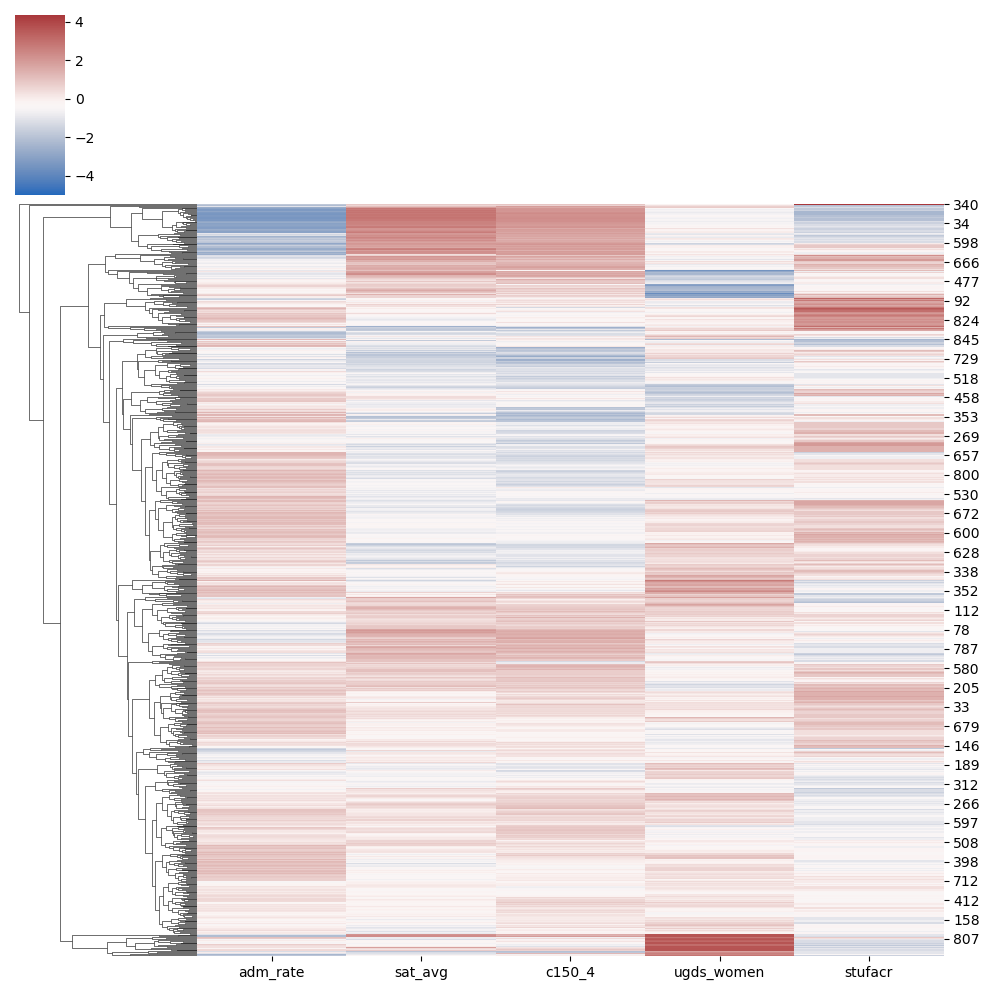

In [12]:
# Plot Clustermap of the MRCI_clus_2310 data
sns.clustermap(clus_ss_df, method=chosen_linkage, metric='euclidean', cmap="vlag", col_cluster=False);

From the cluster map, we can observe that it is actually really difficult to tell the different clusters apart.  
This is very unfortunate for us, as we do not have a distinctive split if we just use hierarchical clustering alone.   
We can rule out some of the really bad options using the cluster map though.  
Looking at the clsutermap, I can say that about 2 to 6 clusters will be a good choice.  
This means we have to further our prob into the problem.  
This time, I will use a trick called the elbow method.  
----

Elbow method will helpme find the point of diminishing return to continue clustering the data.  
According to [wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), the goal is to minimize the total intra-cluster variation (WSS).   
Therefore, we can implement the Elbow Method as a reference for determining the optimal number of clusters:

In [13]:
# Define a function to implement the elbow method.  
def find_wss(K, data, metric, linkage):
    """Calculate the total intra-cluster variation (WSS)
    Args:
        K: int, examine up to K number of clusters
        data: array, the standardised data to cluster
        metric: str, 'euclidean' or 'mahattan (city block)'
        linkage: str, linkage type
    Returns:
        wss_lst: list, intra-cluster variation for different n clusters
    """
    # Have a place holder to hold the wss results
    wss_lst = []
    # Loop through K number of clusters
    for i in range(K):
        # Create the cluster transformer object
        cluster = AgglomerativeClustering(n_clusters= i+1, metric=metric, linkage=linkage)  
        # Apply the cluster object
        cluster.fit_predict(data)
        # Obtain the cluster label
        label = cluster.labels_
        wss = []
        # For each cluster
        for j in range(i+1):
            # extract each cluster according to its index
            idx = [t for t, e in enumerate(label) if e == j]
            cluster = data[idx,]
            # calculate the WSS:
            cluster_mean = cluster.mean(axis=0)
            distance = np.sum(np.abs(cluster - cluster_mean)**2,axis=-1)
            wss.append(sum(distance))
        wss_lst.append(sum(wss))
    return wss_lst

Apply the defined function and plot a graph explained variation agianst number of clusters. 

In [14]:
AgglomerativeClustering()

AgglomerativeClustering()

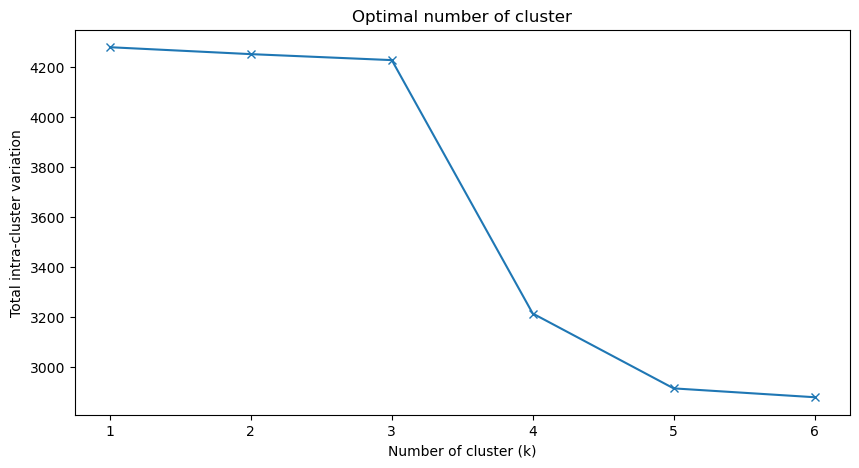

In [15]:
# Find the total intra-cluster variation for up to 6 clsuters
# 6 clusters is decided by looking at dendrogram and clutermap
wss_lst=find_wss(6, clus_ss, 'euclidean', chosen_linkage)
# Create the label
cluster_range = range(1, 7)
# Plot the result
plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster');
plt.xlabel('Number of cluster (k)');
plt.ylabel('Total intra-cluster variation');
plt.plot(cluster_range, wss_lst, marker = "x");

In [16]:
# Print the score for 5 clusters
print(f"The Silhouette Score for 5 clusters is : {cluster_score_dict[5]:.3}")

The Silhouette Score for 5 clusters is : 0.354


The gain in explained variance reduces significantly from 4 to 5 to 6 (‘elbow’ is at k = 5).   
So, optimal number of clusters could be 5.  
Going back to the dendrogram, 5 makes sense.  
2 clusters with 1 data point and 3 larger clusters.  
The Silhouette Score is 0.354.  
Additional methods that can be explored are the inconsistent method.  
This can be done with [scipy.cluster.hierarchy.inconsistent](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.inconsistent.html).  
Then examine the inconsistency coefficient at `R[i:3]`.  
However, this method is unstable as result can change with depth `d`, hence I did not try it here.  

----
Now we can plot a final fancy dendrogram to show the clustering process, just for fun.  =D  

In [17]:
# This code is purely for visualisation purpose and does not play a part in analysis
def fancy_dendrogram(*args, **kwargs):
    plt.figure(figsize=(10,5))
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata
# the following code is from
# [https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/]

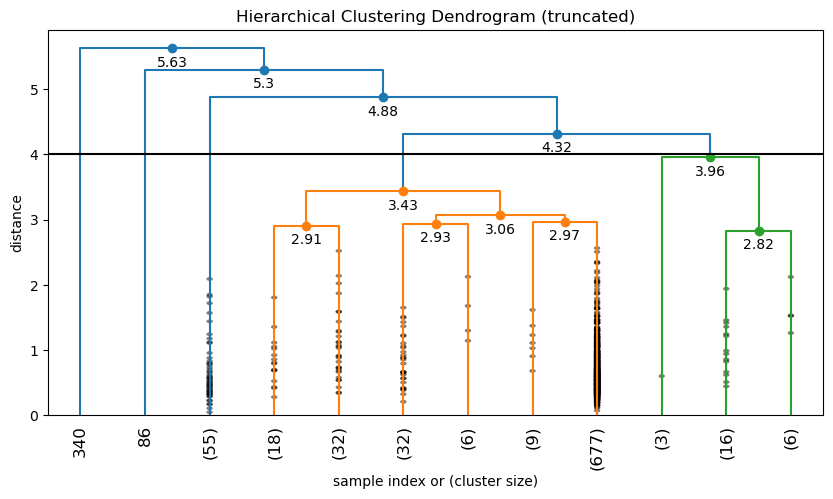

In [18]:
# Use the fancy dendrogram function
fancy_dendrogram(
    link_mat_eu,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=4,  # a horizontal cut-off line
)

plt.show()

This is a much neater truncated dendrogram that indicates the distance at the point of merging into 1 cluster.   
By cutting at distance = 4, I am able to get a total of 5 clusters.  

## Q1 Step 2.3:
Now that we have finally determined the optimal numbe of clusters to have is 5, we should create the corresponding label and use them to examine the data in each cluster.  
To do so, we first label the data and decided which cluster they belongs to.   
I will use sklearn library to do so.  
Steps to take now:
* Create the label using sklearn
* Split the dataset
* Examine the different clusters
* Outline the properties/differences of the clusters I identified.

In [19]:
# Set the number of cluster to have to be 5
num_cluster = 5

In [20]:
# Create cluster object
cluster=AgglomerativeClustering(n_clusters=num_cluster, metric='euclidean', linkage=chosen_linkage)
# Fit the standard scaled data into the cluster object and predict the label
cluster.fit_predict(clus_ss)
# Find the label or result of the clustering
pred_label = cluster.labels_
# Reshape into the correct shape of (856,1), instead of default (856,)
pred_label = pred_label.reshape(-1,1)
# Stack the array and data together
# Append the label to the standard scaled data
clus_ss_w_label = np.hstack((clus_ss, pred_label))
# Change the matrix into dataframe for simpler analysis
clus_eucli_res_df = pd.DataFrame(clus_ss_w_label, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr", "label"])

In [21]:
# Display the frist 5 rows to take a look at it.
clus_eucli_res_df.head()

adm_rate   sat_avg    c150_4  ugds_women   stufacr  label
0 -0.100214 -1.637257 -1.969576    0.157315  1.135143    1.0
1  0.737952  0.801589  0.147183    0.391960  1.402825    1.0
2  0.002207  1.067360  0.040668   -1.487806  1.402825    1.0
3  1.205524 -1.629440 -1.947411    0.639641 -0.203263    1.0
4  0.260980  0.629619  0.749333   -0.125128  1.402825    1.0

Now we have the dataset labeled, it make sense to see the size of each of these clusters.

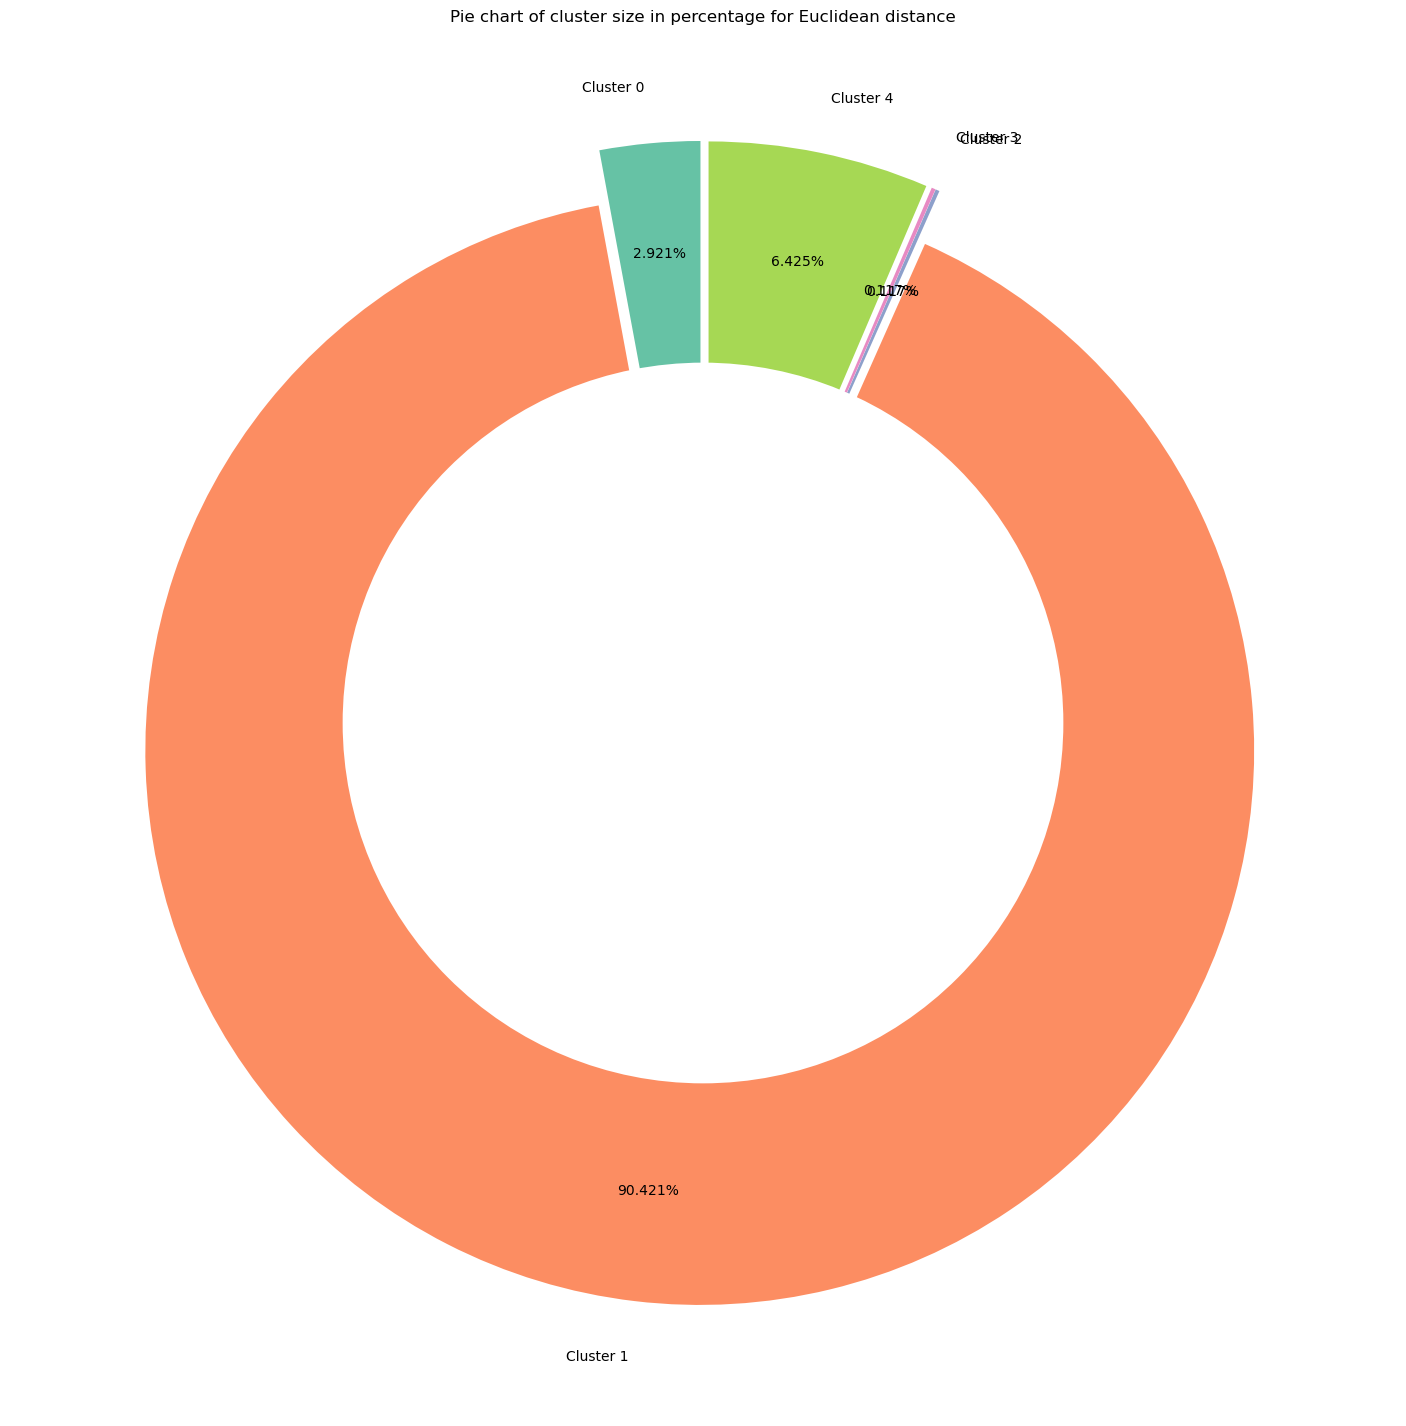

In [22]:
# Declare data
data = list(clus_eucli_res_df.groupby('label').count()['adm_rate'])
# Declare the key
keys = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'] 

plt.figure(figsize=(18,18))

plt.pie(
    x=data, labels=keys,
    colors=sns.color_palette('Set2'),
    startangle=90,
    # show percentages
    autopct='%1.3f%%',
    # move the percentage inside the arcs
    pctdistance=0.80,
    # add space between the arcs
    explode=[0.05, 0.05, 0.05, 0.05, 0.05]
)

### Add a hole in the pie  
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title("Pie chart of cluster size in percentage for Euclidean distance")
plt.show()

In [23]:
# Find the number of university in each cluster
clus_eucli_res_df.groupby('label').count()["adm_rate"]

label
0.0     25
1.0    774
2.0      1
3.0      1
4.0     55
Name: adm_rate, dtype: int64

We can see that cluster 2 and 3 only have 1 university in them.   
This accounts for 0.117% of the data.  
The largest group is from cluster 1, it have 774 entries and accounts for 90.4% of the unversities.  
This tells us that majority of the university doesn't really standout.  
----
We now examine the different clusters.   
We can use the seaborn pair plot to visualise how the clusters are formed. 

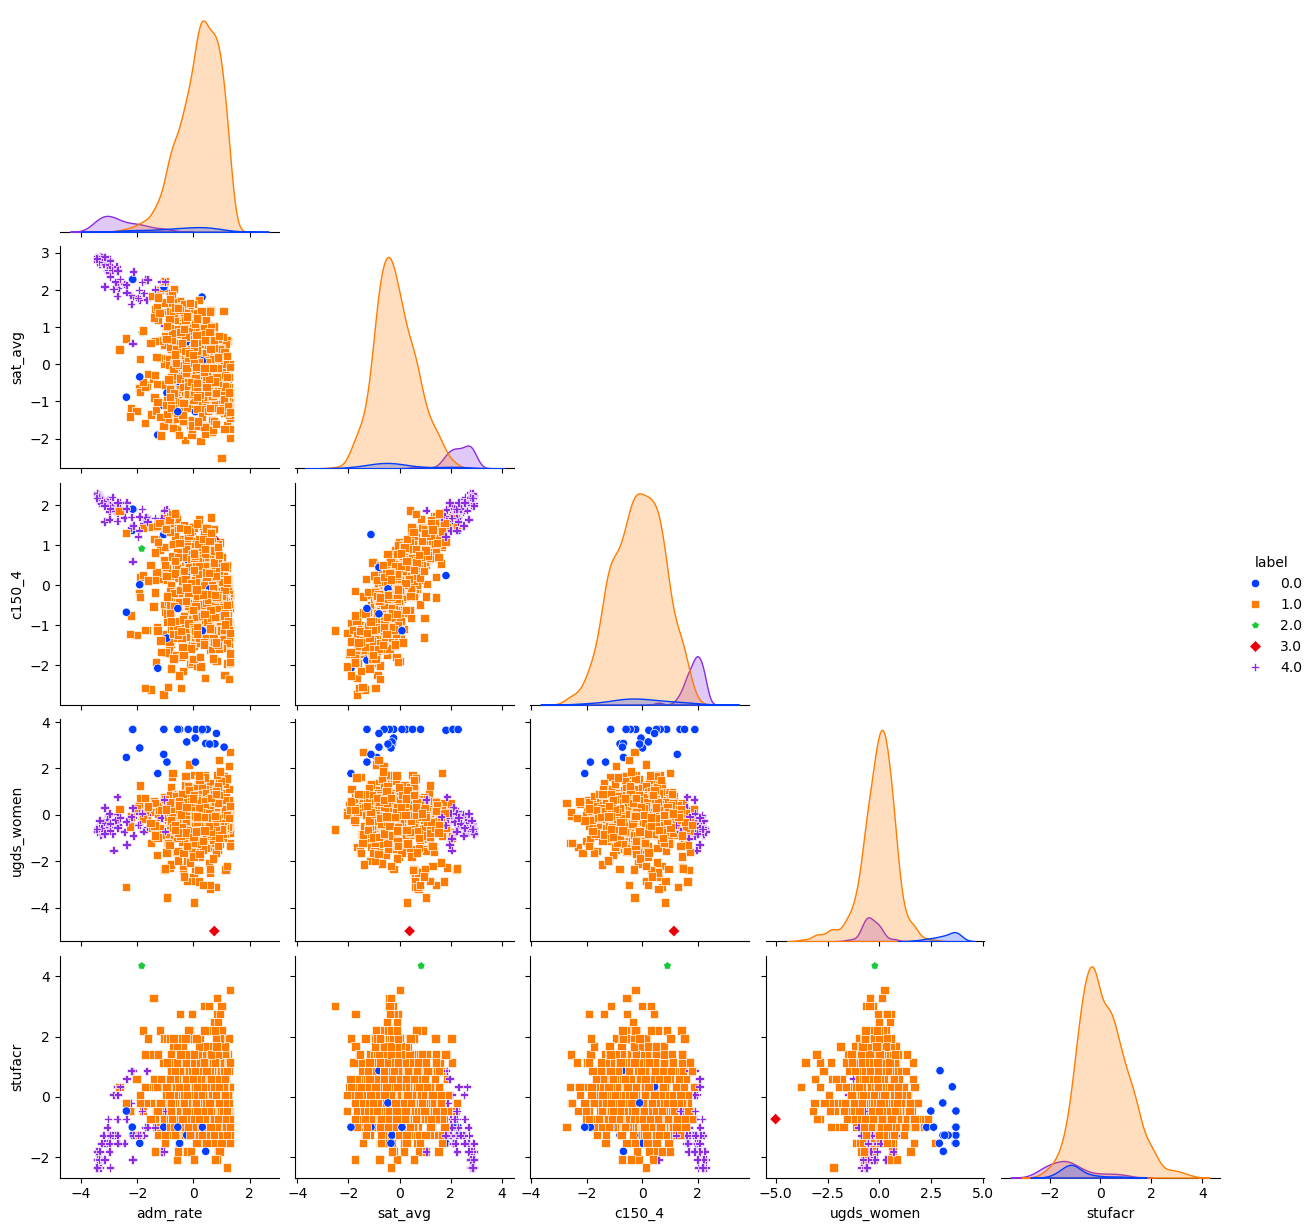

In [24]:
# Examine the different clusters using pairplot
sns.pairplot(clus_eucli_res_df, hue='label', palette='bright', corner=True, markers=['o','s', 'p', 'D', 'P'], );

From this graph, it is immediately apparent why the universities are clustered as such.  
cluster 0: High percentage of undergraduates who are women.  
cluster 1: The "normal" unvisersities.  
cluster 2: Extremely high student to faculty ratio. (Outlier)  
cluster 3: Extremely low percentage of undergraduates who are women. (Outlier)  
cluster 4: The "top schools" with high SAT average, low admission rate, low student faculty ratio, but most people still graduate in 4 years.  
Amazing! 

I will now split the data into sub groups and have their statistics described, just in case.  

### Cluster 0
High women enrollment rate.  

adm_rate    sat_avg     c150_4  ugds_women    stufacr
count  25.000000  25.000000  25.000000   25.000000  25.000000
mean   -0.381351  -0.080773  -0.084466    3.222159  -0.974185
std     1.011276   1.137591   1.017038    0.567050   0.595152
min    -2.391069  -1.903029  -2.069318    1.782448  -1.809350
25%    -1.055149  -0.808675  -0.673538    2.919171  -1.273987
50%    -0.185811  -0.339666  -0.088628    3.510129  -1.006306
75%     0.437123   0.246595   0.519063    3.685678  -1.006306
max     1.092219   2.286783   1.903145    3.685678   0.867462

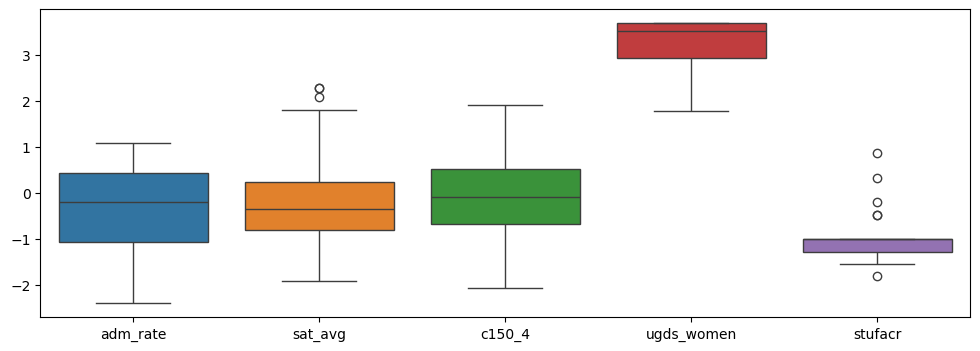

In [25]:
# Select the memebrs of cluster 0
c0_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==0.0].drop(columns="label")
# Show the distribution statistics for cluster 0
display(c0_eucli_df.describe())
# Visualise it using Box plot
plt.figure(figsize=(12, 4))
sns.boxplot(c0_eucli_df);
# As code is repeatative, comment will not be included in future cells following the same structure

### Cluster 2
The normal universities.   
It is normally distributed most of the time for all features.  

adm_rate     sat_avg      c150_4  ugds_women     stufacr
count  774.000000  774.000000  774.000000  774.000000  774.000000
mean     0.198264   -0.164252   -0.133195   -0.070350    0.111107
std      0.715014    0.798636    0.892925    0.837259    0.935310
min     -2.633514   -2.528374   -2.727496   -3.775158   -2.344712
25%     -0.247041   -0.730507   -0.766200   -0.498387   -0.470944
50%      0.291656   -0.249773   -0.114795    0.015659    0.064419
75%      0.757373    0.356030    0.524758    0.444103    0.599781
max      1.304976    2.239882    1.872361    2.705384    3.544274

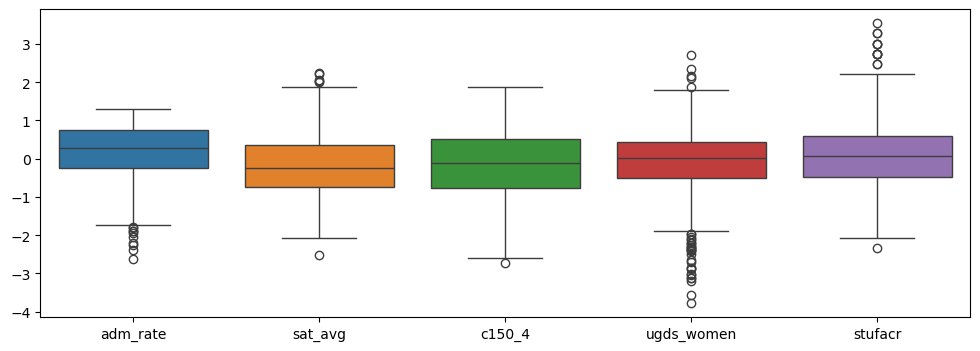

In [26]:
c1_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==1.0].drop(columns="label")
display(c1_eucli_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c1_eucli_df);

### Cluster 3
The university with highest student to faculty ratio and is difficult to get in, but doesn't need an exceptional result result.  

adm_rate   sat_avg    c150_4  ugds_women   stufacr
count  1.000000  1.000000  1.000000    1.000000  1.000000
mean  -1.843342  0.840673  0.916186   -0.222462  4.347318
std         NaN       NaN       NaN         NaN       NaN
min   -1.843342  0.840673  0.916186   -0.222462  4.347318
25%   -1.843342  0.840673  0.916186   -0.222462  4.347318
50%   -1.843342  0.840673  0.916186   -0.222462  4.347318
75%   -1.843342  0.840673  0.916186   -0.222462  4.347318
max   -1.843342  0.840673  0.916186   -0.222462  4.347318

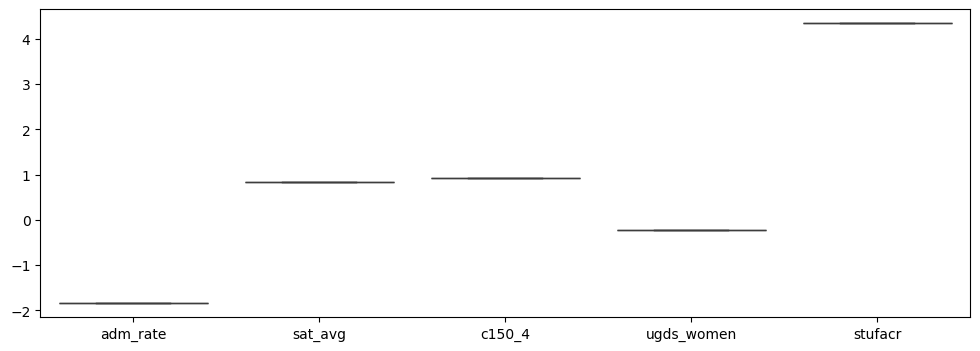

In [27]:
c2_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==2.0].drop(columns="label")
display(c2_eucli_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c2_eucli_df);

### Cluster 3
The monk temple...   
The university with lowest women enrollment rate.  

adm_rate   sat_avg    c150_4  ugds_women   stufacr
count  1.000000  1.000000  1.000000    1.000000  1.000000
mean   0.743395  0.387297  1.148303   -5.004871 -0.738625
std         NaN       NaN       NaN         NaN       NaN
min    0.743395  0.387297  1.148303   -5.004871 -0.738625
25%    0.743395  0.387297  1.148303   -5.004871 -0.738625
50%    0.743395  0.387297  1.148303   -5.004871 -0.738625
75%    0.743395  0.387297  1.148303   -5.004871 -0.738625
max    0.743395  0.387297  1.148303   -5.004871 -0.738625

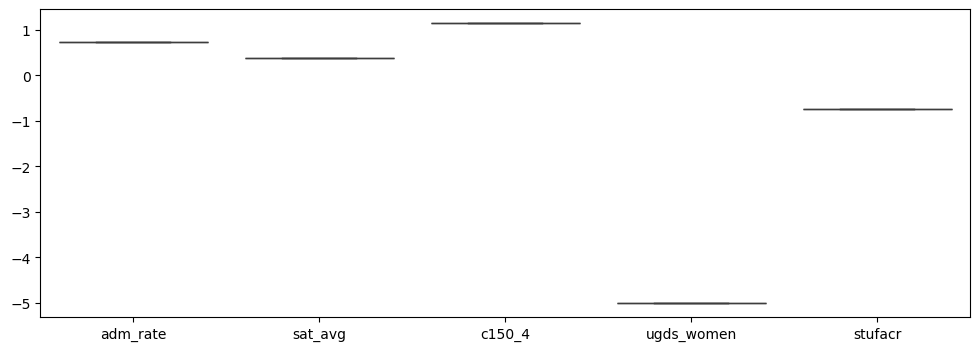

In [28]:
c3_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==3.0].drop(columns="label")
display(c3_eucli_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c3_eucli_df);

### Cluster 4
The top schools.   
High SAT score, low admission rate, high graduation rate.  

adm_rate    sat_avg     c150_4  ugds_women    stufacr
count  55.000000  55.000000  55.000000   55.000000  55.000000
mean   -2.596774   2.325867   1.875271   -0.379555  -1.186383
std     0.711985   0.480636   0.315271    0.430278   0.872807
min    -3.447435   0.567084   0.602798   -1.519092  -2.344712
25%    -3.170108   2.024920   1.692578   -0.670894  -1.809350
50%    -2.733460   2.364951   1.906839   -0.413654  -1.273987
75%    -2.149366   2.732341   2.074924   -0.112092  -0.738625
max    -0.972025   2.904311   2.309504    0.777820   0.867462

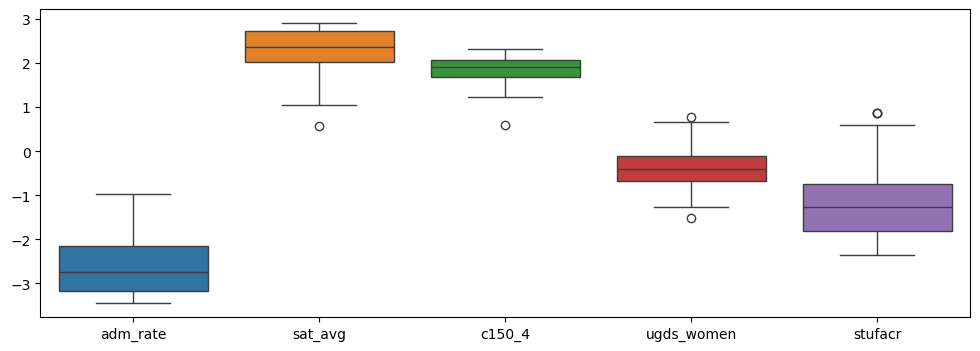

In [29]:
c4_eucli_df = clus_eucli_res_df.loc[clus_eucli_res_df["label"]==4.0].drop(columns="label")
display(c4_eucli_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c4_eucli_df);

With this, I have completed my analysis on clustering with Euclidean distance using average linkage method.
____

## Q1 Step 3:
Try the different linkage methods for Manhattan distance, and select the best linkage method.   

Manhattan distance is given by:  
$d(p,q) = \sum_{i=1}^n |p_i - q_i|$   
where $\mathbf{p}$ and $\mathbf{q}$ are two points in n-space, and $p_i$ and $q_i$ are their coordinates in the i-th dimension.

For the rest of the question, I will follow what I have done previously.  

1. Find the pair-wise distance using [scipy.spatial.distance.pdist()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) method.   
2. Find the [CPCC](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html) for each linkage method using scipy method.  
3. Select the linkage method with the highest CPCC. 

The typical linkage methods are:
* Single Linkage
* Complete Linkage
* Centroid Linkage
* Average Linkage

Note that ward and median requires euclidean metric!

In [30]:
# Calculate pairwise distances, now using mahanttan distance or city block distance. 
cond_dist_mat_man = pdist(clus_ss, metric='cityblock')

In [31]:
# List of linkage methods to compare, as stated on scipy documentation page
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid']

The CPCC score for each method:
single: 0.562
complete: 0.641
average: 0.709
weighted: 0.355
centroid: 0.708


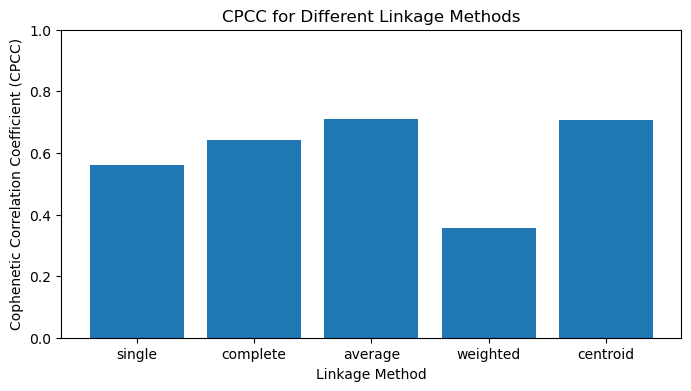

The best linkage method is 'average' with a CPCC of 0.709.


In [32]:
# Find best cpcc score and display it
find_cpcc(cond_dist_mat_man, linkage_methods);

For the case of Mahattan distance, the average linkage method is still the better method to use.  

## Q1 Step 3.2:
Find how silhouette score changes with number of cluster, and select the number of cluster with the best silhouette score.

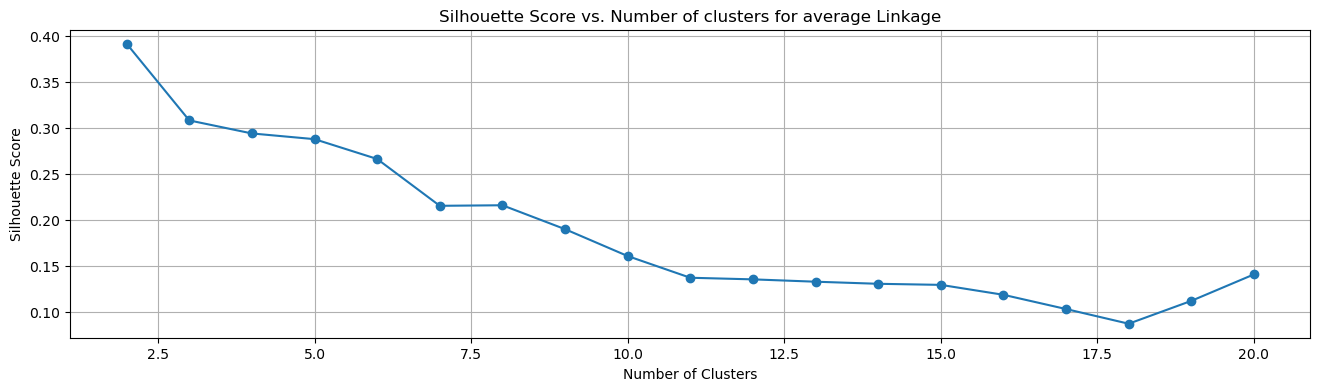

The optimal number of clusters for average linkage is 2, with a silhouette score of 0.392.


In [33]:
# Let n be 20. This means we examine up to 20 clusters
clus_opt, cluster_score_dict =find_best_sil_score(clus_ss, cond_dist_mat_man, chosen_linkage, 20);

As always, we should not just look at silhouette score.  
Let us take a look at the dendrogram now.  

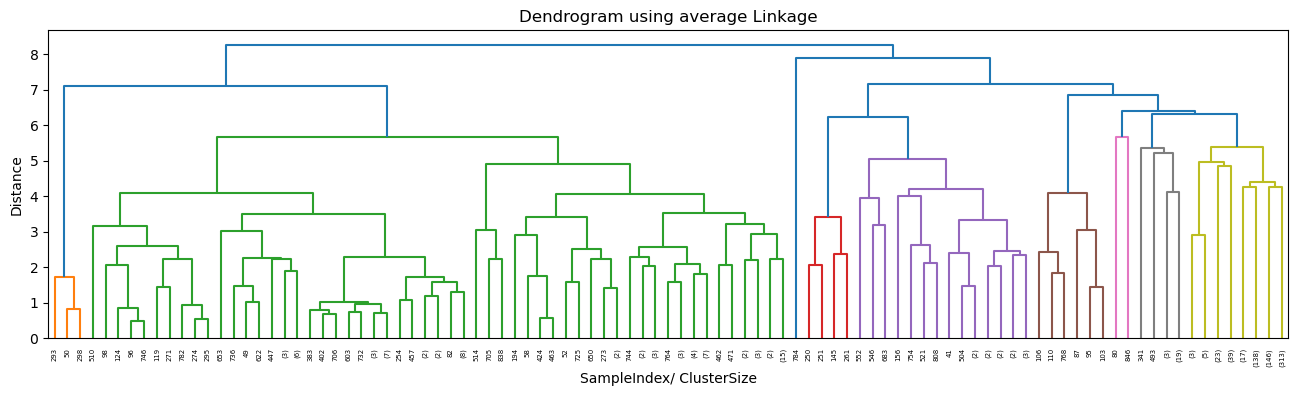

In [34]:
# Craete a dendrogram to visualise how the clusters are formed
# Perform hierarchical clustering
link_mat_man = linkage(cond_dist_mat_man, method=chosen_linkage)

# Create a dendrogram
plt.figure(figsize=(16, 4))
dendrogram_dict_man = dendrogram(link_mat_man, p=8, labels=range(1, len(clus_ss)+1), truncate_mode='level', count_sort=True)
plt.xlabel('SampleIndex/ ClusterSize')
plt.ylabel('Distance')
plt.title(f'Dendrogram using {chosen_linkage} Linkage');

Now, this dendrogram is very different from the one generated using Euclidean metric.   
It is less prone to effects of outliers, as only 1 university is considered as outlier, 2 distinct clusters can be seen.  
We examine the clustermap to confirm.  

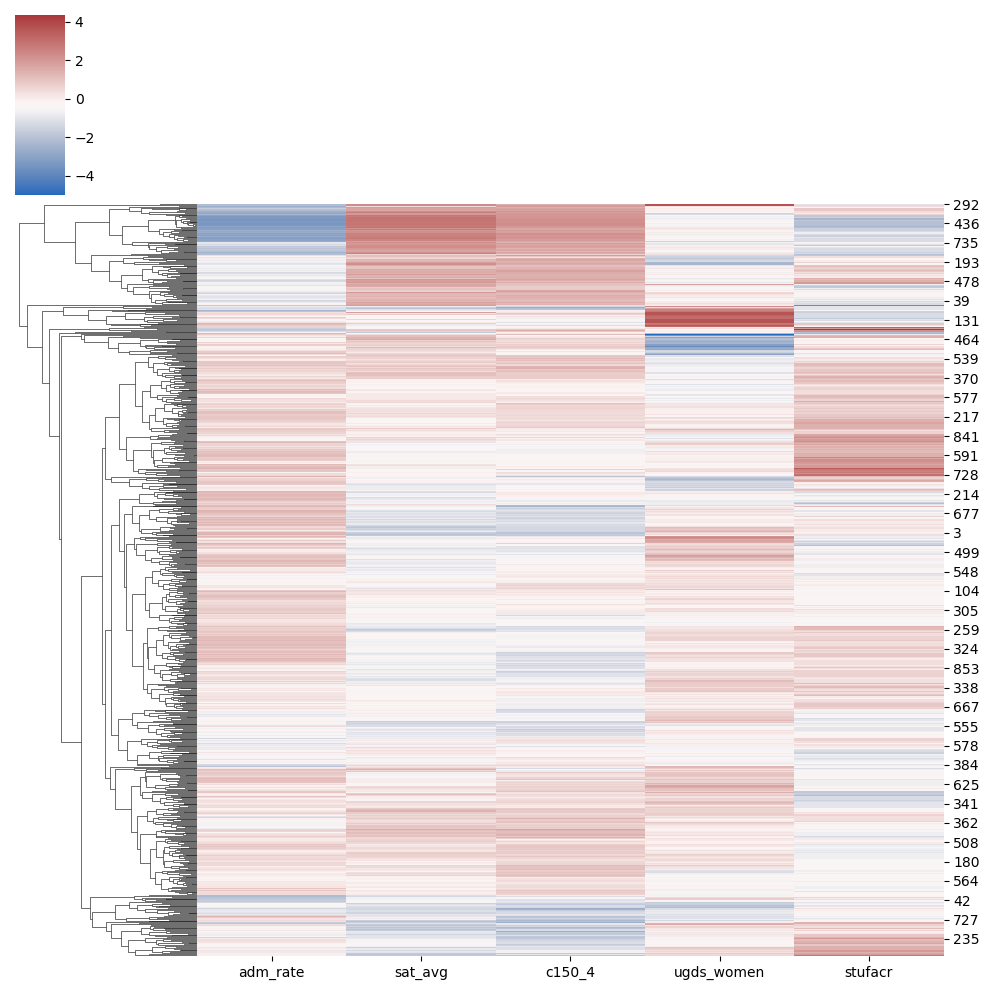

In [35]:
# Plot Clustermap of the MRCI_clus_2310 data
sns.clustermap(clus_ss_df, method=chosen_linkage, metric='cityblock', cmap="vlag", col_cluster=False);

2 to 3 distinct clusters can be observed from the clustermap, just like shown in the dendrogram.  
We still examine up to 6 cluster's intra-cluster distance. 

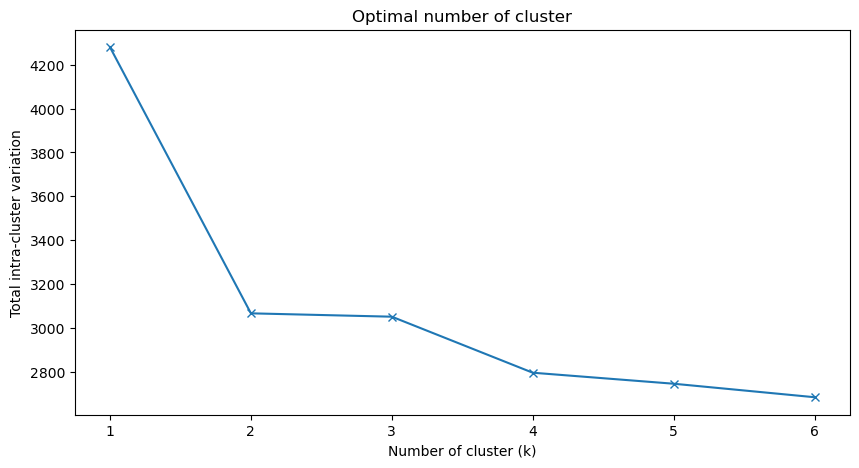

In [36]:
# Find the total intra-cluster variation for up to 6 clsuters
# 6 clusters is decided by looking at dendrogram and clutermap
wss_lst=find_wss(6, clus_ss, 'cityblock', chosen_linkage)
# Create the label
cluster_range = range(1, 7)
# Plot the result
plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster');
plt.xlabel('Number of cluster (k)');
plt.ylabel('Total intra-cluster variation');
plt.plot(cluster_range, wss_lst, marker = "x");

In [37]:
# Print the score for 4 clusters
print(f"The Silhouette Score for 4 clusters is : {cluster_score_dict[4]:.3}")

The Silhouette Score for 4 clusters is : 0.294


The gain in explained variance reduces significantly from 3 to 4 to 5 ('elbow' is at k = 4).  
So, optimal number of clusters could be 4.  
The Silhouette Score for 4 clusters is : 0.294  

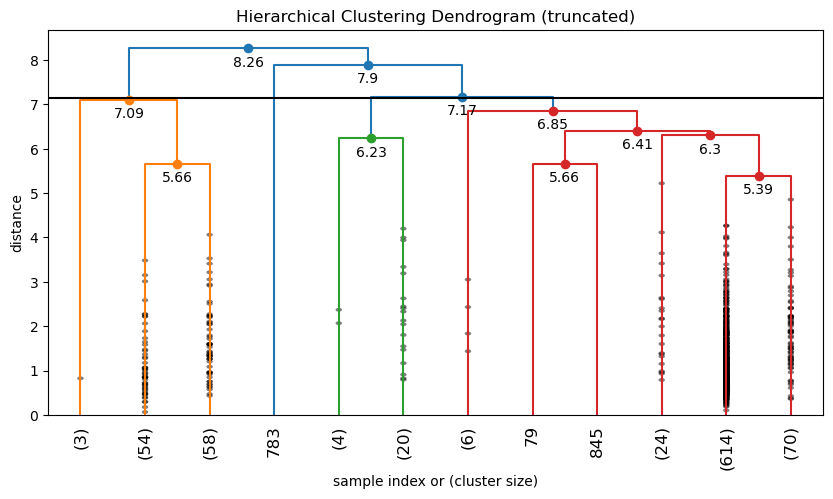

In [38]:
# Use the fancy dendrogram function
fancy_dendrogram(
    link_mat_man,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=7.15,  # a horizontal cut-off line
)

plt.show()

## Q1 Step 3.3:  
Now that we have finally determined the optimal numbe of clusters to have is 4, we should create the corresponding label and use them to examine the data in each cluster.  
To do so, we first label the data and decided which cluster they belongs to.   
I will use sklearn library to do so.  
Steps to take now:
* Create the label using sklearn
* Split the dataset
* Examine the different clusters
* Outline the properties/differences of the clusters I identified.

In [39]:
# Set the number of cluster to have to be 4 for manhanttan distance
num_cluster = 4

In [40]:
# Create cluster object
cluster=AgglomerativeClustering(n_clusters=num_cluster, metric='cityblock', linkage=chosen_linkage)
# Fit the standard scaled data into the cluster object and predict the label
cluster.fit_predict(clus_ss)
# Find the label or result of the clustering
pred_label = cluster.labels_
# Reshape into the correct shape of (856,1), instead of default (856,)
pred_label = pred_label.reshape(-1,1)
# Stack the array and data together
# Append the label to the standard scaled data
clus_ss_w_label = np.hstack((clus_ss, pred_label))
# Change the matrix into dataframe for simpler analysis
clus_man_res_df = pd.DataFrame(clus_ss_w_label, columns=["adm_rate", "sat_avg", "c150_4", "ugds_women", "stufacr", "label"])

A dataframe with the labels for each university using the mahattan distance is created.  
Now analyse the data.  

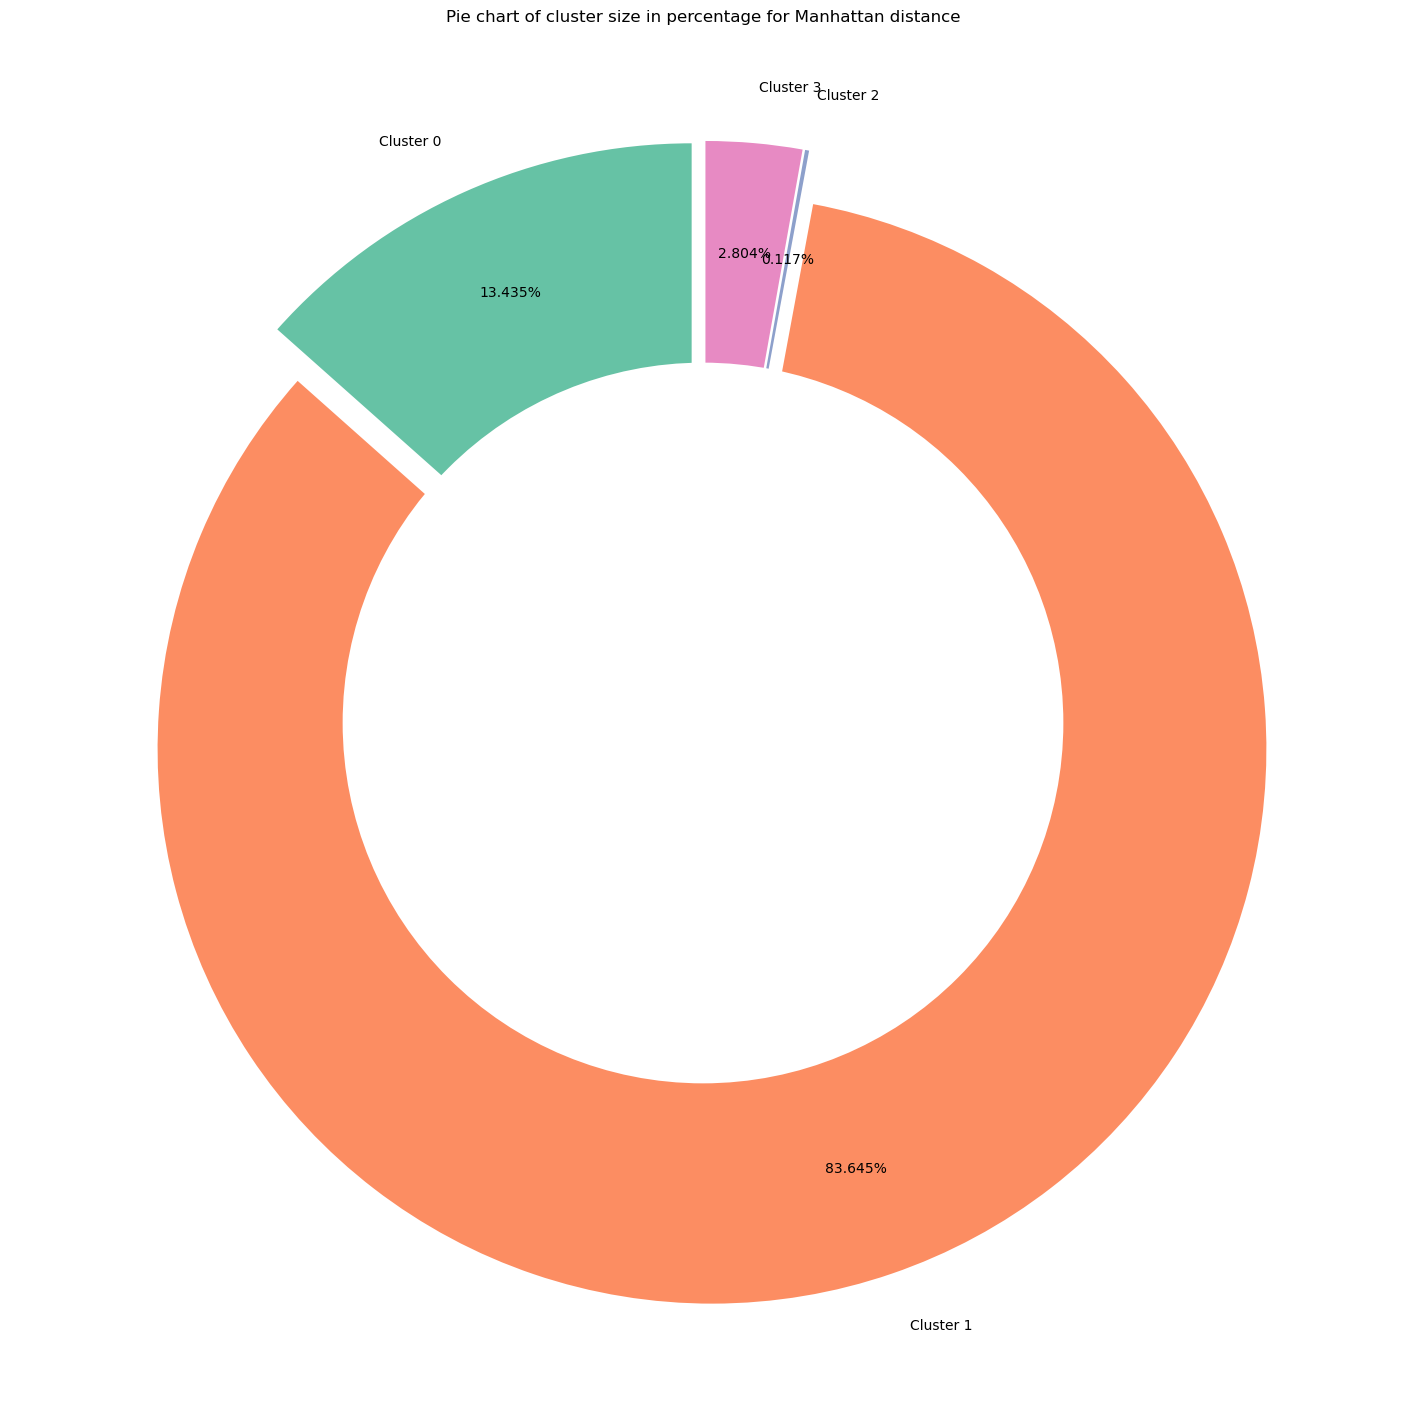

In [41]:
# Plot the pie chart to visualise the proportions.
# Declare data
data = list(clus_man_res_df.groupby('label').count()['adm_rate'])
# Declare the key
keys = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'] 

plt.figure(figsize=(18,18))

plt.pie(
    x=data, labels=keys,
    colors=sns.color_palette('Set2'),
    startangle=90,
    # show percentages
    autopct='%1.3f%%',
    # move the percentage inside the arcs
    pctdistance=0.80,
    # add space between the arcs
    explode=[0.05, 0.05, 0.05, 0.05]
)

### Add a hole in the pie  
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title("Pie chart of cluster size in percentage for Manhattan distance")
plt.show()

In [42]:
# Find the number of university in each cluster
clus_man_res_df.groupby('label').count()["adm_rate"]

label
0.0    115
1.0    716
2.0      1
3.0     24
Name: adm_rate, dtype: int64

Majoirty of the schools, 716 of them, are in cluster 1.  
Cluster 2 is the odd one out, with 1 school, likely outlier.  
Examine pairplot for property/ difference in cluster.  

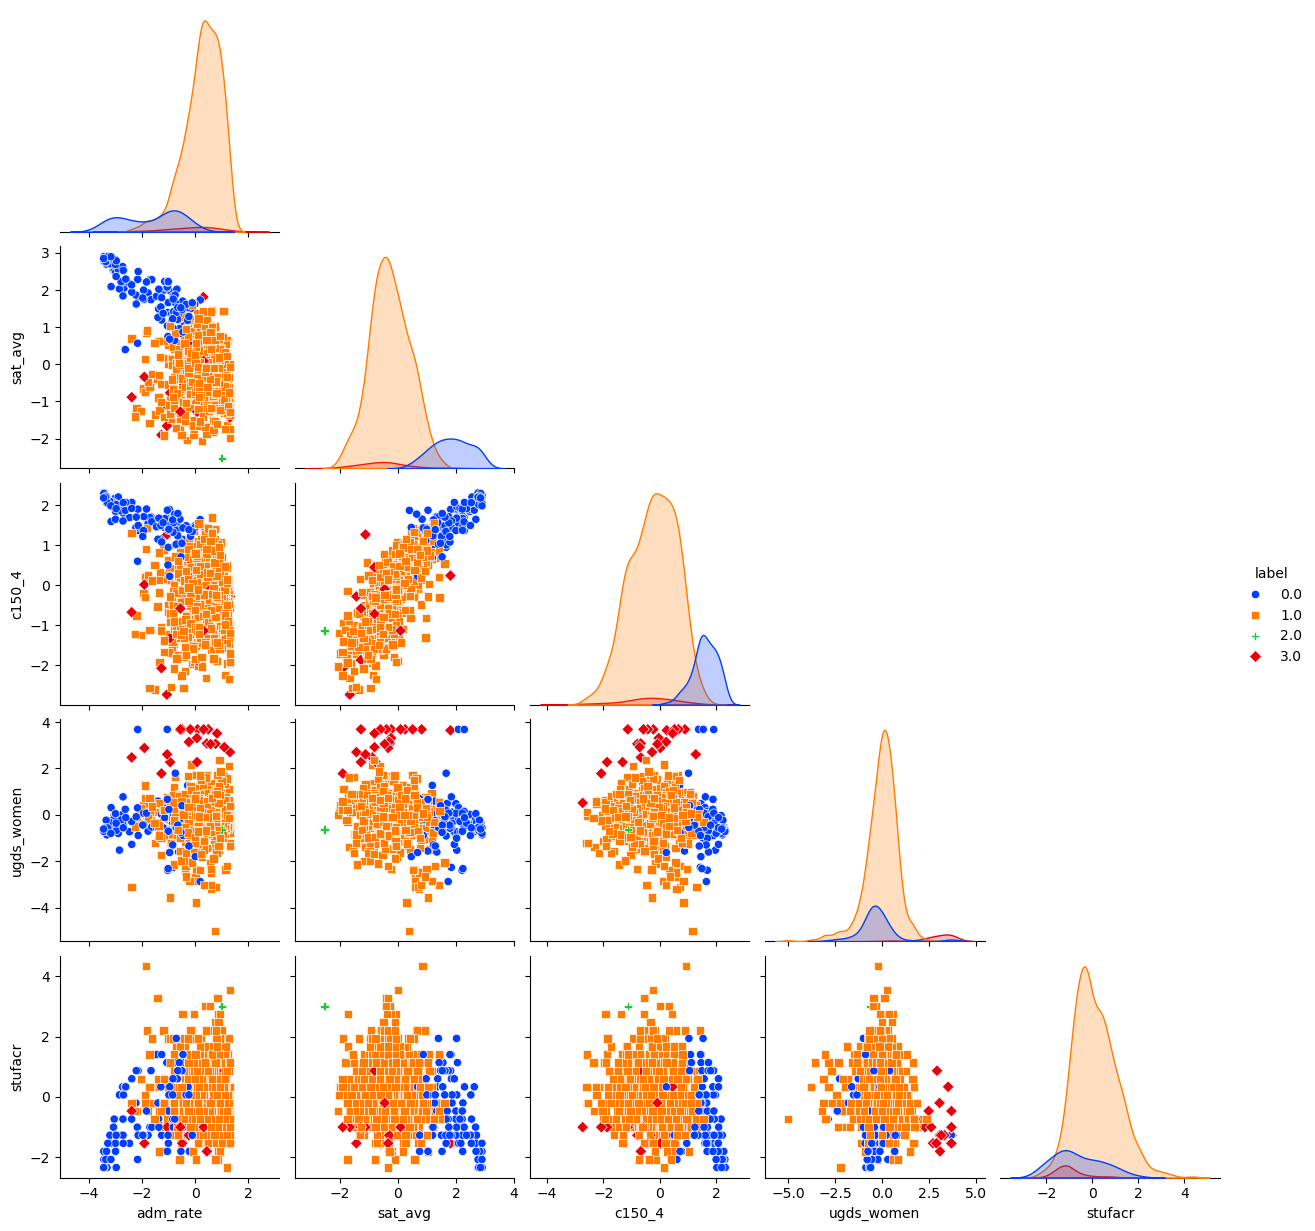

In [43]:
# Examine the different clusters using pairplot
sns.pairplot(clus_man_res_df, hue='label', palette='bright', corner=True, markers=['o','s', 'P', 'D'], );

The most prominent difference we can clearly see how the schools are clustered!  
Cluster 0: High SAT average, high percentage of students graduate in time, distribution of admission rate is 2 peaked.   
Cluster 1: The normal schools, with okay admission rate.   
Cluster 2: The outlier with lowest SAT, but not the highest admission rate. (Outlier)  
Cluster 3: School woth high admission rate for women.  

### Cluster 0
Better school with higher SAT average.  

adm_rate     sat_avg      c150_4  ugds_women     stufacr
count  115.000000  115.000000  115.000000  115.000000  115.000000
mean    -1.656051    1.843128    1.582663   -0.306564   -0.629225
std      1.093813    0.656739    0.432270    0.944513    1.049317
min     -3.447435    0.395114    0.226608   -2.873079   -2.344712
25%     -2.719359    1.348765    1.369646   -0.690882   -1.273987
50%     -1.293635    1.841225    1.595298   -0.365856   -0.738625
75%     -0.732302    2.290691    1.904685    0.029130    0.064419
max      0.186762    2.904311    2.309504    3.685678    1.938187

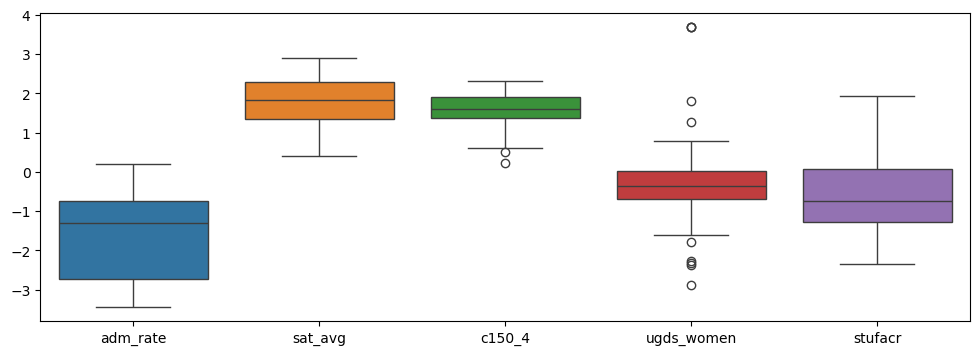

In [44]:
c0_man_df = clus_man_res_df.loc[clus_man_res_df["label"]==0.0].drop(columns="label")
display(c0_man_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c0_man_df);

### Cluster 2
The normal school, even the distribution seems very normal... 

adm_rate     sat_avg      c150_4  ugds_women     stufacr
count  716.000000  716.000000  716.000000  716.000000  716.000000
mean     0.270036   -0.276062   -0.238767   -0.051453    0.129843
std      0.679924    0.683437    0.819249    0.842109    0.940060
min     -2.395522   -2.059365   -2.598200   -5.004871   -2.344712
25%     -0.106151   -0.753957   -0.813301   -0.455586   -0.470944
50%      0.344103   -0.324032   -0.200376    0.036951    0.064419
75%      0.792626    0.186015    0.420706    0.479952    0.599781
max      1.304976    1.606720    1.695656    2.351679    4.347318

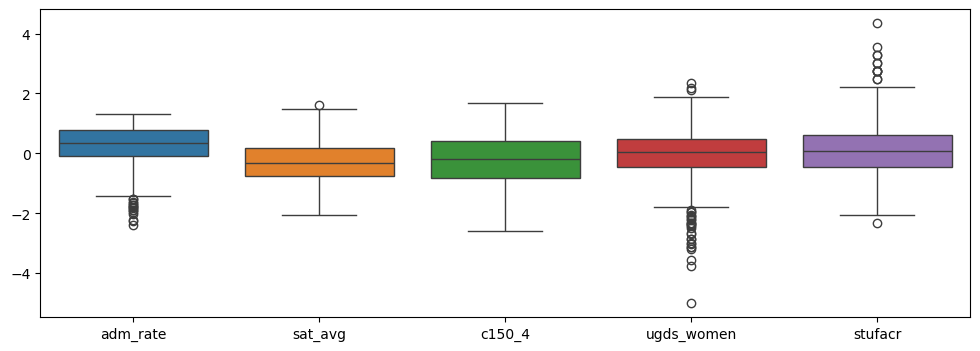

In [45]:
c1_man_df = clus_man_res_df.loc[clus_man_res_df["label"]==1.0].drop(columns="label")
display(c1_man_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c1_man_df);

### Cluster 2
Outlier in terms of SAT.

adm_rate   sat_avg    c150_4  ugds_women   stufacr
count   1.00000  1.000000  1.000000    1.000000  1.000000
mean    0.99722 -2.528374 -1.126689   -0.630049  3.008912
std         NaN       NaN       NaN         NaN       NaN
min     0.99722 -2.528374 -1.126689   -0.630049  3.008912
25%     0.99722 -2.528374 -1.126689   -0.630049  3.008912
50%     0.99722 -2.528374 -1.126689   -0.630049  3.008912
75%     0.99722 -2.528374 -1.126689   -0.630049  3.008912
max     0.99722 -2.528374 -1.126689   -0.630049  3.008912

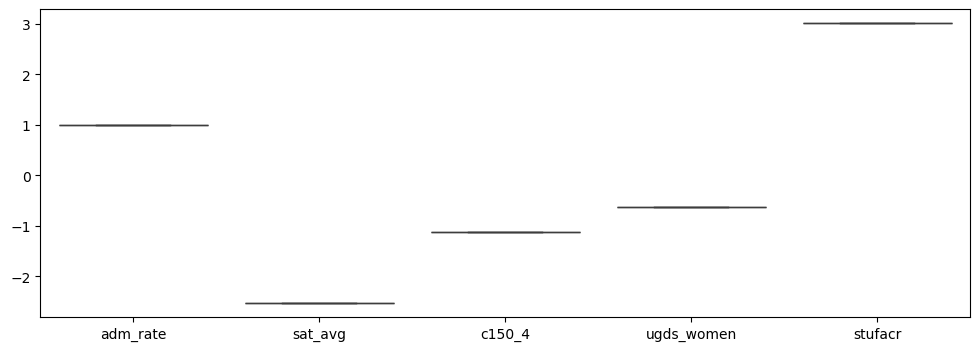

In [46]:
c2_man_df = clus_man_res_df.loc[clus_man_res_df["label"]==2.0].drop(columns="label")
display(c2_man_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c2_man_df);

### Cluster 3
High admission for women.  

adm_rate    sat_avg     c150_4  ugds_women    stufacr
count  24.000000  24.000000  24.000000   24.000000  24.000000
mean   -0.162371  -0.490465  -0.413432    3.030229  -0.983999
std     0.928769   0.819939   0.945647    0.774146   0.616080
min    -2.391069  -1.903029  -2.727496    0.516235  -1.809350
25%    -0.661671  -0.945469  -0.732952    2.681050  -1.273987
50%     0.065292  -0.449101  -0.350914    3.110364  -1.006306
75%     0.472995  -0.236093   0.228763    3.685678  -1.006306
max     1.304976   1.809957   1.269595    3.685678   0.867462

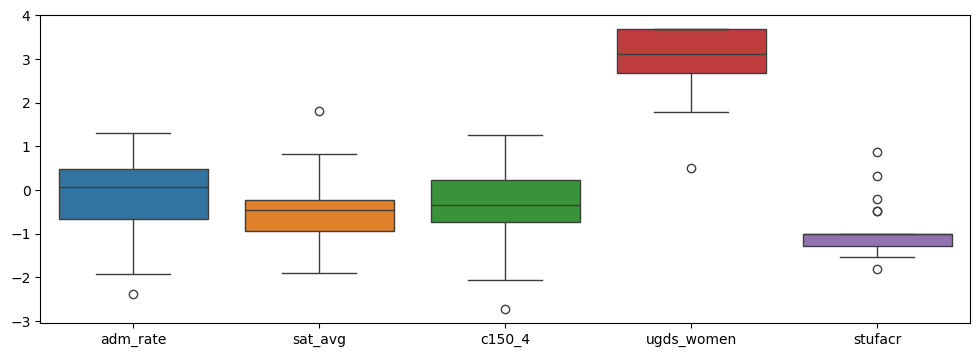

In [47]:
c3_man_df = clus_man_res_df.loc[clus_man_res_df["label"]==3.0].drop(columns="label")
display(c3_man_df.describe())
plt.figure(figsize=(12, 4))
sns.boxplot(c3_man_df);

With this, Qustion 1 is completed!

----

## Q1 Summary
For both Euclidean and Manhanttan metrics, the linkage method with the highest cophenetic correlation coefficient is the average linkage method.  
Euclidean: 0.767  
Manhattan: 0.709  

For Euclidean metric, the near optimal number of clusters is 5, with 2 outliers included.   
Silhouette Score: 0.354  

The clusters are clustered into:  
cluster 0: High percentage of undergraduates who are women.  
cluster 1: The "normal" unvisersities.  
cluster 2: Extremely high student to faculty ratio. (Outlier)  
cluster 3: Extremely low percentage of undergraduates who are women. (Outlier)  
cluster 4: The "top schools" with high SAT average, low admission rate, low student faculty ratio, but most people still graduate in 4 years.  

For Manhattan metric, the near optimal number of cluster is 4, with 1 outlier included.   
Silhouette Score: 0.294  

The clusters are clustered into:  
Cluster 0: High SAT average, high percentage of students graduate in time, distribution of admission rate is 2 peaked.   
Cluster 1: The normal schools, with okay admission rate.   
Cluster 2: The outlier with lowest SAT, but not the highest admission rate. (Outlier)  
Cluster 3: School woth high admission rate for women.  
----

# Question 2: Regression

**Use the data in the file `MRCI_regr_2310.csv`.**

Use the `statsmodels` package. After you fit a regression model in **each** part, be sure to
* assess its fit,
* study the residuals,
* check for influential points, and
* check for multicollinearity.

*For multicollinearity, you can report what is known as the Variance Inflation Factor (VIF) of the model, but include a small paragraph or two on what is multicollinearity and how it can affect your model.*

1. Fit a regression model of `MD_EARN_WNE_1YR` on all of `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`. *Do not standardise these variables.* Outline your findings and suggest *a few* other regression models you might consider fitting. *There is no need at this point to fit the regression models you suggested.*

Here are a couple of comments from your boss when you show him/her the analysis:
* "Have you tried standardising the variables `ADM_RATE`, `SAT_AVG`, `UGDS`, `COSTT4_A`, `C150_4`, `UGDS_WOMEN` and `STUFACR`?"
* "Have you tried adding `STATE` to your explanatory variables?"

2. Address his/her questions and other concerns you may have from part 1. You may remove the *most influential* point if it exists. Recommend a final regression model.

In [48]:
# Import the extra packages for Question 2
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, LassoCV, Lasso, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
# Import satsmodels package
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as oinf
# Import scipy package
import scipy.stats as stats
from scipy.sparse import issparse

## Q2 Part 1  
Things to do for Q2 part 1:  
1. Read in the data and explore the data.  
2. Fit the data using statsmodel.  
3. Outline findings on:  
    3.1 Fit  
    3.2 Residuals  
    3.3 Influential points (Outliers)  
    3.4 VIF & Multicollinearity  

Alrighty, let us get started by importing the data.  

In [49]:
# Read in the csv filr
regr_df = pd.read_csv('./data/MRCI_regr_2310.csv')
regr_df.head()

ADM_RATE  SAT_AVG     UGDS  COSTT4_A  C150_4  UGDS_WOMEN  STUFACR  \
0    0.7160    954.0   5098.0   21924.0  0.2807      0.5940     18.0   
1    0.8854   1266.0  13284.0   26248.0  0.6245      0.6210     19.0   
2    0.7367   1300.0   7358.0   24869.0  0.6072      0.4047     19.0   
3    0.9799    955.0   3495.0   21938.0  0.2843      0.6495     13.0   
4    0.7890   1244.0  30725.0   31050.0  0.7223      0.5615     19.0   

   MD_EARN_WNE_1YR    STATE  
0          30999.0  Alabama  
1          45270.0  Alabama  
2          57386.0  Alabama  
3          27282.0  Alabama  
4          44620.0  Alabama

Then we explore the data by looking at the summary statistics and plot some graphs.  

In [49]:
# See how the data is distributed numerically
regr_df.describe(exclude=object).round(3)

ADM_RATE   SAT_AVG       UGDS   COSTT4_A   C150_4  UGDS_WOMEN  STUFACR  \
count   851.000   851.000    851.000    851.000  851.000     851.000  851.000   
mean      0.737  1163.611   6141.542  39024.510    0.601       0.576   13.757   
std       0.202   127.652   8266.529  17010.352    0.162       0.115    3.736   
min       0.040   840.000    137.000   9715.000    0.158       0.000    5.000   
25%       0.648  1076.000   1378.000  23675.500    0.484       0.516   11.000   
50%       0.782  1139.000   2826.000  37413.000    0.602       0.577   13.000   
75%       0.882  1232.000   7026.500  51020.500    0.709       0.631   16.000   
max       1.000  1535.000  72229.000  81531.000    0.976       1.000   30.000   

       MD_EARN_WNE_1YR  
count          851.000  
mean         43200.456  
std          10667.843  
min          15229.000  
25%          36769.500  
50%          41299.000  
75%          47584.500  
max         118133.000

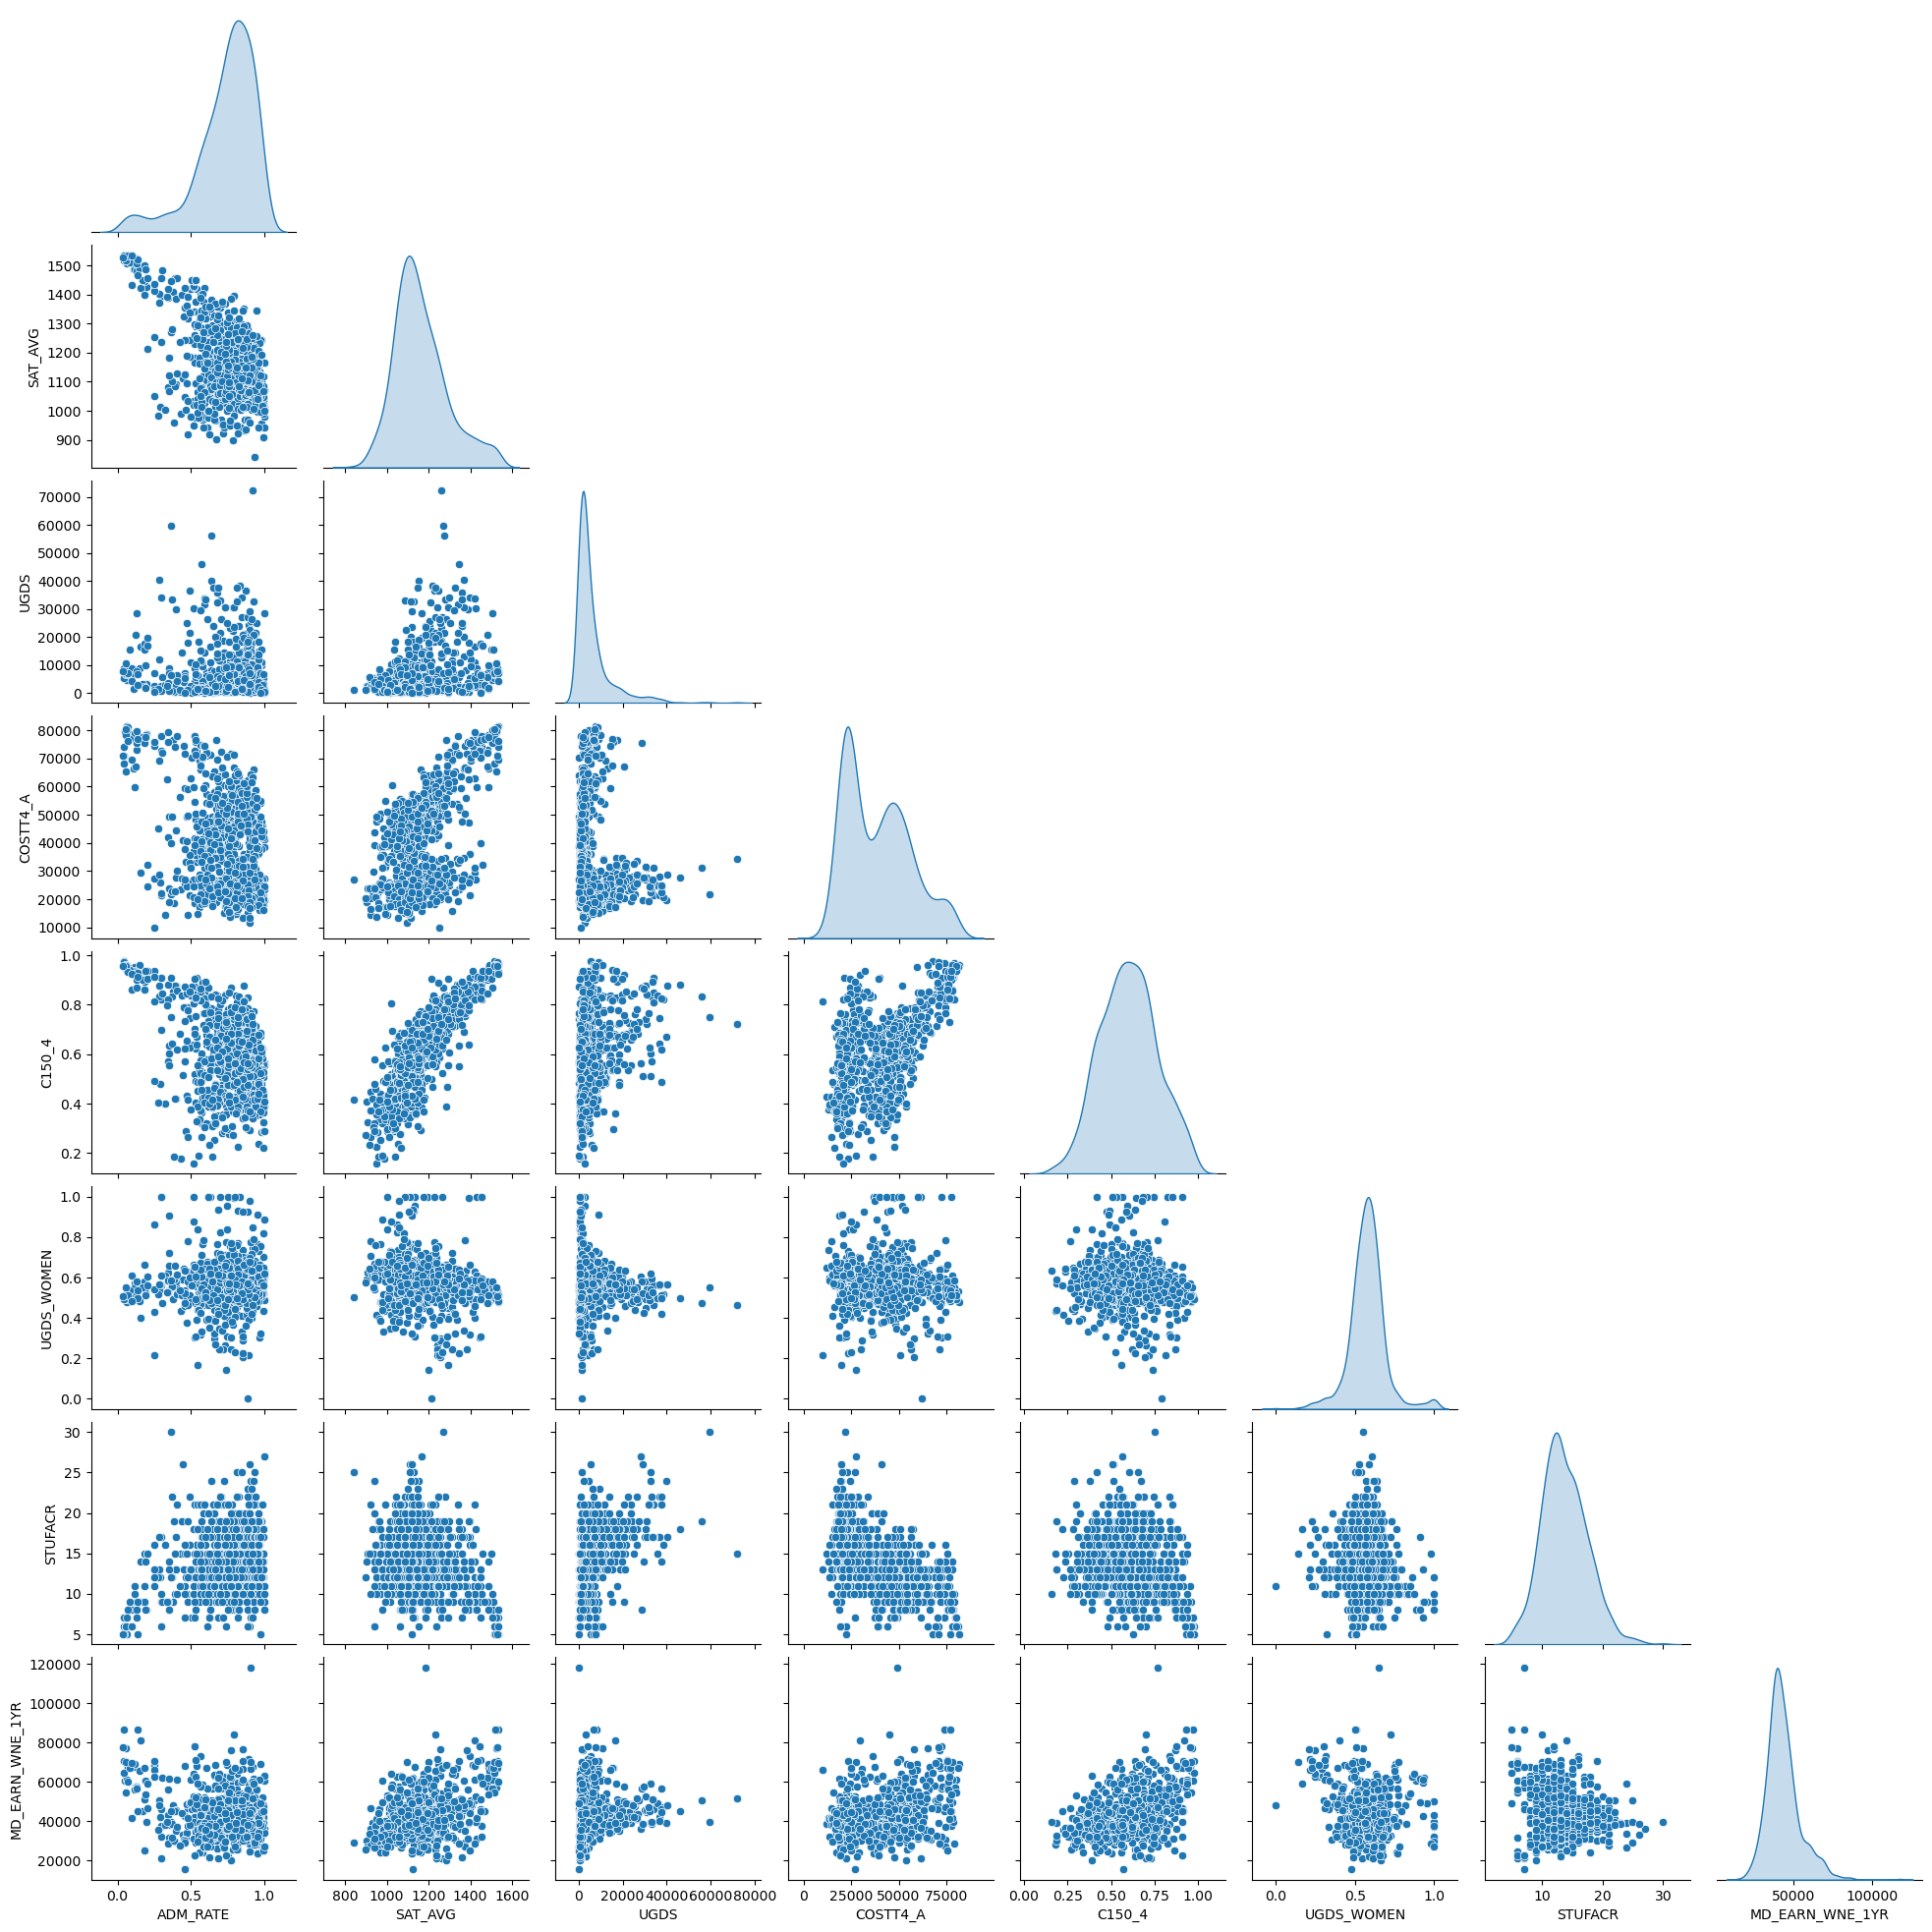

In [50]:
# Plot pairplot to visualise the dataset.  
sns.pairplot(regr_df, corner=True, diag_kind='kde');

----
From the data, we can see that average cost of attendence, `COSTT4_A`, have 2 peaks.   
Admission rate is generally high.  
Both average and mean SAT is about 1.1k, quite normally distributed.  
Number of student in a school is very skewed, most school only accept less than 2k undergards.   
Cost to attend is varied, most less than 25k, 2nd peak at close to 40k.  
Completion rate is very normally distrbuted.  
Women makes about 57% of the cohort, and this is also very normally distributed.  
Student faculty ratio is normally distrbuted around 13.  
Their earning is about 41 to 43k a year, normally distributed.  
There is a school with 118k median salary...  
~I want to join that school!!! Let me join that school!!!~  
I predict this will probably be the most influencial point.  
We take a closer look at how the meadian earning are distributed.   

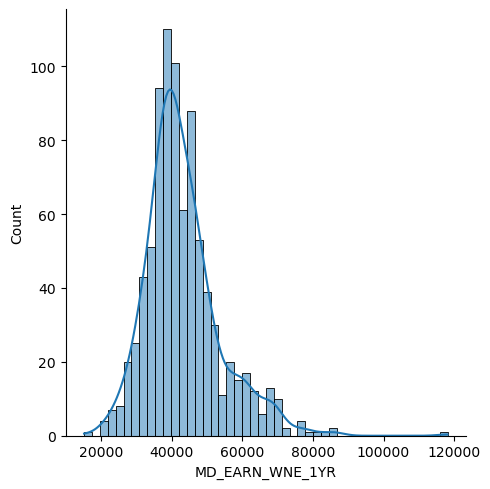

In [51]:
sns.displot(regr_df["MD_EARN_WNE_1YR"], kde=True);

We can see that it is somewhat normally distributed.  
It is right skewed, mainly due to 120k school, and also some schools that have graduates earning 60k to 80k.   

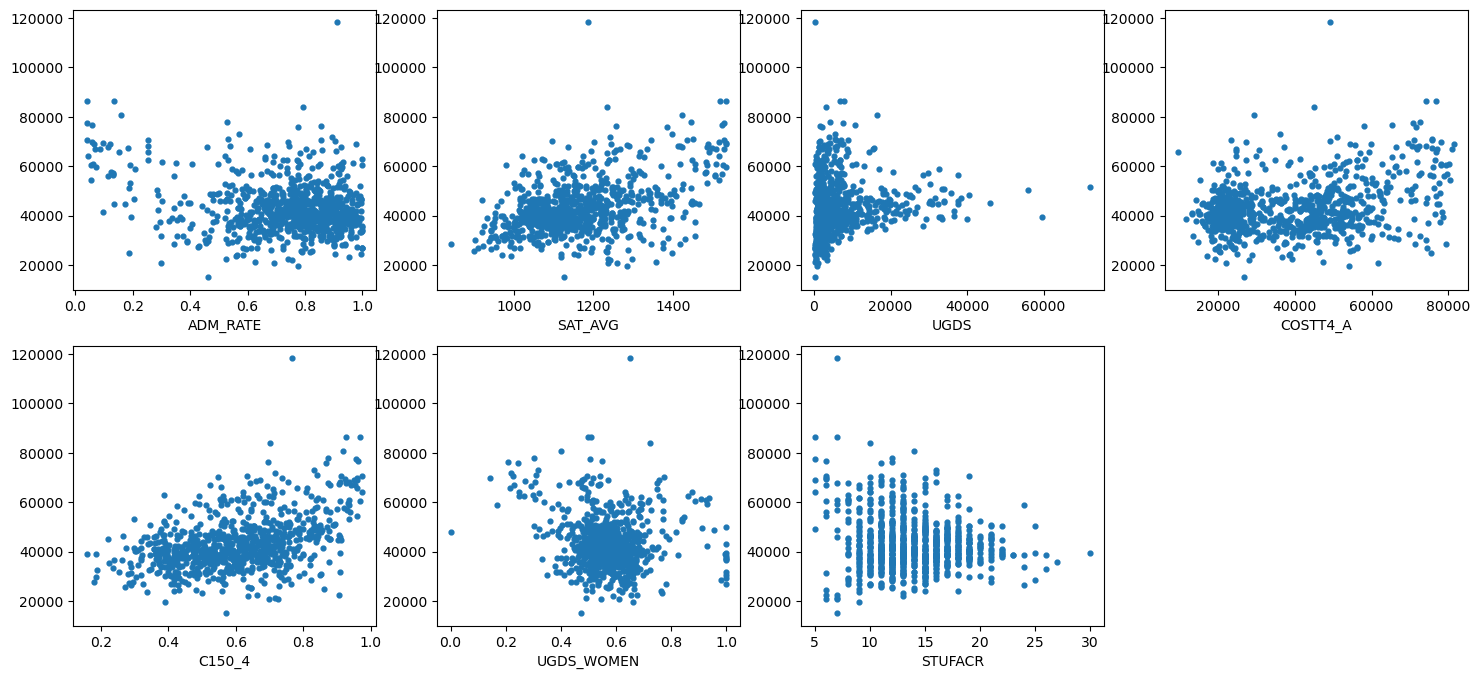

In [52]:
# Colmun title to be excluded
rm_lst = ["MD_EARN_WNE_1YR", "STATE"]
# Use list comprehension to make a list for colmun title to be examined
col_title = [el for el in list(regr_df.columns) if el not in rm_lst]
# Plot Median Income vs Other variables
plt.figure(figsize=(18,8))
for idx, feature in enumerate(col_title):
    plt.subplot(2, 4, idx+1)
    plt.scatter(regr_df[feature], regr_df["MD_EARN_WNE_1YR"], s=12)
    plt.xlabel(feature)

From these graphs, we can see that we may actually want to scale and standardise the features.  
Also, 120k stands out in every graph.  
It is a very influencial point indeed.  

----
Now, we fit the model using the data we have.  
This time, it will be done via stats model package from scipy.  
Let's begin with a simple model:
$$
\text{MD_EARN_WNE_1YR} = \beta_0 + \beta_1 \text{ADM_RATE} + \beta_2 \text{SAT_AVG} + 
\beta_3 \text{(UGDS)}  + \beta_4 \text{COSTT4_A} + \beta_5 \text{C150_4} + \beta_6 \text{UGDS_WOMEN} + \beta_7 \text{STUFACR} + \epsilon
$$


In [53]:
# Extract the X features and y features
X_raw = regr_df[col_title].copy(deep=True)
y_raw = regr_df["MD_EARN_WNE_1YR"]

In [54]:
# Add cosntant of 1, to make beta 0 
X_raw_const = sm.add_constant(X_raw)
# Craete model object with data using Odinary Least Squares
raw_model = sm.OLS(y_raw, X_raw_const)
# Call a fit onto the model
raw_results = raw_model.fit()
# Display the result of the fit
raw_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     35.77
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           6.92e-44
Time:                        22:29:00   Log-Likelihood:                -8989.4
No. Observations:                 851   AIC:                         1.799e+04
Df Residuals:                     843   BIC:                         1.803e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.44e+04   6241.833      3.908      0.000    1.21e+04    3.66e+04
ADM_RATE     190.1183   1945.929      0.098      0.922   -3629.316    4009.553
SAT_AVG       15.8144      5.303      2.982      0.003       5.405      26.224
UGDS           0.0837      0.055      1.521      0.129      -0.024       0.192
COSTT4_A       0.0490      0.030      1.654      0.098      -0.009       0.107
C150_4      1.204e+04   3852.555      3.125      0.002    4477.105    1.96e+04
UGDS_WOMEN -1.114e+04   2902.217     -3.837      0.000   -1.68e+04   -5438.779
STUFACR     -217.0074    121.077     -1.792      0.073    -454.656      20.641
==============================================================================
Omnibus:                      182.328   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              929.734
Skew:                           0.877   Prob(JB):                    1.29e-202
Kurtosis:                       7.811   Cond. No.                     8.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Overall, the adjusted R sqaured is 0.299.  
This seem to suggest a weak linear correlation for all the datapoints.  
The probabbility for f statistics is low, at close to 0.  
This tells us that there is definately an improvement compared to our naive model of 
$
\text{y}_{pred} = \beta_0 + \epsilon = \bar{y}
$.

Then, we look at the $\beta$ or the features used in modelling.   
The p value for `ADM_RATE` is very large.   
This may mean that it is not siginificant or important in our modelling.  
The other features that have p > 0.05 are:    
`UGDS`, `COSTT4_A` and `STUFACR`.   
They have p value of 0.129, 0.098 and 0.073 respectively.  

There are many issues with this model.  
The scale of the features are very different, leading to unstable model.  
Some features are better off transformed, such as log.   
There could be multicolinearity.  

BUT, the good thing abouut this model is that it can be very explainable.  
Every feature adds to the predicted value of income following the equation listed at the start, scaling based on their respective $\beta$.  
This also give some insights to the strength of how each feature affects the final outcome income value.  

----
To confirm the model is better than a random, guess, we calculate the Root Mean Square Prediction Error. (Remeber to differenctiate from Root Mean Sqaured Percentage Error)      
The equation is given by:  
$$ 
  \text{RMSPE} = \sqrt{\frac{1}{n}\sum_{i=1}^n (\hat{y}_{-i} - y_i)^2}
$$


In [55]:
def check_rmse_with_naive(ols_res, y_raw):
    """Check the difference between fitted model and naive model, only applicable to scipy OLS.
    Args:
        ols_res: OLS result object
        y_raw: actual y values, takes in pandas series
    Returns:
        rmse: rmse of fitted object
        rmse_naive: standard deviation of actual y values
    """
    # Get the influence data for outlier analysis etc
    results_inf = ols_res.get_influence()
    # Find RMSE for fitted model
    rmse = np.sqrt((results_inf.resid_press**2).mean())
    print(f"The root mean squared predicted error is {rmse:.3f}")
    # Find RMSE for naive model
    rmse_naive = y_raw.std()
    print(f"The naive model have rmse of {rmse_naive:.3f}")
    print(f"The improvement is {(rmse_naive-rmse):.3f}")
    return rmse, rmse_naive

In [56]:
raw_rmse, raw_rmse_naive = check_rmse_with_naive(raw_results, y_raw)

The root mean squared predicted error is 9473.407
The naive model have rmse of 10667.843
The improvement is 1194.436


This confirms that our model is an improvement from baseline or naive model, since the RMSE decreased by 1.1k.  
This decrease is not much.  
----

In [57]:
# Extract the influence for outlier analysis
raw_results_inf = raw_results.get_influence()
# Find the studentized residuals
raw_star = raw_results_inf.get_resid_studentized_external()

Studentized residuals, also known as standardized residuals or internally studentized residuals, are a measure used in regression analysis to assess the goodness of fit and detect outliers in a regression model. They are the residuals (the differences between the observed values and the predicted values) divided by their estimated standard error. In other words, studentized residuals are a measure of how many standard errors an observed data point is away from the predicted value.

The formula for studentized residuals is:

$$
\text{Studentized Residual} = \frac{\text{Residual}}{\text{Estimated Standard Error of Residual}}
$$
It is useful for model assessment, outlier detection and examine modelfit.  
In best case secenario, it should be normally distributed.  

In [58]:
def check_normality(data_to_check):
    """Creates a panel of three plots for checking Normality.
    Args:
        data_to_check: 1d array like of real numbers.
    Returns:
        The output is a plot figure with three subplots 
            - a boxplot, a histogram and probplot/ qq-plot.
    """
    plt.figure(1, figsize=(16, 4))
    # Plot the box plot
    plt.subplot(131)
    sns.boxplot(data=data_to_check)
    # Plot histogram with KDE
    plt.subplot(132)
    sns.histplot(data=data_to_check, kde=True)
    # Plot probplot, acting as qq plot
    plt.subplot(133)
    stats.probplot(data_to_check, plot=plt);

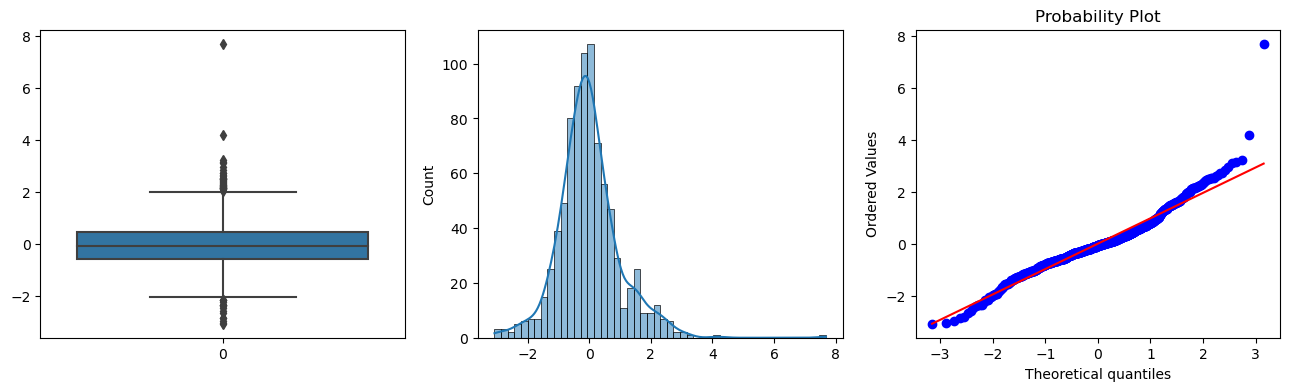

In [59]:
check_normality(raw_star)

We can see that there is 1 single eyesore, likely the school with extremely high income after graduation.  

Generate a graph that is a scatter plot that visually compares the actual values (y_raw) to the predicted values (y_predicted) produced by a regression model.    

In the plot:  
The blue points represent the actual data points, where each point corresponds to a pair of actual and predicted values.   
The red dashed line represents the ideal scenario where the predicted values perfectly match the actual values (y = x). (This line is labeled "Predicted = Actual.")   

Overall, the graph helps you visually assess the model's performance and see how closely the predicted values align with the actual values.   
If the points closely follow the red dashed line, it indicates a good model fit, and the R-squared values help quantify the goodness of fit.

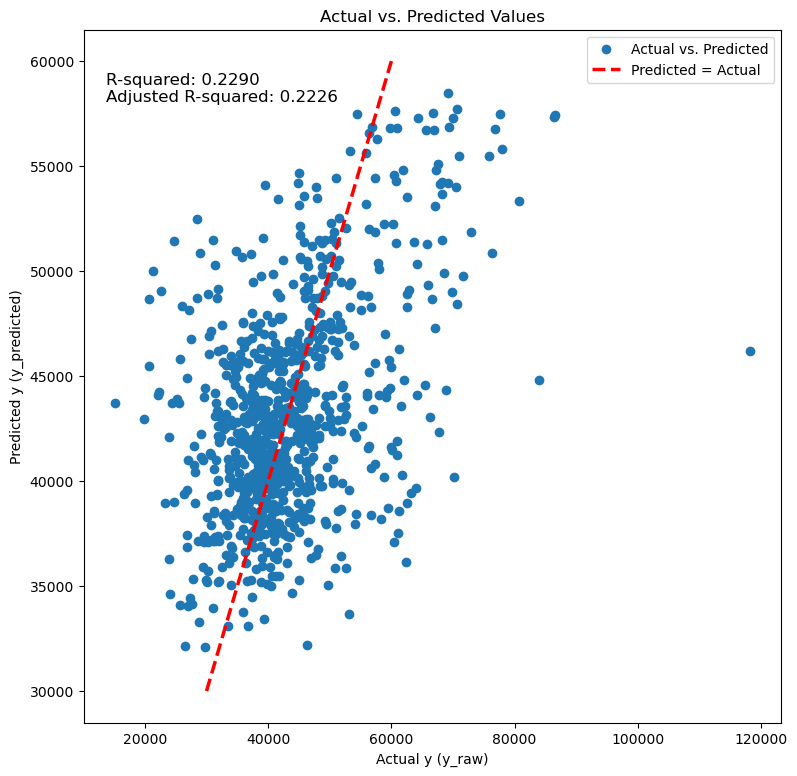

In [60]:
# Look at how the predicted values deviates from the actual values
# Initialize layout
fig, ax = plt.subplots(figsize=(9, 9))

# Get the predicted values from the fitted model
y_pred = raw_results.predict()

# Create a scatter plot of y_predicted vs. y_raw
plt.scatter(y_raw, y_pred, label="Actual vs. Predicted")

# Set the range of the red dash line
min_y = 30000
max_y = 60000

# Set a and b such that the line represents y = x
a = 0  # Intercept
b = 1  # Slope

# Create a sequence of x values based on the range of y_raw
xseq = np.linspace(min_y, max_y, num=100)

# Plot the line y = x
ax.plot(xseq, a + b * xseq, color="r", lw=2.5, linestyle='dashed', label="Predicted = Actual")

# Calculate R-squared and adjusted R-squared
r_squared = raw_results.rsquared
adj_r_squared = raw_results.rsquared_adj

# Add R-squared and adjusted R-squared to the plot
textstr = f"R-squared: {r_squared:.4f}\nAdjusted R-squared: {adj_r_squared:.4f}"
plt.gcf().text(0.15, 0.80, textstr, fontsize=12)

plt.xlabel("Actual y (y_raw)")
plt.ylabel("Predicted y (y_predicted)")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

We can see that there are a lot of outliers.  
The trend only shows a general direction and both r quared values indicates a loosely fitted line.  

Next, we visualise the residuals against each feature and also look at the residual plot itself.  

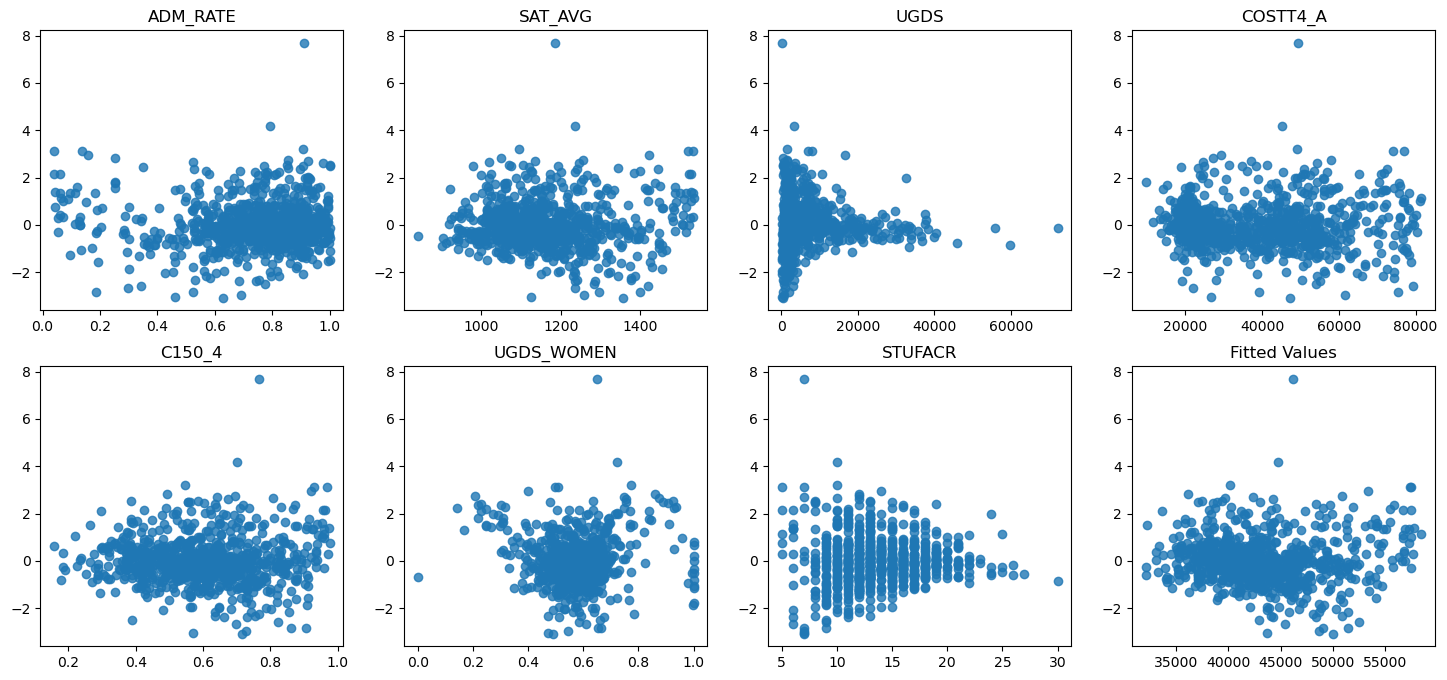

In [61]:
# Create canvas and order for the plots
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(18,8))
# Make the plots std of residuals against X_feature,i 
for i, cc in enumerate(X_raw_const.columns[1:]):
    plt.subplot(2,4, i+1)
    plt.scatter(X_raw_const[cc], raw_star, alpha=0.8)
    plt.title(cc)
# Make residual plot
plt.subplot(2,4,8)
plt.scatter(raw_results.fittedvalues, raw_star, alpha=0.8)
plt.title('Fitted Values');

From here, we can see residual plot and make a few comments.   
ADM_RATE residual plot seems okay, might be a bit skewed due to the data.   
SAT_AVG is okay, residuals are slightly fanned out, might consider log()it.    
UGDS is very skewed, need to do transformation on data.  
COSTT4_A is very random and evenly spread. 
C150_4 shows fanning, power scale.  
UGDS_WOMEN seems fine, but its a single cluster.  
STUFACR may need to transform it, standard scaler.  
Residual plot looks messy/normal enough, have 1 apparent most influencial point.  
----

Now, take a look at the differences in beta coefficient values and Cook's distance.  
Identify the very  influential point.  
solate this point.    

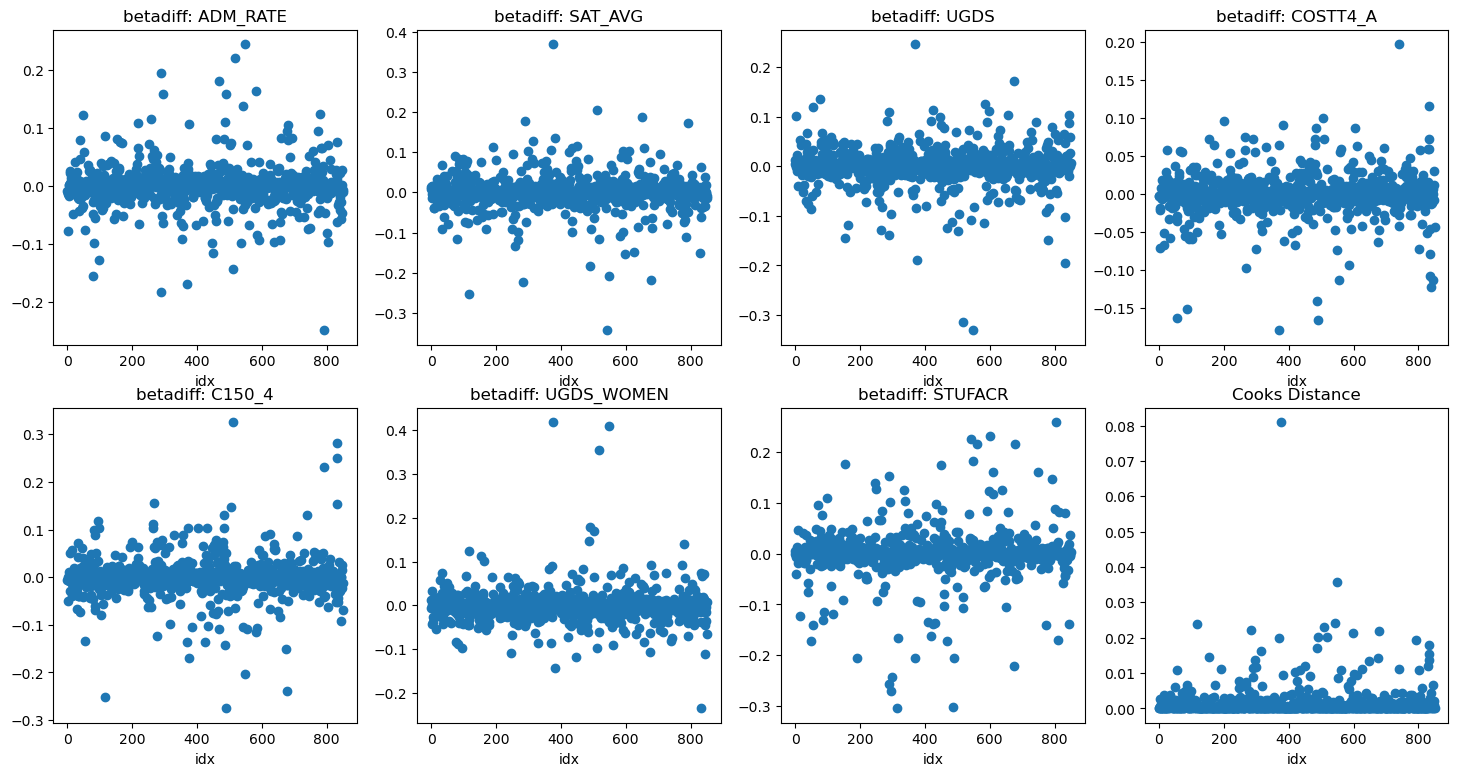

In [62]:
# Create canvas and order for the plots
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(18,9))
for idx, col in enumerate(col_title):
    plt.subplot(2,4,idx+1)
    plt.scatter(np.arange(851), raw_results_inf.dfbetas[:, idx]);plt.title(f'betadiff: {col}');plt.xlabel('idx');
# Make cook's distance plot
plt.subplot(2,4,8)
plt.scatter(np.arange(851), raw_results_inf.cooks_distance[0]);plt.title('Cooks Distance');plt.xlabel('idx');

From these plots, we can see that the influencial point changes depending on the feature.  
Additioanlly, the plots above show the most influencial point is not the same across all features.  
This is bad news for us.  
The point with index close to 400 is the most influential for quite a few features.  
I will still name this the most influencial point.  

In [63]:
# Find the most influencial point
np.where(raw_results_inf.cooks_distance[0]>0.07)

(array([375]),)

In [64]:
# Show the daya of the influencial point
regr_df.loc[[375]]

ADM_RATE  SAT_AVG   UGDS  COSTT4_A  C150_4  UGDS_WOMEN  STUFACR  \
375    0.9108   1185.0  254.0   49252.0   0.766      0.6496      7.0   

     MD_EARN_WNE_1YR     STATE  
375         118133.0  Missouri

## VIF and Multicollinearity
The Variance Inflation Factor (VIF) is a statistical measure used to assess the degree of multicollinearity in a multiple regression analysis.   
Multicollinearity is a phenomenon in which two or more independent variables in a regression model are highly correlated with each other.   
This can cause problems in regression analysis, such as instability of coefficient estimates and difficulty in interpreting the individual contributions of the correlated variables to the dependent variable.  
The VIF is used to quantify the extent to which the variance of the estimated regression coefficients is inflated due to multicollinearity.   
It measures how much the variance of a particular coefficient is increased by including other independent variables in the model.  

The relationship between the VIF, Pearson's correlation coefficient (Pearson's R), and correlation is as follows:

VIF and Pearson's Correlation (Pearson's R):   
VIF is related to Pearson's correlation in the sense that it quantifies how much a particular variable is correlated with a combination of other variables in the regression model.   
If two or more independent variables in the model are highly correlated (i.e., have a high Pearson's correlation coefficient), this will result in higher VIF values for each of those variables.   
High VIF values indicate that the correlation between the variable of interest and the other predictors is strong, which can be a sign of multicollinearity.

VIF and Correlation:   
While VIF measures the impact of multicollinearity on the variance of the estimated regression coefficients, correlation measures the strength and direction of the linear relationship between two variables.    
High correlation between independent variables can lead to multicollinearity, which, in turn, results in elevated VIF values.    
However, VIF explicitly quantifies the impact of multicollinearity on the regression model, while correlation only describes the degree of linear association between two variables.

Variance Inflation Factor (VIF) is a tool for identifying and quantifying multicollinearity in multiple regression models.    
It is related to Pearson's correlation coefficient and correlation in the sense that high correlations between independent variables can lead to high VIF values, but VIF specifically addresses the multicollinearity issue by measuring the inflation in the variance of regression coefficients.
----

First, we visualise how the features and target are correlated in a pair wise manner.  

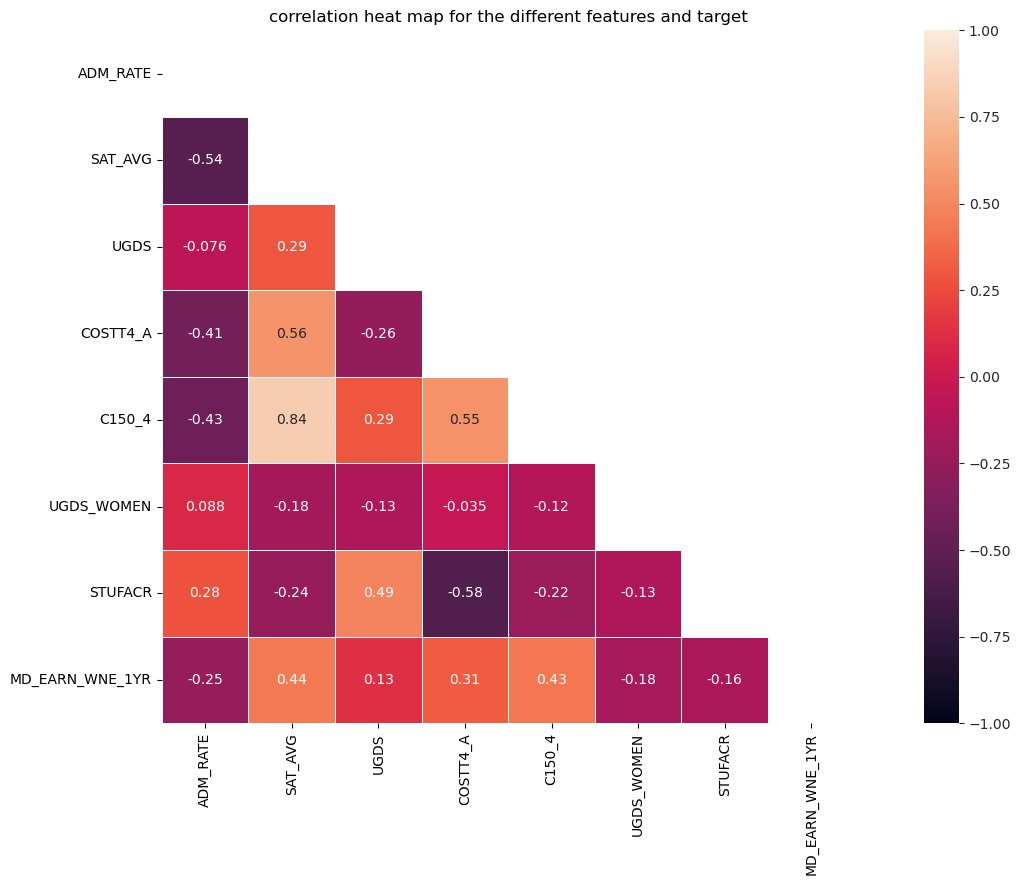

In [65]:
# Find the correlation of the features in a graphical way
plt.figure(figsize = (18,9))
plt.title("correlation heat map for the different features and target")
# Get correlation of variables.
corr = regr_df.corr(numeric_only=True)
# Set up mask to be “True” in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5)

Very interesting finding here.  
The correlation between 2 features are not too strong, with only SAT_AVG vs C150_4 at 0.84.  
This high SAT_AVG and C150_4 have the same trend, which makes sense.  
High SAT, smart, finish school on time.  
Some interesting pairs are:
SAT_AVG & ADM_RATE: Negatively correlated at -0.54. (High SAT but low Admission, maybe too many students applied)  
STUFACR & COSTT4_A: Negatively correlated at -0.58. (Higher cost but worse STUFACR?)   
SAT_AVG & COSTT4_A: Positively correlated at 0.56. (Good schools doesn't come cheap?)

Now, we look at the VIF for each feature.   

In [66]:
# Calculate the VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_raw_const.columns  # Include the constant term
vif_data["VIF"] = [oinf.variance_inflation_factor(X_raw_const.values, i) for i in range(X_raw_const.shape[1])]

In [67]:
vif_data

Feature         VIF
0       const  374.774286
1    ADM_RATE    1.480361
2     SAT_AVG    4.403443
3        UGDS    1.987787
4    COSTT4_A    2.442871
5      C150_4    3.741533
6  UGDS_WOMEN    1.074511
7     STUFACR    1.966060

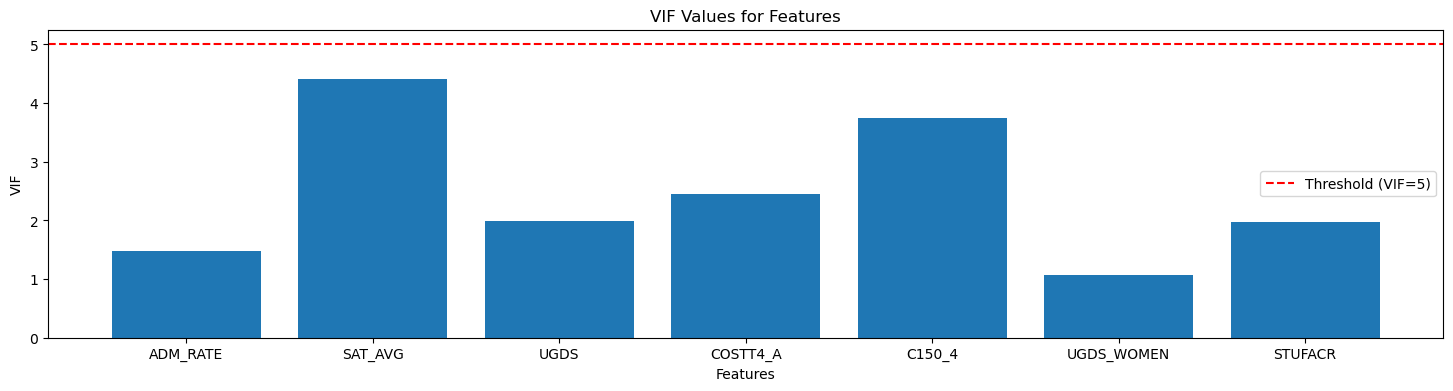

In [68]:
vif_data
# Plot the VIF into bar chart
plt.figure(figsize=(18,4))
plt.bar(col_title, vif_data['VIF'][1:], width=0.8)
# Add a single straight line at height 5
plt.axhline(y=5, color='red', linestyle='--', label="Threshold (VIF=5)")

# Add labels and title
plt.xlabel("Features")
plt.ylabel("VIF")
plt.title("VIF Values for Features")
plt.legend()
plt.show()

I don't need to consider the Variance Inflation Factor (VIF) for constant in a regression model because it's not a features.  
It's a fixed value of 1, constant just exist (intercept).    
The VIF measures the multicollinearity between features, and since the constant term isn't a predictor (feature), it doesn't have a VIF value.

The VIF values for the features in the regression model indicate minimal multicollinearity.   
With VIF values below 5, the features exhibit low correlation, and each independently contributes to explaining the income of student after graduation.
----

## Q2 Part 1 Summary

The regression model's R-squared (0.229) suggests it explains 22.9% of variance.   
While adjusted R-squared (0.223) is relatively low, the significant F-statistic (p < 0.001) affirms the model's statistical importance (at being better than navie model).
The model showed decrease in Root Mean Square Predicted Error, from 10.6k of baseline model to 9.6k of the new regression model.  
The constant (intercept) term in the regression model is approximately 24,000.

Among the independent variables:
`ADM_RATE` has a coefficient of approximately 190.12, but it is not statistically significant (p > 0.05), indicating that it may not have a strong influence on the dependent variable.
`SAT_AVG` has a coefficient of approximately 15.81 and is statistically significant (p < 0.05). A one-unit increase in SAT_AVG is associated with an increase of approximately 15.81 units in the dependent variable.
`UGDS`, `COSTT4_A`, and `STUFACR` have coefficients of 0.08, 0.05, and -217.01, respectively. These coefficients are not statistically significant, suggesting that these variables may not be strong predictors of the dependent variable.
`C150_4` has a coefficient of approximately 12,038.83 and is statistically significant (p < 0.05). A one-unit increase in C150_4 is associated with an increase of approximately 12,038.83 units in the dependent variable.
`UGDS_WOMEN` has a coefficient of approximately -11,140. A one-unit increase in UGDS_WOMEN is associated with a decrease of approximately 11,140 units in the dependent variable. This variable is statistically significant.
Among individual coefficients, `SAT_AVG` and `C150_4` are statistically significant.   
Non-significant variables like `ADM_RATE` and `STUFACR` may not contribute meaningfully and could be considered for removal.

Most influential point is found at index 375. The school ~I want to atttend~ with Salary of about 120k upon graduation. This point can be considered for removal.  

Despite some possible pair wise correlation, the VIF indictaes that the features exhibits low multicollinearity.   

Some issues found:  
Rasidual plot for some features, `SAT_AVG`, `UGDS`, `COSTT4_A`, and `C150_4` seems tobe skewed, or requires standardisation.     
This means that we need to apply log transformation or standard scaler.   
Overall, there is randomness in the data itself.  
The resultant model can only provide a general trend.  
Currently, the model is simple.   
There is high bias, low variance in the model.  
We might want to introduce more model complexity to reduce the bias, in order to achieve a good bias variance trade off.  

Something we can do:  
Remove most influencial point. (Perform "leave one out" validation during model training)  
Apply standard scaler and also power transformation to model.  
Drop some features when modelling. (Perform feature selection)  
Add `STATE` into consideration.  
Perform k fold cross validation.  
Apply lasso, ridge and elastic net to make some coefficients 0 or close to zero. 
Apply Grid Search CV to find the hyperparameters during parameter tunning.  
Apply combined models, somewhat like Ensemble Learning.  
Apply more advanced algorithms that tends to have high variance, low bias, like XGBoost, LGBM, Random Forest etc.  
----

## Q2 Part 2
Here are a couple of comments from your boss when you show him/her the analysis:  

"Have you tried standardising the variables ADM_RATE, SAT_AVG, UGDS, COSTT4_A, C150_4, UGDS_WOMEN and STUFACR?"   
"Have you tried adding STATE to your explanatory variables?"  
Address his/her questions and other concerns you may have from part 1. You may remove the most influential point if it exists. Recommend a final regression model.
----
What we can do:
1. Do some more data analysis. One thing I do realise about this dataset is how spread out the data points are. This means that we are not likely to get a very good fit anyway.   
2. Apply standard scaler and log transform some of the features.    
3. Drop the influential point, point with index 375, earning meadian of close to 120k USD upon graduation.  
4. Examine if this makes the model better.   
5. Apply one hot encoding to include the `States` in our modelling. Also, remove some features if they are not significant.   
6. Examine the performance of this model.   
7. Apply lasso/ ridge/ elastic net with cross validation to get a final model.  

----
Let us do the transformation and standardisation 1st.  
Split the dataset as categorical and numerical sets.   
This is a very basic and simple preprocessing, where the categorical features will go through One Hot Encoding, numerical features will go through Standard Scaler.  
To do so quickly, let us employ help from sklearn packages.  

In [69]:
# Split data into numerical and cetegorical
categorical_col = ["STATE"]
numerical_col = col_title

In [70]:
# y_raw is still the y to predict. No change there.  
# Apply standard scaler on numerical colmuns
# Make a pipeline to apply standard scaler on selected features
simple_numeric_transformer = Pipeline(
    steps=[
        ("ss", StandardScaler())
    ]
)

In [71]:
# Make a pipeline to apply one hot encoding on selected features
# Drop 'first' to remove exact linear dependence
categorical_transformer = Pipeline(
    steps=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", drop='first')),
    ]
)

In [72]:
# the above 2 steps forms the colmun transformer, which is used for the preprocessing step.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", simple_numeric_transformer, numerical_col),
        ("cat", categorical_transformer, ["STATE"]),
    ]
)

In [73]:
# Make OLSRegressor from scipy
class OLSRegressor(BaseEstimator, RegressorMixin):
    """Self implemented OLSRegressor akin to LinearRegressor from sklearn
    """
    def __init__(self, add_constant=True):
        self.add_constant = add_constant
        self.model = None

    def fit(self, X, y):
        if issparse(X):
            X = X.toarray()  # Convert sparse matrix to a dense array
        if self.add_constant:
            X = sm.add_constant(X)
        self.model = sm.OLS(y, X).fit()
        return self

    def predict(self, X):
        if issparse(X):
            X = X.toarray()  # Convert sparse matrix to a dense array
        if self.add_constant:
            X = sm.add_constant(X)
        return self.model.predict(X)
    
    def get_summary(self):
        return self.model.summary()
    
    def get_influ(self):
        return self.model.get_influence()
    
    def get_res_stu_e(self):
        return self.model.get_influence().get_resid_studentized_external()

In [74]:
# Scipy OLS model to do linear regression
# Build a pipeline for regression model
ols_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", OLSRegressor())
    ]
)

Then, prepare the data used for training and testing of model.  
Drop the most influential point, index at 375.  

In [75]:
regr_df_wo_375 = regr_df.drop(index=375).reset_index(drop=True)

In [76]:
X = regr_df_wo_375.drop(columns="MD_EARN_WNE_1YR")
X.head()

ADM_RATE  SAT_AVG     UGDS  COSTT4_A  C150_4  UGDS_WOMEN  STUFACR    STATE
0    0.7160    954.0   5098.0   21924.0  0.2807      0.5940     18.0  Alabama
1    0.8854   1266.0  13284.0   26248.0  0.6245      0.6210     19.0  Alabama
2    0.7367   1300.0   7358.0   24869.0  0.6072      0.4047     19.0  Alabama
3    0.9799    955.0   3495.0   21938.0  0.2843      0.6495     13.0  Alabama
4    0.7890   1244.0  30725.0   31050.0  0.7223      0.5615     19.0  Alabama

In [77]:
y = regr_df_wo_375["MD_EARN_WNE_1YR"]
y.head()

0    30999.0
1    45270.0
2    57386.0
3    27282.0
4    44620.0
Name: MD_EARN_WNE_1YR, dtype: float64

In [78]:
ols_reg.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['ADM_RATE', 'SAT_AVG',
                                                   'UGDS', 'COSTT4_A', 'C150_4',
                                                   'UGDS_WOMEN', 'STUFACR']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['STATE'])])),
                ('regressor', OLSRegressor())])

In [79]:
# Scipy OLS model to do linear regression
# Build a pipeline for regression model
lin_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ]
)

In [80]:
lin_reg.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['ADM_RATE', 'SAT_AVG',
                                                   'UGDS', 'COSTT4_A', 'C150_4',
                                                   'UGDS_WOMEN', 'STUFACR']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['STATE'])])),
                ('regressor', LinearRegression())])

I am fitting a sklearn LinearRegression() just to see how it compares with scipy's OLS.  

In [81]:
print(f"The score of using linear regression is: {round(lin_reg.score(X, y), 6)}")
print(f"The score of using scipy ols regression is: {round(ols_reg.score(X, y), 6)}")

The score of using linear regression is: 0.321738
The score of using scipy ols regression is: 0.321738


They are more or less the same thing!  
But sklearn's implementation can't call .summary() method.  

In [82]:
import sklearn
import warnings
# This function is obtained from internet source, I have troubleshooted, for hours, and modified it to work on my code:
# https://johaupt.github.io/blog/columnTransformer_feature_names.html
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '_len_') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names_out'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "_" + f for f in column]

        return [name + "_" + f for f in trans.get_feature_names_out()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "_" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [83]:
feature_name = ['cosnt']
feature_name.extend(get_feature_names(preprocessor))

In [84]:
# Get the summary with correct feature name
def summary_with_right_name(summary_obj, feature_name):
    """Show the summary with the correct feature name
    """
    # Save the 2nd table of summary as dataframe, and change to dataframe
    feature_df = pd.DataFrame.from_records(summary_obj.tables[1].data[1:], columns=['feature', 'coef', 'std err', 't', 'P>|t|', '[0.025', '0.975]'])
    feature_df['feature'] = feature_name
    display(summary_obj.tables[0])
    display(feature_df)
    display(summary_obj.tables[2])

In [85]:
# Get the summary
summary_obj = ols_reg.named_steps['regressor'].get_summary()
summary_with_right_name(summary_obj, feature_name)

<class 'statsmodels.iolib.table.SimpleTable'>

feature        coef    std err          t   P>|t|  \
0                            cosnt   4.396e+04   2382.673     18.448   0.000   
1                      ss_ADM_RATE   -576.9020    392.102     -1.471   0.142   
2                       ss_SAT_AVG   2359.4237    675.021      3.495   0.000   
3                          ss_UGDS    718.0686    443.988      1.617   0.106   
4                      ss_COSTT4_A    599.4859    510.630      1.174   0.241   
5                        ss_C150_4   1279.0081    638.505      2.003   0.046   
6                    ss_UGDS_WOMEN  -1122.3227    331.362     -3.387   0.001   
7                       ss_STUFACR   -689.6647    453.675     -1.520   0.129   
8                 ohe_STATE_Alaska   4736.6515   9175.357      0.516   0.606   
9                ohe_STATE_Arizona   4188.7027   6727.130      0.623   0.534   
10              ohe_STATE_Arkansas  -6024.7839   3566.270     -1.689   0.092   
11            ohe_STATE_California  -2097.6262   2996.155     -0.700   0.484   
12              ohe_STATE_Colorado    758.2978   3416.451      0.222   0.824   
13           ohe_STATE_Connecticut   2652.1294   3384.140      0.784   0.433   
14              ohe_STATE_Delaware   1113.6270   9181.989      0.121   0.903   
15  ohe_STATE_District of Columbia    437.1388   4657.791      0.094   0.925   
16               ohe_STATE_Florida  -3470.7704   2889.965     -1.201   0.230   
17               ohe_STATE_Georgia  -1275.9407   2912.907     -0.438   0.661   
18                ohe_STATE_Hawaii  -5629.7738   5620.380     -1.002   0.317   
19                 ohe_STATE_Idaho  -8288.5767   5635.686     -1.471   0.142   
20              ohe_STATE_Illinois    807.0839   2854.289      0.283   0.777   
21               ohe_STATE_Indiana    112.9798   2927.835      0.039   0.969   
22                  ohe_STATE_Iowa  -1965.0103   3276.390     -0.600   0.549   
23                ohe_STATE_Kansas   2035.0955   3594.624      0.566   0.571   
24              ohe_STATE_Kentucky  -1685.3484   3478.552     -0.484   0.628   
25             ohe_STATE_Louisiana  -1882.4082   3197.046     -0.589   0.556   
26                 ohe_STATE_Maine   2916.4892   5633.749      0.518   0.605   
27              ohe_STATE_Maryland  -2861.5120   3576.241     -0.800   0.424   
28         ohe_STATE_Massachusetts   1778.5029   2828.234      0.629   0.530   
29              ohe_STATE_Michigan   3128.5741   3050.661      1.026   0.305   
30             ohe_STATE_Minnesota    716.6729   3271.836      0.219   0.827   
31           ohe_STATE_Mississippi  -6229.1519   3347.834     -1.861   0.063   
32              ohe_STATE_Missouri  -1765.9996   2962.083     -0.596   0.551   
33               ohe_STATE_Montana   2161.9476   4329.224      0.499   0.618   
34              ohe_STATE_Nebraska  -1059.1195   3798.741     -0.279   0.780   
35                ohe_STATE_Nevada  -1999.4230   9155.151     -0.218   0.827   
36         ohe_STATE_New Hampshire   -840.4849   5660.109     -0.148   0.882   
37            ohe_STATE_New Jersey   1539.4650   3065.181      0.502   0.616   
38            ohe_STATE_New Mexico  -4944.4123   4634.514     -1.067   0.286   
39              ohe_STATE_New York   -604.1013   2657.933     -0.227   0.820   
40        ohe_STATE_North Carolina  -5786.9459   2855.245     -2.027   0.043   
41          ohe_STATE_North Dakota   4893.8529   4116.514      1.189   0.235   
42                  ohe_STATE_Ohio  -1271.4293   2791.959     -0.455   0.649   
43              ohe_STATE_Oklahoma   1786.8826   3287.286      0.544   0.587   
44                ohe_STATE_Oregon  -2875.5139   3585.757     -0.802   0.423   
45          ohe_STATE_Pennsylvania   3106.8250   2705.827      1.148   0.251   
46          ohe_STATE_Rhode Island  -4577.9268   4699.304     -0.974   0.330   
47        ohe_STATE_South Carolina  -7548.7755   3161.750     -2.388   0.017   
48          ohe_STATE_South Dakota   4531.1071   3679.916      1.231   0.219   
49             ohe_STATE_Te

<class 'statsmodels.iolib.table.SimpleTable'>

 Although we can see a performance improve from removal of the most influential point, the result is still not very good.  
The R squared improved from 0.229 in the original model to 0.322 in the new model.  
The adjusted R squared also increase from 0.223 to 0.279.  

In [86]:
ohe_inf_pipe = ols_reg.named_steps['regressor'].get_influ()
ohe_resi_pipe = ols_reg.named_steps['regressor'].get_res_stu_e()

/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


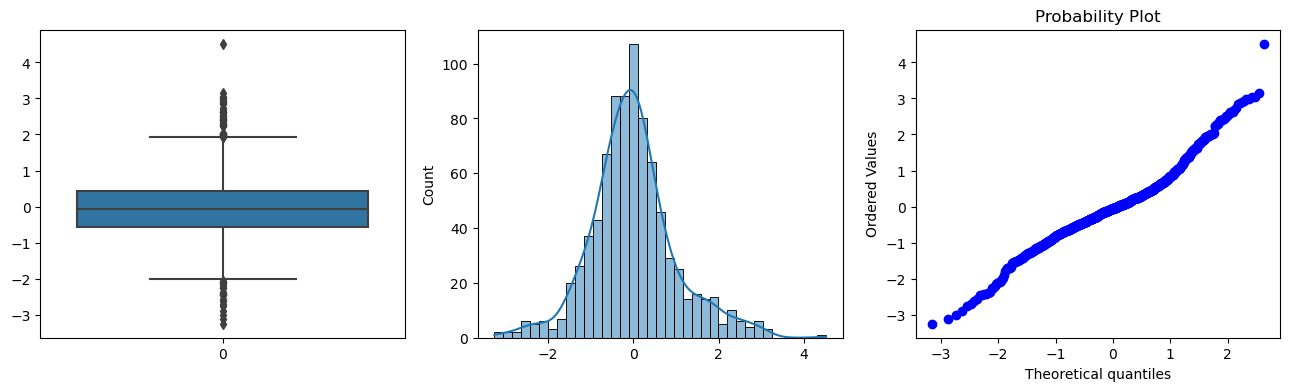

In [87]:
check_normality(ohe_resi_pipe)

In [88]:
check_rmse_with_naive(ols_reg.named_steps['regressor'].model, y);

The root mean squared predicted error is 9176.551
The naive model have rmse of 10359.325
The improvement is 1182.774


Note that by removing the most influential point, the RMSPE for naive model decreased from 10667 to 10359.  
The RMSPE also decreased from 9473 to 9176.   
There seem to be less of a decrease in RMSPE from using `STATE` compred to removing the the most influential point...  
This is becasue niave model's RSMPE drop by about 308.  
Model's RMSPE only dropped by 297.  
Does this mean that using `STATE` did not really help?  
The p value for undergard, cost and admission are still relatively high after applying standard scaler.  
This made me question the necessity of adding `STATE`.

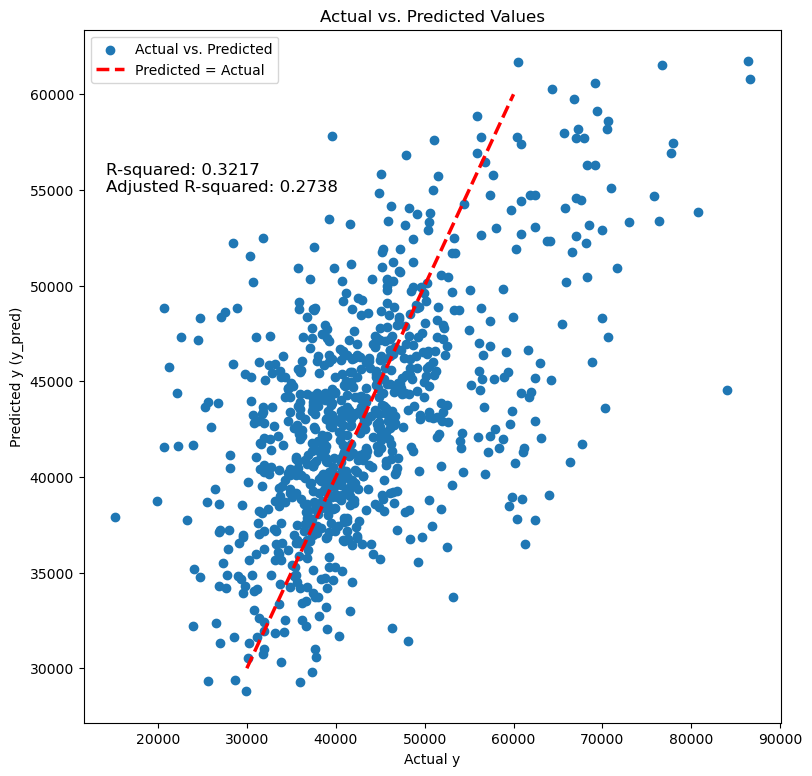

In [89]:
# Look at how the predicted values deviates from the actual values
# Initialize layout
fig, ax = plt.subplots(figsize=(9, 9))

# Get the predicted values from the fitted model
y_pred = ols_reg.named_steps['regressor'].model.predict()

# Create a scatter plot of y_predicted vs. y_raw
plt.scatter(y, y_pred, label="Actual vs. Predicted")

# Set the range of the red dash line
min_y = 30000
max_y = 60000

# Set a and b such that the line represents y = x
a = 0  # Intercept
b = 1  # Slope

# Create a sequence of x values based on the range of y_raw
xseq = np.linspace(min_y, max_y, num=100)

# Plot the line y = x
ax.plot(xseq, a + b * xseq, color="r", lw=2.5, linestyle='dashed', label="Predicted = Actual")

# Calculate R-squared and adjusted R-squared
r_squared = ols_reg.named_steps['regressor'].model.rsquared
adj_r_squared =ols_reg.named_steps['regressor'].model.rsquared_adj

# Add R-squared and adjusted R-squared to the plot
textstr = f"R-squared: {r_squared:.4f}\nAdjusted R-squared: {adj_r_squared:.4f}"
plt.gcf().text(0.15, 0.70, textstr, fontsize=12)

plt.xlabel("Actual y")
plt.ylabel("Predicted y (y_pred)")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

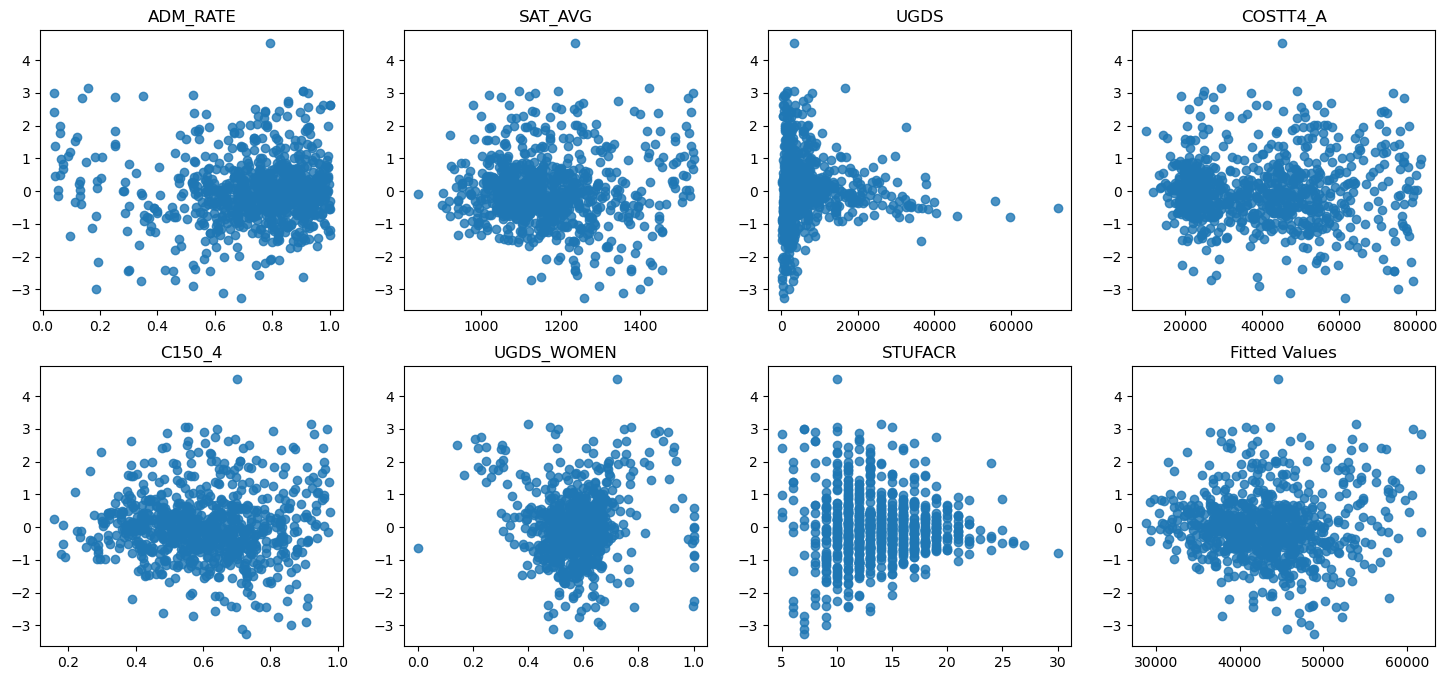

In [90]:
# Create canvas and order for the plots
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(18,8))
# Make the plots std of residuals against X_feature,i 
for i, cc in enumerate(X.columns[:7]):
    plt.subplot(2,4, i+1)
    plt.scatter(X[cc], ohe_resi_pipe, alpha=0.8)
    plt.title(cc)
# Make residual plot
plt.subplot(2,4,8)
plt.scatter(ols_reg.named_steps['regressor'].model.fittedvalues, ohe_resi_pipe, alpha=0.8)
plt.title('Fitted Values');

/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


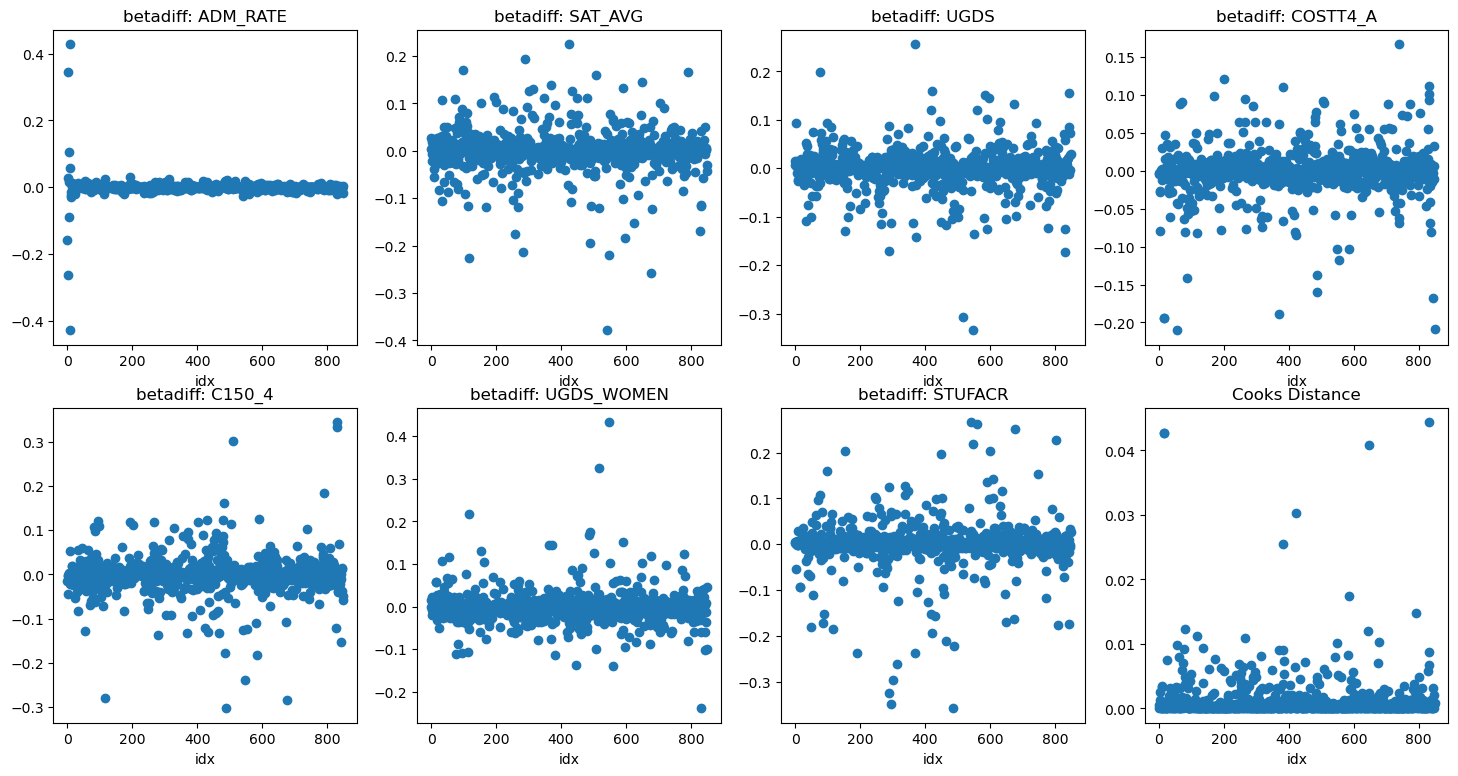

In [91]:
# Create canvas and order for the plots
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(18,9))
for idx, col in enumerate(col_title):
    plt.subplot(2,4,idx+1)
    plt.scatter(np.arange(850), ols_reg.named_steps['regressor'].model.get_influence().dfbetas[:, idx]);plt.title(f'betadiff: {col}');plt.xlabel('idx');
# Make cook's distance plot
plt.subplot(2,4,8)
plt.scatter(np.arange(850), ols_reg.named_steps['regressor'].model.get_influence().cooks_distance[0]);plt.title('Cooks Distance');plt.xlabel('idx');

----
This section examines the relationship of 'outliers' in some selected `STATE`.  
Here, I look at what percentage of data is above or below a specified quantile.  
This is important as this will decide on how to split the data for modelling in the future.   

In [92]:
def find_percentage(df, target, grpby, quantile, tail='two'):
    '''find the percentage of data points in that quantile
    Args:
        df: dataframe to look at
        target: target that is used to calculate the quantiles on
        grpby: name of col which the categories are 1st grouped by
        quantile: the quantile too examine
        tail: default = 'two', else 'left' if find lower, 'right' if find higer
    Returns:
        df: dataframe with categories of col as row index and percentage of that category in the quantile
    '''
    # Filter the data based on the quantile and tail
    if tail == 'two':
        df_outliers = df[(df[target] >= df[target].quantile(q=quantile)) |
                         (df[target] <= df[target].quantile(q=1 - quantile))]
    elif tail == 'left':
        df_outliers = df[df[target] <= df[target].quantile(q=quantile)]
    elif tail == 'right':
        df_outliers = df[df[target] >= df[target].quantile(q=quantile)]

    # Calculate statistics for the groupby column
    group_stats = df.groupby(grpby)[target].agg(['count', 'mean'])

    # Calculate statistics for the filtered data
    outliers_stats = df_outliers.groupby(grpby)[target].agg(['count', 'mean'])

    # Calculate the percentage of data points in the quantile for each category
    percentage = (outliers_stats['count'] / group_stats['count'] * 100).round(2)

    return percentage

In [93]:
find_percentage(regr_df, "MD_EARN_WNE_1YR", grpby="STATE", quantile=0.875, tail="right")

STATE
Alabama                  7.14
Alaska                    NaN
Arizona                 50.00
Arkansas                  NaN
California              25.93
Colorado                15.38
Connecticut             21.43
Delaware                  NaN
District of Columbia    40.00
Florida                 16.67
Georgia                  7.41
Hawaii                    NaN
Idaho                     NaN
Illinois                15.15
Indiana                 10.71
Iowa                      NaN
Kansas                   9.09
Kentucky                  NaN
Louisiana                 NaN
Maine                     NaN
Maryland                  NaN
Massachusetts           27.03
Michigan                13.64
Minnesota                6.25
Mississippi               NaN
Missouri                19.23
Montana                 33.33
Nebraska                  NaN
Nevada                    NaN
New Hampshire           33.33
New Jersey              18.18
New Mexico              20.00
New York                22.22
Nort

The output is the result of running the `find_percentage` function, I am identifying data points in the top 12.5% (quantile=0.875) of "MD_EARN_WNE_1YR" for each state (grouped by "STATE"). Here's what this information tells us:

1. **Percentage of High Earnings:** The percentage values in the result indicate the proportion of institutions within each state that have "MD_EARN_WNE_1YR" values in the top 12.5% of the distribution for that state. In the context of this result, it corresponds to identifying percentage of school in `STATE` whose "MD_EARN_WNE_1YR" values are more than 3 times the interquartile range (IQR) above the third quartile (Q3). This is a relatively conservative approach and can identify institutions with exceptionally high earnings.

2. **Variation Across States:** The results show considerable variation across different states. Some states have a relatively high percentage of institutions with graduates earning high incomes, while others have a lower percentage. This can mean some states pay lesser, uneven distribution of educational resources.  

3. **Policy and Research Implications:** States with a higher percentage of institutions in the upper 12.5% may want to explore the factors contributing to high graduate earnings and consider replicating successful practices. Conversely, states with lower percentages may seek to improve the economic outcomes of their graduates.

4. **Further Investigation:** The results provide a starting point for further investigation and analysis, potentially leading to insights into the relationships between educational institutions, their programs, and the income levels of their graduates. (Which will not be covered here)

This seems to tell us that adding `STATE` could still be of some help to us.   

-----

In [94]:
# This is the data frame with index 375, the school with 120k, remove.
# Similarly, y have the 120k removed too
X.head()

ADM_RATE  SAT_AVG     UGDS  COSTT4_A  C150_4  UGDS_WOMEN  STUFACR    STATE
0    0.7160    954.0   5098.0   21924.0  0.2807      0.5940     18.0  Alabama
1    0.8854   1266.0  13284.0   26248.0  0.6245      0.6210     19.0  Alabama
2    0.7367   1300.0   7358.0   24869.0  0.6072      0.4047     19.0  Alabama
3    0.9799    955.0   3495.0   21938.0  0.2843      0.6495     13.0  Alabama
4    0.7890   1244.0  30725.0   31050.0  0.7223      0.5615     19.0  Alabama

In [95]:
col_title

['ADM_RATE', 'SAT_AVG', 'UGDS', 'COSTT4_A', 'C150_4', 'UGDS_WOMEN', 'STUFACR']

In [96]:
# Scale the data first!
ss = StandardScaler()
X_ss = ss.fit_transform(X[col_title])
# Create a new dataframe with the scaled numerical columns
X_ss_df = pd.DataFrame(X_ss, columns=col_title)
# Concatenate the scaled numerical dataframe with the categorical dataframe
X_ss_df["state"] = X["STATE"]
# Show the final df
X_ss_df.head()

ADM_RATE   SAT_AVG      UGDS  COSTT4_A    C150_4  UGDS_WOMEN   STUFACR  \
0 -0.101921 -1.641878 -0.127113 -1.004807 -1.978721    0.154477  1.135805   
1  0.738244  0.802304  0.863442 -0.750555  0.145072    0.388851  1.403981   
2  0.000744  1.068657  0.146360 -0.831640  0.038203   -1.488744  1.403981   
3  1.206931 -1.634044 -0.321085 -1.003984 -1.956482    0.636246 -0.205076   
4  0.260134  0.629957  2.973906 -0.468196  0.749223   -0.127639  1.403981   

     state  
0  Alabama  
1  Alabama  
2  Alabama  
3  Alabama  
4  Alabama

In [97]:
# OHE the dataframe
X_ss_encoded_df = pd.get_dummies(X_ss_df, columns=["state"], drop_first=True)
X_ss_encoded_df.head()

ADM_RATE   SAT_AVG      UGDS  COSTT4_A    C150_4  UGDS_WOMEN   STUFACR  \
0 -0.101921 -1.641878 -0.127113 -1.004807 -1.978721    0.154477  1.135805   
1  0.738244  0.802304  0.863442 -0.750555  0.145072    0.388851  1.403981   
2  0.000744  1.068657  0.146360 -0.831640  0.038203   -1.488744  1.403981   
3  1.206931 -1.634044 -0.321085 -1.003984 -1.956482    0.636246 -0.205076   
4  0.260134  0.629957  2.973906 -0.468196  0.749223   -0.127639  1.403981   

   state_Alaska  state_Arizona  state_Arkansas  ...  state_South Carolina  \
0             0              0               0  ...                     0   
1             0              0               0  ...                     0   
2             0              0               0  ...                     0   
3             0              0               0  ...                     0   
4             0              0               0  ...                     0   

   state_South Dakota  state_Tennessee  state_Texas  state_Utah  \
0                   0                0            0           0   
1                   0                0            0           0   
2                   0                0            0           0   
3                   0                0            0           0   
4                   0                0            0           0   

   state_Vermont  state_Virginia  state_Washington  state_West Virginia  \
0              0               0                 0                    0   
1              0               0                 0                    0   
2              0               0                 0                    0   
3              0               0                 0                    0   
4              0               0                 0                    0   

   state_Wisconsin  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 56 columns]

In [98]:
# Defone fitting a model
# Function to perform linear regression and print summary
def fit_ols(X, y):
    X = sm.add_constant(X)  
    model = sm.OLS(y, X).fit()
    return model, X

In [99]:
model_ss_ohe, X_ss_encoded_df_const = fit_ols(X_ss_encoded_df, y)
model_ss_ohe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     6.717
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           2.75e-38
Time:                        22:29:26   Log-Likelihood:                -8899.4
No. Observations:                 850   AIC:                         1.791e+04
Df Residuals:                     793   BIC:                         1.818e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       4.396e+04   2382.673     18.448      0.000    3.93e+04    4.86e+04
ADM_RATE                    -576.9020    392.102     -1.471      0.142   -1346.582     192.778
SAT_AVG                     2359.4237    675.021      3.495      0.000    1034.384    3684.464
UGDS                         718.0686    443.988      1.617      0.106    -153.463    1589.600
COSTT4_A                     599.4859    510.630      1.174      0.241    -402.860    1601.832
C150_4                      1279.0081    638.505      2.003      0.046      25.649    2532.368
UGDS_WOMEN                 -1122.3227    331.362     -3.387      0.001   -1772.773    -471.872
STUFACR                     -689.6647    453.675     -1.520      0.129   -1580.211     200.881
state_Alaska                4736.6515   9175.357      0.516      0.606   -1.33e+04    2.27e+04
state_Arizona               4188.7027   6727.130      0.623      0.534   -9016.385    1.74e+04
state_Arkansas             -6024.7839   3566.270     -1.689      0.092    -1.3e+04     975.662
state_California           -2097.6262   2996.155     -0.700      0.484   -7978.958    3783.705
state_Colorado               758.2978   3416.451      0.222      0.824   -5948.060    7464.655
state_Connecticut           2652.1294   3384.140      0.784      0.433   -3990.801    9295.060
state_Delaware              1113.6270   9181.989      0.121      0.903   -1.69e+04    1.91e+04
state_District of Columbia   437.1388   4657.791      0.094      0.925   -8705.918    9580.196
state_Florida              -3470.7704   2889.965     -1.201      0.230   -9143.656    2202.115
state_Georgia              -1275.9407   2912.907     -0.438      0.661   -6993.861    4441.979
state_Hawaii               -5629.7738   5620.380     -1.002      0.317   -1.67e+04    5402.807
state_Idaho                -8288.5767   5635.686     -1.471      0.142   -1.94e+04    2774.050
state_Illinois               807.0839   2854.289      0.283      0.777   -4795.771    6409.939
state_Indiana                112.9798   2927.835      0.039      0.969   -5634.243    5860.202
state_Iowa                 -1965.0103   3276.390     -0.600      0.549   -8396.433    4466.413
state_Kansas                2035.0955   3594.624      0.566      0.571   -5021.007    9091.198
state_Kentucky             -1685.3484   3478.552     -0.484      0.628   -8513.607    5142.910
state_Louisiana            -1882.4082   3197.046     -0.589      0.556   -8158.082    4393.266
state_Maine                 2916.4892   5633.749      0.518      0.605   -8142.335     1.4e+04
state_Maryland             -2861.5120   3576.241     -0.800      0.424   -9881.530    4158.506
state_Massachusetts         1778.5029   2828.234      0.629      0.530   -3773.207    7330.213
state_Michigan              3128.5741   305

The same model is obtained.  
Examine the residuals.  
Why am I doing the same model again?
1. Investigate the difference between scipy and sklearn implemmentation. (None found, apart from no summary from sklearn, and sklearn is easier to use.)
2. Question said use OLS from scipy.  
3. Ensure I didn't miss out anything.

In [100]:
model_ss_ohe_inf = model_ss_ohe.get_influence()
model_ss_ohe_inf_res = model_ss_ohe_inf.get_resid_studentized_external()

/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


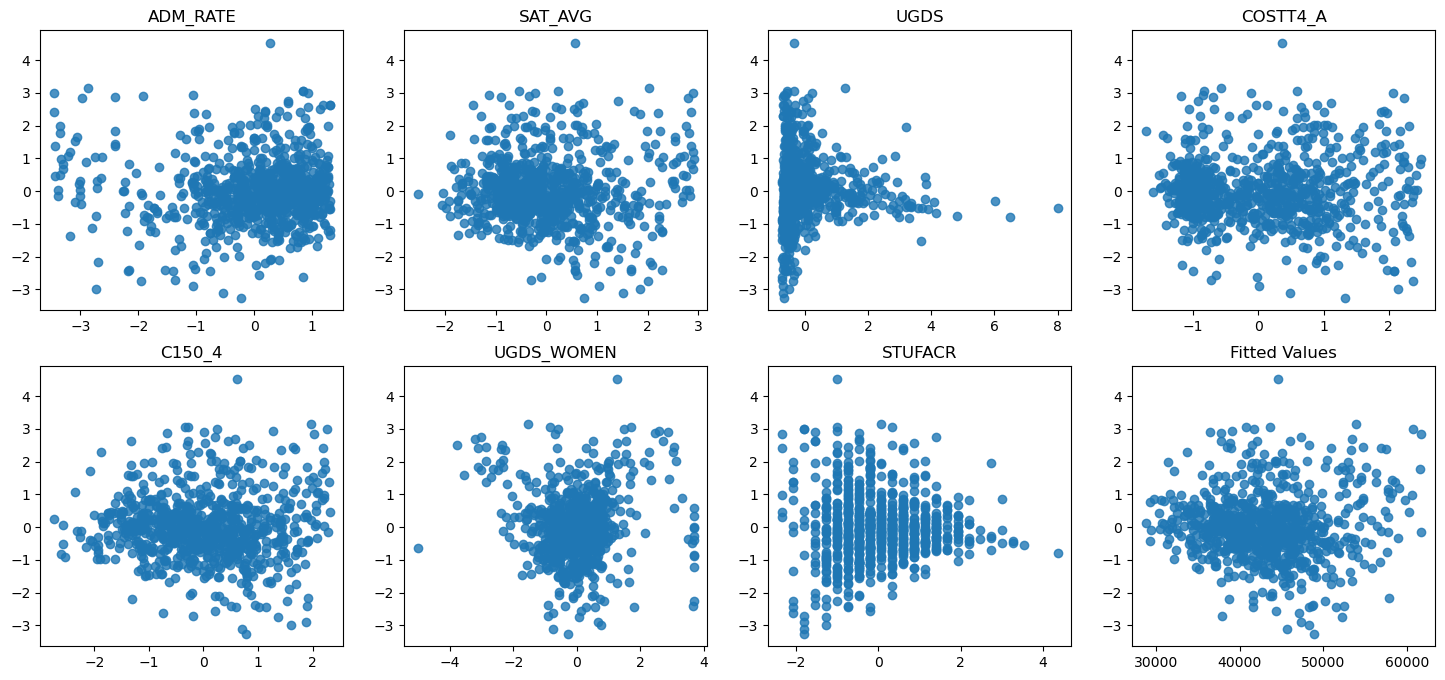

In [101]:
# Create canvas and order for the plots
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(18,8))
# Make the plots std of residuals against X_feature,i 
for i, cc in enumerate(X_ss_encoded_df.columns[:7]):
    plt.subplot(2,4, i+1)
    plt.scatter(X_ss_encoded_df[cc], model_ss_ohe_inf_res, alpha=0.8)
    plt.title(cc)
# Make residual plot
plt.subplot(2,4,8)
plt.scatter(model_ss_ohe.fittedvalues, model_ss_ohe_inf_res, alpha=0.8)
plt.title('Fitted Values');

/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


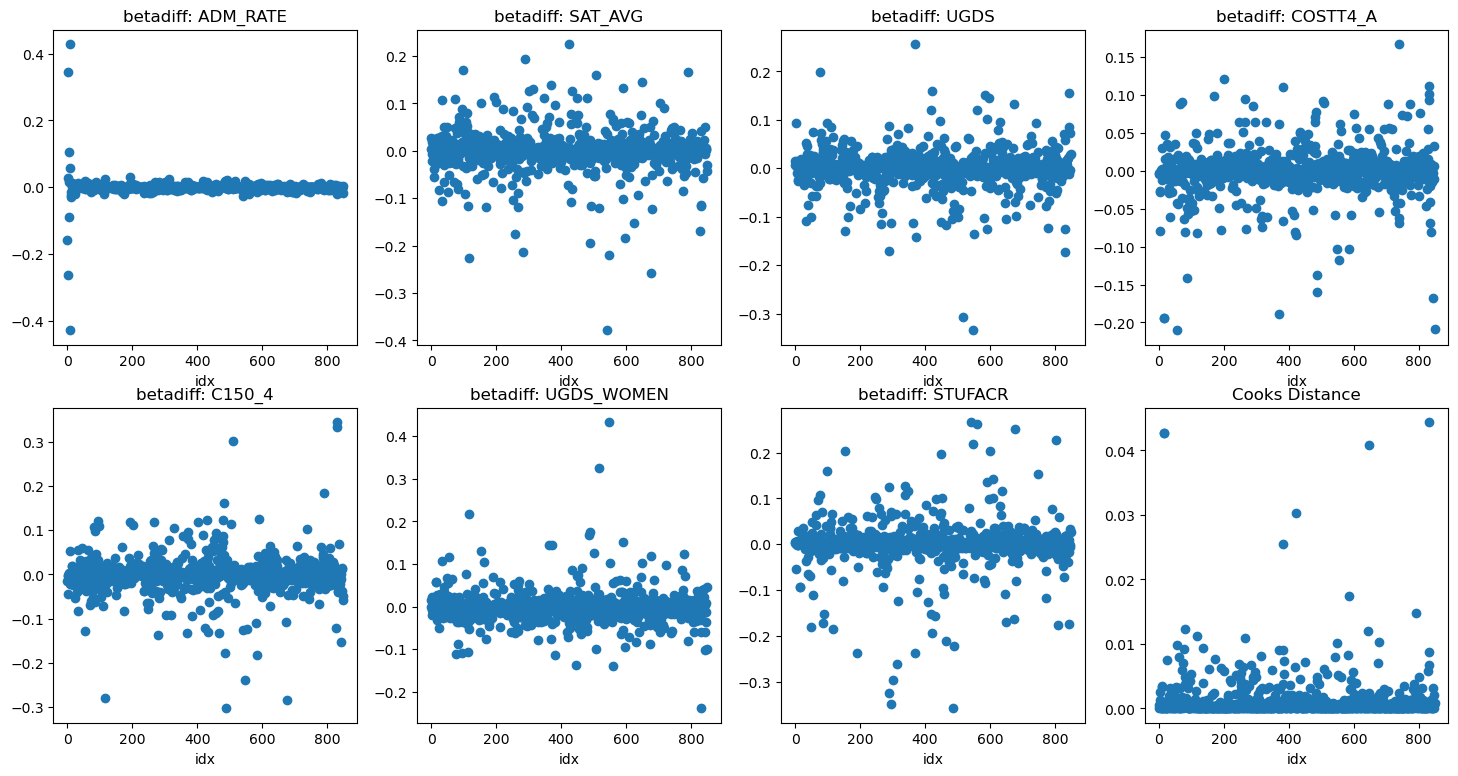

In [102]:
# Create canvas and order for the plots
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(18,9))
for idx, col in enumerate(col_title):
    plt.subplot(2,4,idx+1)
    plt.scatter(np.arange(850), model_ss_ohe_inf.dfbetas[:, idx]);plt.title(f'betadiff: {col}');plt.xlabel('idx');
# Make cook's distance plot
plt.subplot(2,4,8)
plt.scatter(np.arange(850), model_ss_ohe_inf.cooks_distance[0]);plt.title('Cooks Distance');plt.xlabel('idx');

The 2 graphs above just serves to confirm that I built my pipeline correctly.  

In [103]:
# Calculate the VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_ss_encoded_df_const.columns  # Include the constant term
vif_data["VIF"] = [oinf.variance_inflation_factor(X_ss_encoded_df_const.values, i) for i in range(X_ss_encoded_df_const.shape[1])]

In [104]:
vif_data

Feature        VIF
0                        const  61.923117
1                     ADM_RATE   1.676956
2                      SAT_AVG   4.970032
3                         UGDS   2.150142
4                     COSTT4_A   2.844045
5                       C150_4   4.446850
6                   UGDS_WOMEN   1.197649
7                      STUFACR   2.244987
8                 state_Alaska   1.079046
9                state_Arizona   1.158702
10              state_Arkansas   1.772023
11            state_California   3.011468
12              state_Colorado   1.917368
13           state_Connecticut   2.023565
14              state_Delaware   1.080606
15  state_District of Columbia   1.383799
16               state_Florida   3.101748
17               state_Georgia   2.846447
18                state_Hawaii   1.211776
19                 state_Idaho   1.218385
20              state_Illinois   3.316027
21               state_Indiana   2.978580
22                  state_Iowa   2.162537
23                state_Kansas   1.800312
24              state_Kentucky   1.836997
25             state_Louisiana   2.185133
26                 state_Maine   1.217547
27              state_Maryland   1.781946
28         state_Massachusetts   3.632529
29              state_Michigan   2.559334
30             state_Minnesota   2.156529
31           state_Mississippi   1.980379
32              state_Missouri   2.731962
33               state_Montana   1.432848
34              state_Nebraska   1.648937
35                state_Nevada   1.074298
36         state_New Hampshire   1.228968
37            state_New Jersey   2.583756
38            state_New Mexico   1.370003
39              state_New York   5.287976
40        state_North Carolina   3.124773
41          state_North Dakota   1.509632
42                  state_Ohio   3.722114
43              state_Oklahoma   2.043332
44                state_Oregon   1.791441
45          state_Pennsylvania   4.751087
46          state_Rhode Island   1.408575
47        state_South Carolina   2.260150
48          state_South Dakota   1.717280
49             state_Tennessee   2.803306
50                 state_Texas   4.473065
51                  state_Utah   1.368224
52               state_Vermont   1.226076
53              state_Virginia   2.538419
54            state_Washington   1.758559
55         state_West Virginia   1.789916
56             state_Wisconsin   2.822247

-----
The VIF for categorical features are not really important.   
They just 'switch on' when it is in that category... 
Hence overall VIF is alright.  
VIF for categorical features will no longer be examined.  

The Variance Inflation Factor (VIF) is a measure used to assess multicollinearity in regression models. It quantifies how much the variance of the estimated regression coefficients is increased due to multicollinearity among the predictor variables. VIF is typically applied to numeric (continuous) features, not categorical ones.

Categorical variables, when they are one-hot encoded or dummy encoded, can create multicollinearity issues with other features, especially when one level of the categorical variable can be perfectly predicted from the others (dummy variable trap). However, multicollinearity among dummy variables of a categorical variable is usually not a significant concern. If there is perfect multicollinearity (one variable can be perfectly predicted from the others), it's a common practice to drop one level to avoid the "dummy variable trap."

VIF is not typically used to assess multicollinearity among categorical variables, as it's more applicable to continuous variables. For categorical variables, the focus is usually on ensuring that there is no perfect multicollinearity, which involves dropping one level if necessary, and the importance of each level is often determined through significance tests or other relevant methods.

From the graphs, and also p value, UGDS need to be transformed.  
STUFACR maybe also need transformation.   
Consider dropping COSTT4_A due to high p value.  

In [105]:
X_ss_encoded_df.head()

ADM_RATE   SAT_AVG      UGDS  COSTT4_A    C150_4  UGDS_WOMEN   STUFACR  \
0 -0.101921 -1.641878 -0.127113 -1.004807 -1.978721    0.154477  1.135805   
1  0.738244  0.802304  0.863442 -0.750555  0.145072    0.388851  1.403981   
2  0.000744  1.068657  0.146360 -0.831640  0.038203   -1.488744  1.403981   
3  1.206931 -1.634044 -0.321085 -1.003984 -1.956482    0.636246 -0.205076   
4  0.260134  0.629957  2.973906 -0.468196  0.749223   -0.127639  1.403981   

   state_Alaska  state_Arizona  state_Arkansas  ...  state_South Carolina  \
0             0              0               0  ...                     0   
1             0              0               0  ...                     0   
2             0              0               0  ...                     0   
3             0              0               0  ...                     0   
4             0              0               0  ...                     0   

   state_South Dakota  state_Tennessee  state_Texas  state_Utah  \
0                   0                0            0           0   
1                   0                0            0           0   
2                   0                0            0           0   
3                   0                0            0           0   
4                   0                0            0           0   

   state_Vermont  state_Virginia  state_Washington  state_West Virginia  \
0              0               0                 0                    0   
1              0               0                 0                    0   
2              0               0                 0                    0   
3              0               0                 0                    0   
4              0               0                 0                    0   

   state_Wisconsin  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 56 columns]

In [106]:
X["UGDS"].min()

137.0

In [107]:
X["STUFACR"].min()

5.0

In [108]:
def log_df(df, col_2_log):
    """Apply log on selected columns and return a new df
    """
    df_log = df.copy(deep=True)
    df_log[col_2_log] = df_log[col_2_log].apply(np.log)
    return df_log
# Standard scaler may need inverse, don't write function for it

In [109]:
# Log 2 colmuns
log_2_col = ["UGDS", "STUFACR"]
X_log_2_col = log_df(X, log_2_col)
X_log_2_col.head()
# Apply ss
# Scale the data first!
ss = StandardScaler()
X_log2_ss = ss.fit_transform(X_log_2_col[col_title])
# Create a new dataframe with the scaled numerical columns
X_log2_ss_df = pd.DataFrame(X_log2_ss, columns=col_title)
# Concatenate the scaled numerical dataframe with the categorical dataframe
X_log2_ss_df["state"] = X["STATE"]
# Show the final df
X_log2_ss_df.head()

ADM_RATE   SAT_AVG      UGDS  COSTT4_A    C150_4  UGDS_WOMEN   STUFACR  \
0 -0.101921 -1.641878  0.406431 -1.004807 -1.978721    0.154477  1.088089   
1  0.738244  0.802304  1.250773 -0.750555  0.145072    0.388851  1.280152   
2  0.000744  1.068657  0.729934 -0.831640  0.038203   -1.488744  1.280152   
3  1.206931 -1.634044  0.073605 -1.003984 -1.956482    0.636246 -0.067908   
4  0.260134  0.629957  1.990030 -0.468196  0.749223   -0.127639  1.280152   

     state  
0  Alabama  
1  Alabama  
2  Alabama  
3  Alabama  
4  Alabama

In [110]:
# OHE the dataframe
X_log2_ss_encoded_df = pd.get_dummies(X_log2_ss_df, columns=["state"], drop_first=True)
X_log2_ss_encoded_df.head(3)

ADM_RATE   SAT_AVG      UGDS  COSTT4_A    C150_4  UGDS_WOMEN   STUFACR  \
0 -0.101921 -1.641878  0.406431 -1.004807 -1.978721    0.154477  1.088089   
1  0.738244  0.802304  1.250773 -0.750555  0.145072    0.388851  1.280152   
2  0.000744  1.068657  0.729934 -0.831640  0.038203   -1.488744  1.280152   

   state_Alaska  state_Arizona  state_Arkansas  ...  state_South Carolina  \
0             0              0               0  ...                     0   
1             0              0               0  ...                     0   
2             0              0               0  ...                     0   

   state_South Dakota  state_Tennessee  state_Texas  state_Utah  \
0                   0                0            0           0   
1                   0                0            0           0   
2                   0                0            0           0   

   state_Vermont  state_Virginia  state_Washington  state_West Virginia  \
0              0               0                 0                    0   
1              0               0                 0                    0   
2              0               0                 0                    0   

   state_Wisconsin  
0                0  
1                0  
2                0  

[3 rows x 56 columns]

In [111]:
model_log2_ss_ohe, X_log2_ss_encoded_df_const = fit_ols(X_log2_ss_encoded_df, y)
model_log2_ss_ohe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     7.653
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           7.82e-45
Time:                        22:29:30   Log-Likelihood:                -8880.8
No. Observations:                 850   AIC:                         1.788e+04
Df Residuals:                     793   BIC:                         1.815e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       4.307e+04   2335.796     18.440      0.000    3.85e+04    4.77e+04
ADM_RATE                    -549.4368    386.631     -1.421      0.156   -1308.377     209.504
SAT_AVG                     1181.8873    680.705      1.736      0.083    -154.308    2518.083
UGDS                        2914.5626    471.469      6.182      0.000    1989.088    3840.038
COSTT4_A                    1240.1860    485.390      2.555      0.011     287.385    2192.987
C150_4                       815.9158    620.070      1.316      0.189    -401.256    2033.088
UGDS_WOMEN                 -1328.7528    326.295     -4.072      0.000   -1969.256    -688.249
STUFACR                    -1951.2802    473.426     -4.122      0.000   -2880.596   -1021.964
state_Alaska                4650.9691   8972.942      0.518      0.604    -1.3e+04    2.23e+04
state_Arizona               4785.7843   6567.629      0.729      0.466   -8106.210    1.77e+04
state_Arkansas             -4843.5281   3492.971     -1.387      0.166   -1.17e+04    2013.034
state_California            -655.8976   2940.690     -0.223      0.824   -6428.355    5116.560
state_Colorado               744.5320   3341.965      0.223      0.824   -5815.611    7304.675
state_Connecticut           3873.6236   3315.070      1.168      0.243   -2633.726    1.04e+04
state_Delaware              1217.1653   8980.430      0.136      0.892   -1.64e+04    1.88e+04
state_District of Columbia   -31.6314   4557.162     -0.007      0.994   -8977.159    8913.896
state_Florida              -2566.1571   2825.214     -0.908      0.364   -8111.940    2979.626
state_Georgia               -318.1951   2853.125     -0.112      0.911   -5918.765    5282.375
state_Hawaii               -5343.9264   5498.749     -0.972      0.331   -1.61e+04    5449.897
state_Idaho                -6544.0203   5519.487     -1.186      0.236   -1.74e+04    4290.512
state_Illinois              1019.3904   2792.944      0.365      0.715   -4463.047    6501.828
state_Indiana                990.6480   2866.759      0.346      0.730   -4636.685    6617.981
state_Iowa                  -673.9699   3211.216     -0.210      0.834   -6977.459    5629.519
state_Kansas                2834.7187   3517.691      0.806      0.421   -4070.369    9739.806
state_Kentucky              -822.2268   3405.313     -0.241      0.809   -7506.720    5862.267
state_Louisiana            -1168.4803   3126.460     -0.374      0.709   -7305.595    4968.635
state_Maine                 2714.2498   5512.659      0.492      0.623   -8106.879    1.35e+04
state_Maryland             -2143.8362   3500.831     -0.612      0.540   -9015.827    4728.155
state_Massachusetts         2914.8447   2772.442      1.051      0.293   -2527.348    8357.037
state_Michigan              3561.3831   298

In [112]:
model_log2_ss_ohe_inf = model_log2_ss_ohe.get_influence()
model_log2_ss_ohe_inf_res = model_log2_ss_ohe_inf.get_resid_studentized_external()

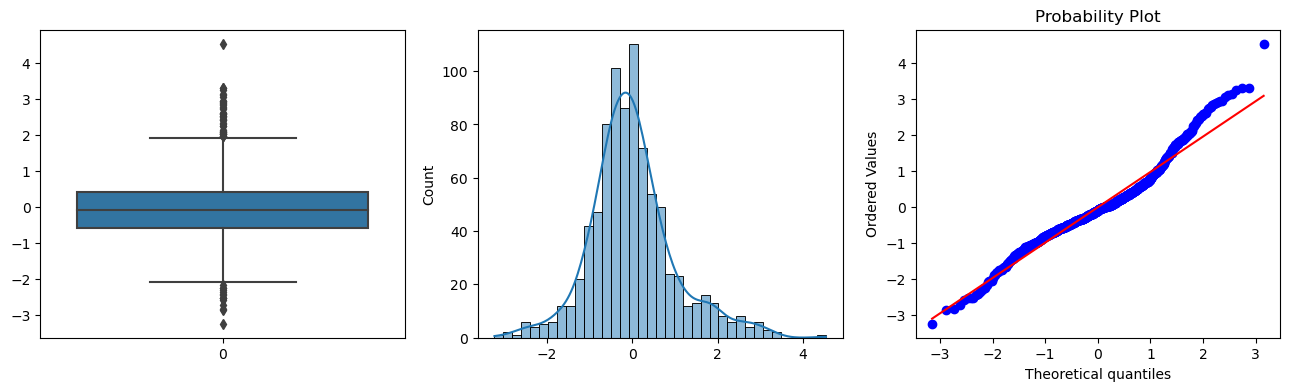

In [113]:
# Check noramlity of residual
check_normality(model_log2_ss_ohe_inf_res)

In [114]:
# Check RMSPE
check_rmse_with_naive(model_log2_ss_ohe, y);

The root mean squared predicted error is 11698.713
The naive model have rmse of 10359.325
The improvement is -1339.388


The root mean squared predicted error is pretty bad!  
This means our model is very uncertain!  

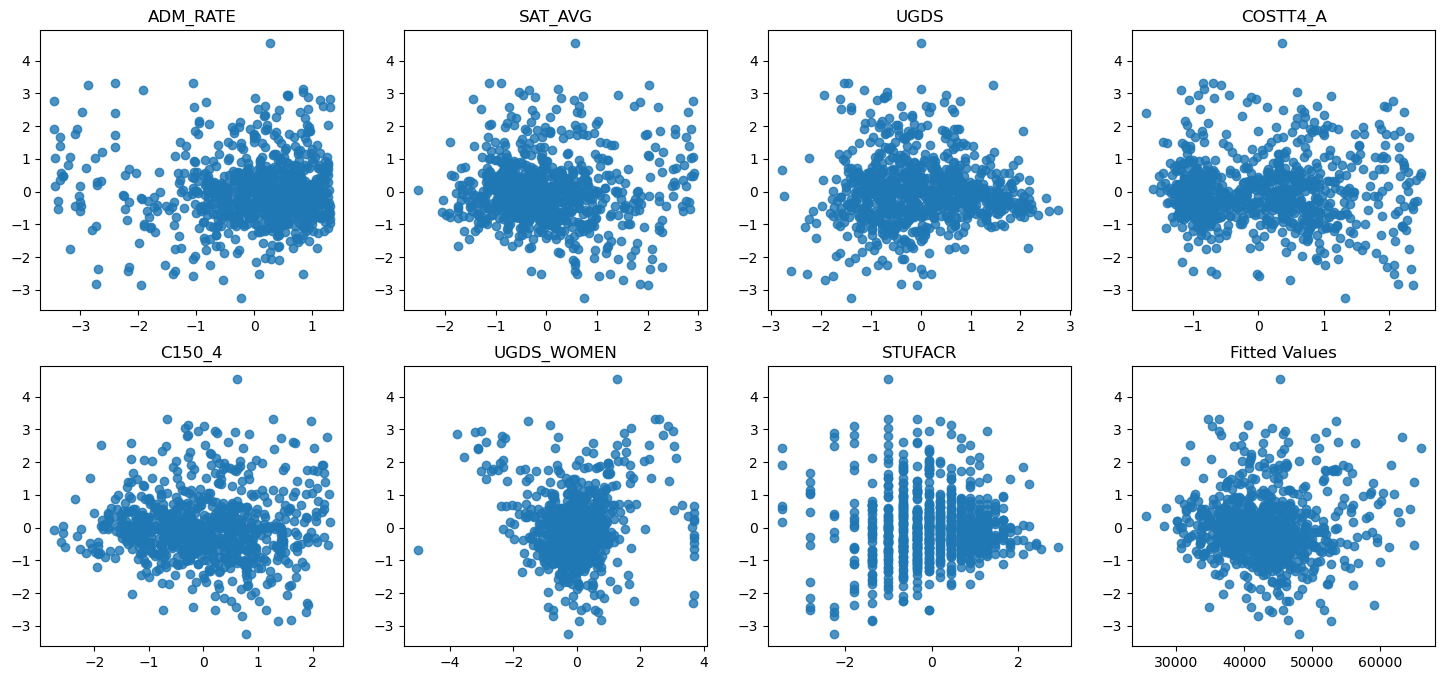

In [115]:
# Create canvas and order for the plots
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(18,8))
# Make the plots std of residuals against X_feature,i 
for i, cc in enumerate(X.columns[:7]):
    plt.subplot(2,4, i+1)
    plt.scatter(X_log2_ss_encoded_df_const[cc], model_log2_ss_ohe_inf_res, alpha=0.8)
    plt.title(cc)
# Make residual plot
plt.subplot(2,4,8)
plt.scatter(model_log2_ss_ohe.fittedvalues, model_log2_ss_ohe_inf_res, alpha=0.8)
plt.title('Fitted Values');

/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


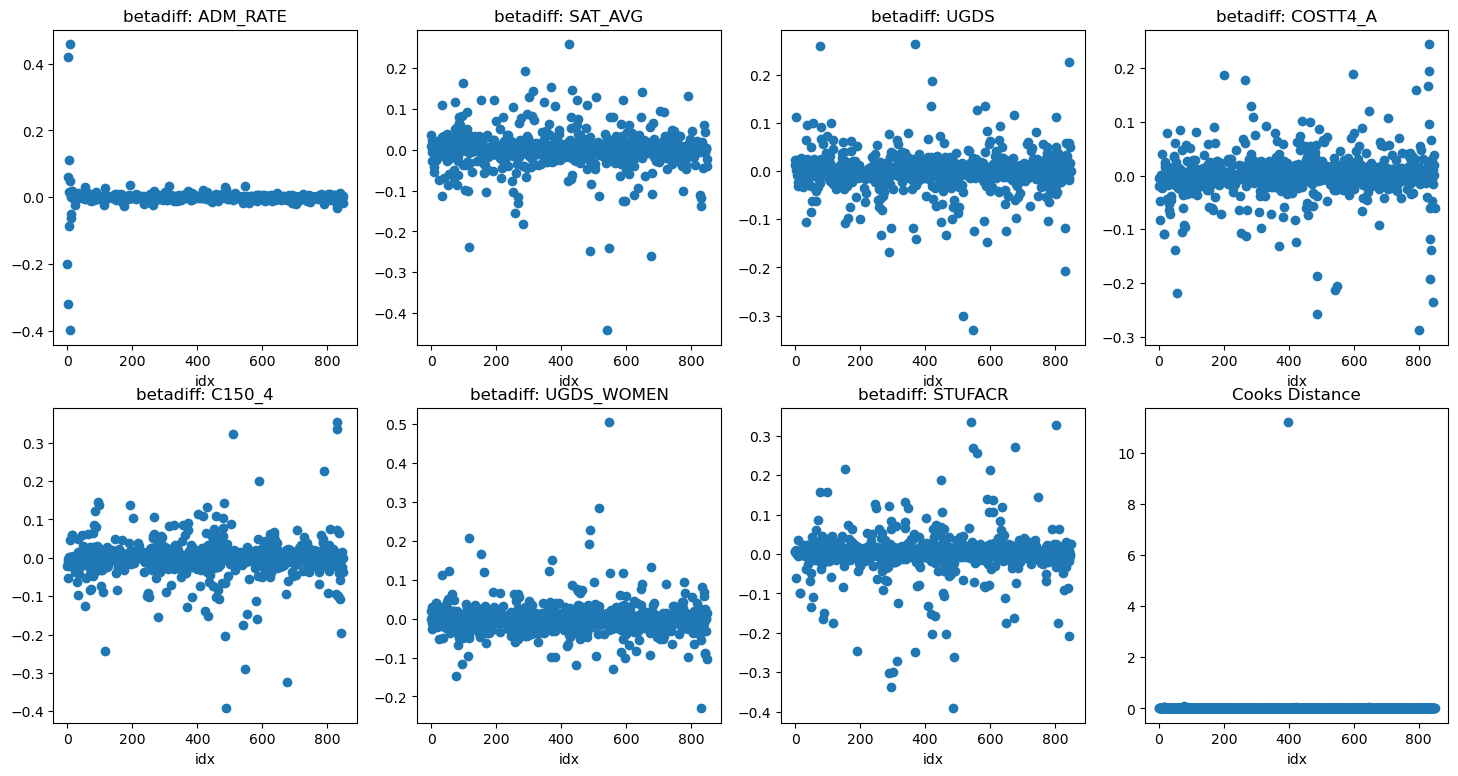

In [116]:
# Create canvas and order for the plots
f, axs = plt.subplots(2, 4, squeeze=False, figsize=(18,9))
for idx, col in enumerate(col_title):
    plt.subplot(2,4,idx+1)
    plt.scatter(np.arange(850), model_log2_ss_ohe_inf.dfbetas[:, idx]);plt.title(f'betadiff: {col}');plt.xlabel('idx');
# Make cook's distance plot
plt.subplot(2,4,8)
plt.scatter(np.arange(850), model_log2_ss_ohe_inf.cooks_distance[0]);plt.title('Cooks Distance');plt.xlabel('idx');

The reason wehy we are having a high RMSPE is likely becasue of outlier.  
Shown by the single point in the cook's distance plot hanging high above the rest.  

SAT_AVG, ADM_RATE and C150_4 presents a problem now.  
Last time they are: ADM_RATE, COST and UDGS... 

In [117]:
# Calculate the VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_ss_encoded_df_const.columns  # Include the constant term
vif_data["VIF"] = [oinf.variance_inflation_factor(X_ss_encoded_df_const.values, i) for i in range(X_ss_encoded_df_const.shape[1])]
vif_data[:8]

Feature        VIF
0       const  61.923117
1    ADM_RATE   1.676956
2     SAT_AVG   4.970032
3        UGDS   2.150142
4    COSTT4_A   2.844045
5      C150_4   4.446850
6  UGDS_WOMEN   1.197649
7     STUFACR   2.244987

----
Do a quick analysis with ADM_RATE dropped.  
Check on RMSPE and R squared.  

In [118]:
X_log2_ss_encoded_wo_adm_df = X_log2_ss_encoded_df.drop(columns=["ADM_RATE"])
X_log2_ss_encoded_wo_adm_df.head(2)

SAT_AVG      UGDS  COSTT4_A    C150_4  UGDS_WOMEN   STUFACR  state_Alaska  \
0 -1.641878  0.406431 -1.004807 -1.978721    0.154477  1.088089             0   
1  0.802304  1.250773 -0.750555  0.145072    0.388851  1.280152             0   

   state_Arizona  state_Arkansas  state_California  ...  state_South Carolina  \
0              0               0                 0  ...                     0   
1              0               0                 0  ...                     0   

   state_South Dakota  state_Tennessee  state_Texas  state_Utah  \
0                   0                0            0           0   
1                   0                0            0           0   

   state_Vermont  state_Virginia  state_Washington  state_West Virginia  \
0              0               0                 0                    0   
1              0               0                 0                    0   

   state_Wisconsin  
0                0  
1                0  

[2 rows x 55 columns]

In [119]:
model_log2_ss_wo_adm_ohe, X_log2_ss_encoded_wo_adm_df_const = fit_ols(X_log2_ss_encoded_wo_adm_df, y)
model_log2_ss_wo_adm_ohe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     7.746
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           6.73e-45
Time:                        22:29:33   Log-Likelihood:                -8881.8
No. Observations:                 850   AIC:                         1.788e+04
Df Residuals:                     794   BIC:                         1.814e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       4.312e+04   2337.036     18.451      0.000    3.85e+04    4.77e+04
SAT_AVG                     1436.1590    657.189      2.185      0.029     146.125    2726.192
UGDS                        2922.9209    471.735      6.196      0.000    1996.926    3848.916
COSTT4_A                    1271.3176    485.207      2.620      0.009     318.878    2223.757
C150_4                       805.4908    620.424      1.298      0.195    -412.375    2023.357
UGDS_WOMEN                 -1352.5231    326.075     -4.148      0.000   -1992.594    -712.452
STUFACR                    -2072.5676    465.968     -4.448      0.000   -2987.243   -1157.893
state_Alaska                4815.1312   8977.956      0.536      0.592   -1.28e+04    2.24e+04
state_Arizona               4471.0768   6568.107      0.681      0.496   -8421.831    1.74e+04
state_Arkansas             -4609.8418   3491.337     -1.320      0.187   -1.15e+04    2243.500
state_California            -684.4662   2942.509     -0.233      0.816   -6460.482    5091.550
state_Colorado               477.1363   3338.805      0.143      0.886   -6076.792    7031.065
state_Connecticut           3922.3350   3317.020      1.182      0.237   -2588.830    1.04e+04
state_Delaware              1091.0566   8985.755      0.121      0.903   -1.65e+04    1.87e+04
state_District of Columbia   361.9955   4551.656      0.080      0.937   -8572.706    9296.697
state_Florida              -2291.8273   2820.421     -0.813      0.417   -7828.189    3244.535
state_Georgia               -161.6337   2852.827     -0.057      0.955   -5761.608    5438.341
state_Hawaii               -5506.8294   5501.082     -1.001      0.317   -1.63e+04    5291.553
state_Idaho                -6567.6751   5523.004     -1.189      0.235   -1.74e+04    4273.740
state_Illinois               983.0448   2794.619      0.352      0.725   -4502.671    6468.760
state_Indiana                760.7732   2864.028      0.266      0.791   -4861.189    6382.736
state_Iowa                  -759.9177   3212.707     -0.237      0.813   -7066.322    5546.486
state_Kansas                2789.4177   3519.804      0.792      0.428   -4119.804    9698.640
state_Kentucky              -851.8370   3407.435     -0.250      0.803   -7540.482    5836.808
state_Louisiana             -984.0369   3125.769     -0.315      0.753   -7119.785    5151.711
state_Maine                 2281.0689   5507.758      0.414      0.679   -8530.418    1.31e+04
state_Maryland             -2231.0965   3502.539     -0.637      0.524   -9106.427    4644.234
state_Massachusetts         2900.5811   2774.203      1.046      0.296   -2545.058    8346.220
state_Michigan              3440.2247   2984.728      1.153      0.249   -2418.665    9299.115
state_Minnesota             1379.1534   320

In [120]:
# Check naive
check_rmse_with_naive(model_log2_ss_wo_adm_ohe, y);

The root mean squared predicted error is 12272.324
The naive model have rmse of 10359.325
The improvement is -1912.999


No improvement found!!!  
Skip this.  

----
log everything, ss, ohe.  
Quick check.

In [121]:
# Log all columns
X_loga = X.copy(deep=True)
# Have to apply np.log1p() instead of np.log(), as np.log() gives errror due to small/ neagtive/ zero avlues
X_loga[col_title] = X_loga[col_title].apply(np.log1p)
# Apply ss
# Scale the data first!
ss = StandardScaler()
X_loga_ss = ss.fit_transform(X_loga[col_title])
# Create a new dataframe with the scaled numerical columns
X_loga_ss_df = pd.DataFrame(X_loga_ss, columns=col_title)
# Concatenate the scaled numerical dataframe with the categorical dataframe
X_loga_ss_df["state"] = X["STATE"]
# Show the final df
X_loga_ss_df.head()

ADM_RATE   SAT_AVG      UGDS  COSTT4_A    C150_4  UGDS_WOMEN   STUFACR  \
0 -0.031906 -1.809108  0.406306 -1.074465 -2.139042    0.189299  1.096692   
1  0.694981  0.845732  1.250938 -0.670842  0.193464    0.417923  1.294141   
2  0.060675  1.094422  0.729908 -0.791852  0.088444   -1.531475  1.294141   
3  1.072588 -1.799280  0.073403 -1.073034 -2.111508    0.655153 -0.078850   
4  0.289758  0.681233  1.990504 -0.294121  0.766902   -0.091089  1.294141   

     state  
0  Alabama  
1  Alabama  
2  Alabama  
3  Alabama  
4  Alabama

In [122]:
# OHE the dataframe
X_loga_ss_encoded_df = pd.get_dummies(X_loga_ss_df, columns=["state"], drop_first=True)
X_loga_ss_encoded_df.head(3)

ADM_RATE   SAT_AVG      UGDS  COSTT4_A    C150_4  UGDS_WOMEN   STUFACR  \
0 -0.031906 -1.809108  0.406306 -1.074465 -2.139042    0.189299  1.096692   
1  0.694981  0.845732  1.250938 -0.670842  0.193464    0.417923  1.294141   
2  0.060675  1.094422  0.729908 -0.791852  0.088444   -1.531475  1.294141   

   state_Alaska  state_Arizona  state_Arkansas  ...  state_South Carolina  \
0             0              0               0  ...                     0   
1             0              0               0  ...                     0   
2             0              0               0  ...                     0   

   state_South Dakota  state_Tennessee  state_Texas  state_Utah  \
0                   0                0            0           0   
1                   0                0            0           0   
2                   0                0            0           0   

   state_Vermont  state_Virginia  state_Washington  state_West Virginia  \
0              0               0                 0                    0   
1              0               0                 0                    0   
2              0               0                 0                    0   

   state_Wisconsin  
0                0  
1                0  
2                0  

[3 rows x 56 columns]

In [123]:
model_loga_ss_ohe, X_loga_ss_encoded_df_const = fit_ols(X_loga_ss_encoded_df, y)
model_loga_ss_ohe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     7.830
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           4.70e-46
Time:                        22:29:34   Log-Likelihood:                -8877.3
No. Observations:                 850   AIC:                         1.787e+04
Df Residuals:                     793   BIC:                         1.814e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       4.306e+04   2327.187     18.505      0.000    3.85e+04    4.76e+04
ADM_RATE                    -926.1511    382.709     -2.420      0.016   -1677.394    -174.909
SAT_AVG                      921.2668    643.783      1.431      0.153    -342.454    2184.988
UGDS                        3101.9477    474.061      6.543      0.000    2171.386    4032.510
COSTT4_A                    1138.3495    461.945      2.464      0.014     231.569    2045.130
C150_4                       775.4725    602.200      1.288      0.198    -406.621    1957.566
UGDS_WOMEN                 -1621.0906    324.860     -4.990      0.000   -2258.778    -983.403
STUFACR                    -2082.9036    470.945     -4.423      0.000   -3007.349   -1158.458
state_Alaska                4589.8207   8939.450      0.513      0.608    -1.3e+04    2.21e+04
state_Arizona               4295.4543   6546.105      0.656      0.512   -8554.288    1.71e+04
state_Arkansas             -4976.2187   3478.516     -1.431      0.153   -1.18e+04    1851.969
state_California            -314.7668   2923.499     -0.108      0.914   -6053.478    5423.944
state_Colorado               646.1131   3328.663      0.194      0.846   -5887.920    7180.146
state_Connecticut           4080.0892   3301.481      1.236      0.217   -2400.585    1.06e+04
state_Delaware              1175.8416   8940.355      0.132      0.895   -1.64e+04    1.87e+04
state_District of Columbia  -186.2910   4542.082     -0.041      0.967   -9102.216    8729.634
state_Florida              -2750.8030   2814.654     -0.977      0.329   -8275.857    2774.251
state_Georgia               -342.9573   2842.009     -0.121      0.904   -5921.707    5235.793
state_Hawaii               -5161.0914   5476.373     -0.942      0.346   -1.59e+04    5588.810
state_Idaho                -6718.3925   5498.476     -1.222      0.222   -1.75e+04    4074.896
state_Illinois               884.9349   2782.778      0.318      0.751   -4577.547    6347.417
state_Indiana               1170.6327   2859.273      0.409      0.682   -4442.005    6783.270
state_Iowa                  -823.5007   3197.457     -0.258      0.797   -7099.980    5452.979
state_Kansas                2476.0079   3504.220      0.707      0.480   -4402.637    9354.652
state_Kentucky              -940.9685   3392.350     -0.277      0.782   -7600.016    5718.079
state_Louisiana            -1104.6539   3113.998     -0.355      0.723   -7217.307    5007.999
state_Maine                 2840.0802   5491.403      0.517      0.605   -7939.325    1.36e+04
state_Maryland             -2043.0478   3490.232     -0.585      0.558   -8894.233    4808.138
state_Massachusetts         3089.2534   2757.828      1.120      0.263   -2324.252    8502.759
state_Michigan              3270.7548   297

In [124]:
# Check naive
check_rmse_with_naive(model_loga_ss_ohe, y);

The root mean squared predicted error is 26337.308
The naive model have rmse of 10359.325
The improvement is -15977.983


The RMSPE just exploeded.  
Knowing a graduate earn about 40k, my model is as good as saying nothing if the RMSPE is this high.   
Your predicted earning is 40K +/- 26K.  
This is not going to work...  
Skip log transformation, despite it giving better R squared and adjusted R squared.  

-----
try drop ADM_RATE with ss and ohe.  

In [125]:
X_ss_encoded_wo_adm_df = X_ss_encoded_df.drop(columns=["ADM_RATE"])
X_ss_encoded_wo_adm_df.head(3)

SAT_AVG      UGDS  COSTT4_A    C150_4  UGDS_WOMEN   STUFACR  state_Alaska  \
0 -1.641878 -0.127113 -1.004807 -1.978721    0.154477  1.135805             0   
1  0.802304  0.863442 -0.750555  0.145072    0.388851  1.403981             0   
2  1.068657  0.146360 -0.831640  0.038203   -1.488744  1.403981             0   

   state_Arizona  state_Arkansas  state_California  ...  state_South Carolina  \
0              0               0                 0  ...                     0   
1              0               0                 0  ...                     0   
2              0               0                 0  ...                     0   

   state_South Dakota  state_Tennessee  state_Texas  state_Utah  \
0                   0                0            0           0   
1                   0                0            0           0   
2                   0                0            0           0   

   state_Vermont  state_Virginia  state_Washington  state_West Virginia  \
0              0               0                 0                    0   
1              0               0                 0                    0   
2              0               0                 0                    0   

   state_Wisconsin  
0                0  
1                0  
2                0  

[3 rows x 55 columns]

In [126]:
model_ss_ohe_wo_adm, X_ss_encoded_wo_adm_df_const = fit_ols(X_ss_encoded_wo_adm_df, y)
model_ss_ohe_wo_adm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_1YR   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     6.790
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           2.64e-38
Time:                        22:29:34   Log-Likelihood:                -8900.6
No. Observations:                 850   AIC:                         1.791e+04
Df Residuals:                     794   BIC:                         1.818e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         4.4e+04   2384.191     18.456      0.000    3.93e+04    4.87e+04
SAT_AVG                     2630.4443    649.878      4.048      0.000    1354.762    3906.126
UGDS                         741.1696    444.036      1.669      0.095    -130.453    1612.793
COSTT4_A                     650.9915    509.802      1.277      0.202    -349.728    1651.711
C150_4                      1260.0202    638.842      1.972      0.049       6.000    2514.040
UGDS_WOMEN                 -1142.4067    331.324     -3.448      0.001   -1792.780    -492.033
STUFACR                     -796.8250    448.119     -1.778      0.076   -1676.463      82.813
state_Alaska                4924.0073   9181.200      0.536      0.592   -1.31e+04    2.29e+04
state_Arizona               3817.5624   6727.328      0.567      0.571   -9387.888     1.7e+04
state_Arkansas             -5779.8885   3564.996     -1.621      0.105   -1.28e+04    1218.042
state_California           -2127.3238   2998.283     -0.710      0.478   -8012.822    3758.175
state_Colorado               474.7274   3413.512      0.139      0.889   -6225.847    7175.301
state_Connecticut           2727.8768   3386.229      0.806      0.421   -3919.142    9374.896
state_Delaware               964.3969   9188.161      0.105      0.916   -1.71e+04     1.9e+04
state_District of Columbia   864.2650   4652.144      0.186      0.853   -8267.689    9996.219
state_Florida              -3183.9098   2885.495     -1.103      0.270   -8848.010    2480.190
state_Georgia              -1112.6910   2912.927     -0.382      0.703   -6830.640    4605.258
state_Hawaii               -5810.8337   5623.152     -1.033      0.302   -1.68e+04    5227.168
state_Idaho                -8315.4614   5639.789     -1.474      0.141   -1.94e+04    2755.197
state_Illinois               780.2191   2856.323      0.273      0.785   -4826.618    6387.056
state_Indiana               -119.9609   2925.695     -0.041      0.967   -5862.971    5623.050
state_Iowa                 -2056.9432   3278.196     -0.627      0.531   -8491.899    4378.012
state_Kansas                1991.5747   3597.138      0.554      0.580   -5069.449    9052.598
state_Kentucky             -1721.0192   3481.018     -0.494      0.621   -8554.105    5112.067
state_Louisiana            -1674.4349   3196.262     -0.524      0.601   -7948.556    4599.687
state_Maine                 2483.2311   5630.173      0.441      0.659   -8568.552    1.35e+04
state_Maryland             -2935.7142   3578.507     -0.820      0.412   -9960.167    4088.739
state_Massachusetts         1756.8881   2830.269      0.621      0.535   -3798.806    7312.583
state_Michigan              2999.9707   3051.644      0.983      0.326   -2990.273    8990.214
state_Minnesota              531.2913   327

In [127]:
# Check naive
check_rmse_with_naive(model_ss_ohe_wo_adm, y);

The root mean squared predicted error is 12835.463
The naive model have rmse of 10359.325
The improvement is -2476.138


This is a no as well.

----
## Q2 Part 2 Summary

Final recommendation:
1. Remove the most influential point at index 375.   
2. Do not log the data,this will make the RMSPE exlode. (Maybe can try other forms of manipulation)  
3. Standardise the data.   
4. Include in the `STATE`.  

Reason:   
Most graduates have median income at about 40k USD.  
It doesn't make sense if the RMSPE is very large, espcially when RMSPE's baseline is 11k.  
This is already 25% of not uncertainty.  
The range is too large to be of any practical use, even if the R squared and adjusted R squared is high.  
I want a model that keeps the RMSPE smaller than the baseline model.  

The pipeline I built at the start can simply take in the predictor X, and target y, and give a resultant model.   
This is efficient and error free code for anyone to use.  

----

Then there's also possibility of categorising the `STATE`, to reduce model complexity.  

But its 10.00 p.m. and I have worked on this Take home assignment for more than 48 hours added togther.
So I am tired T_T.  
It is fun, but very draining.  
Thanks for the exam!  
I really enjoyed it!  


----
# Bonus marks?

Be a try hard and apply lasso.  
Why lasso?  
It help to shrink some of the coefficients to 0, while Ridge doesn't.  
Also, Cross Validation can be used here to further enhance the model.  
Mainly to ensure a good bias variance trade off.  
This case this model is difficult to get a good result.  

In [128]:
# Split the data into training and test set at random.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
# Build a pipeline for regression model
lasso = Pipeline(
    steps=[("preprocessor", preprocessor), ("Lasso", LinearRegression())]
)

In [130]:
lasso.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['ADM_RATE', 'SAT_AVG',
                                                   'UGDS', 'COSTT4_A', 'C150_4',
                                                   'UGDS_WOMEN', 'STUFACR']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['STATE'])])),
                ('Lasso', LinearRegression())])

In [131]:
print(f"The train score is: {round(lasso.score(X_train, y_train), 6)}")
print(f"The test score is: {round(lasso.score(X_test, y_test), 6)}")

The train score is: 0.360396
The test score is: 0.102656


/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [132]:
# Craete a pipeline for lasso cross validation. 
lasso_CV = Pipeline(
    steps=[("preprocessor", preprocessor), ("Lasso CV", LassoCV(max_iter=10000, cv=5))]
)

In [133]:
lasso_CV.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['ADM_RATE', 'SAT_AVG',
                                                   'UGDS', 'COSTT4_A', 'C150_4',
                                                   'UGDS_WOMEN', 'STUFACR']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['STATE'])])),
                ('Lasso CV', LassoCV(cv=5, max_iter=10000))])

In [134]:
print(f"The train score is: {round(lasso_CV.score(X_train, y_train), 6)}")
print(f"The test score is: {round(lasso_CV.score(X_test, y_test), 6)}")

The train score is: 0.334638
The test score is: 0.147699


/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Classical over fitting.  
Fitted too well on data present, but can't generalise well. 

In [135]:
# Specify range of hyperparameters to tune
lasso_params = {'alpha':[0.1, 0.5, 1, 10, 100]}

In [136]:
# Perform grid search using GridSearchCV()
grid_search = GridSearchCV(Lasso(max_iter=20000),
                           param_grid=lasso_params,
                           cv=5,
                           verbose = 3,
                           return_train_score=True
                           )

lasso_grid_search_CV = Pipeline(
    steps=[("preprocessor", preprocessor), ("Lasso Grid Search", grid_search)]
) 

In [137]:
lasso_grid_search_CV.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ....alpha=0.1;, score=(train=0.403, test=-0.023) total time=   0.0s
[CV 2/5] END .....alpha=0.1;, score=(train=0.340, test=0.338) total time=   0.0s
[CV 3/5] END .....alpha=0.1;, score=(train=0.381, test=0.155) total time=   0.0s
[CV 4/5] END .....alpha=0.1;, score=(train=0.388, test=0.120) total time=   0.0s
[CV 5/5] END .....alpha=0.1;, score=(train=0.353, test=0.350) total time=   0.0s
[CV 1/5] END ....alpha=0.5;, score=(train=0.403, test=-0.019) total time=   0.0s
[CV 2/5] END .....alpha=0.5;, score=(train=0.340, test=0.342) total time=   0.0s
[CV 3/5] END .....alpha=0.5;, score=(train=0.381, test=0.157) total time=   0.0s
[CV 4/5] END .....alpha=0.5;, score=(train=0.388, test=0.122) total time=   0.0s
[CV 5/5] END .....alpha=0.5;, score=(train=0.353, test=0.351) total time=   0.0s
[CV 1/5] END ......alpha=1;, score=(train=0.403, test=-0.014) total time=   0.0s
[CV 2/5] END .......alpha=1;, score=(train=0.339,

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['ADM_RATE', 'SAT_AVG',
                                                   'UGDS', 'COSTT4_A', 'C150_4',
                                                   'UGDS_WOMEN', 'STUFACR']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['STATE'])])),
                ('Lasso Grid Search',
                 GridSearchCV(cv=5, estimator=Lasso(max_iter=20000),
                              param_grid={'alpha': [0.1, 0.5, 1, 10, 100]},
                              return_train_score=True, verbose=3))])

In [138]:
lasso_grid_search_CV[1].best_score_

0.2246004423395882

In [139]:
# cv results
cv_results = pd.DataFrame(lasso_grid_search_CV[1].cv_results_)
cv_results[['mean_fit_time', 'param_alpha', 'mean_test_score', 'mean_train_score']]

mean_fit_time param_alpha  mean_test_score  mean_train_score
0       0.007890         0.1         0.188155          0.373033
1       0.005221         0.5         0.190492          0.372983
2       0.003669           1         0.193097          0.372884
3       0.001996          10         0.221124          0.368970
4       0.001335         100         0.224600          0.296181

Maybe the alpha need to larger.   
When alpha is 0, it is OLS.    
Larger alpha mean higher regularisation strength.   
I would say about 10, from the brief looks here.  

----
Toying with ridge.

In [140]:
# Build a pipeline for regression model
# default setting did not converge
ridge = Pipeline(
    steps=[("preprocessor", preprocessor), ("Ridge", Ridge())]
)

In [141]:
ridge.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['ADM_RATE', 'SAT_AVG',
                                                   'UGDS', 'COSTT4_A', 'C150_4',
                                                   'UGDS_WOMEN', 'STUFACR']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['STATE'])])),
                ('Ridge', Ridge())])

In [142]:
print(f"The train score is: {round(ridge.score(X_train, y_train), 6)}")
print(f"The test score is: {round(ridge.score(X_test, y_test), 6)}")

The train score is: 0.358873
The test score is: 0.12497


/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Classic example of over fitting.  
The train test score is too far apart from each other.

In [143]:
ridge_CV = Pipeline(
    steps=[("preprocessor", preprocessor), ("Ridge CV", RidgeCV(alphas=[0.1, 1, 10, 100, 1000], store_cv_values=True, alpha_per_target=True))]
)

In [144]:
ridge_CV.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['ADM_RATE', 'SAT_AVG',
                                                   'UGDS', 'COSTT4_A', 'C150_4',
                                                   'UGDS_WOMEN', 'STUFACR']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['STATE'])])),
                ('Ridge CV',
                 RidgeCV(alpha_per_target=True, alphas=[0.1, 1, 10, 100, 1000],
                         store_cv_values=True))])

In [145]:
print(f"The train score is: {round(ridge_CV.score(X_train, y_train), 6)}")
print(f"The test score is: {round(ridge_CV.score(X_test, y_test), 6)}")

The train score is: 0.339406
The test score is: 0.152738


/home/zhiming/miniconda3/envs/nus_i4_gen/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [146]:
cv_results= pd.DataFrame(ridge_CV[1].cv_values_, columns=['alpha=0.1', 'alpha=1', 'alpha=10', 'alpha=100', 'alpha=1000'])
cv_results.shape

(680, 5)

In [147]:
cv_results.head()

alpha=0.1       alpha=1      alpha=10     alpha=100    alpha=1000
0  1.465018e+07  1.501629e+07  1.828409e+07  2.000052e+07  1.467375e+07
1  2.431793e+08  2.472359e+08  2.615657e+08  2.728347e+08  2.835618e+08
2  2.781776e+06  3.176760e+06  6.018387e+06  1.472028e+07  1.350179e+07
3  1.451163e+08  1.398604e+08  1.383019e+08  1.475646e+08  1.772732e+08
4  5.586679e+06  5.583335e+06  5.719364e+06  7.884012e+06  1.486350e+07

In [148]:
ridge_CV[1].best_score_

-75581594.8608233

In [149]:
ridge_CV[1].n_features_in_

54

The best Alpha selected is 0.1.  
This means the default Ridge() is good enough.

----------------
There's mmore I can do, like elastic net.  
There's always the option of XGBoost!  
Ensemble learners.  
Or Neural Networks that can fit (almost) anything.  
But I know the sample size is small, so neural network doesn't work well. 
# END